# Lightning density 


## imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray 
import xesmf as xe
import cartopy.crs as ccrs
from datetime import datetime
import pandas as pd

from math import radians, cos, sin, asin, sqrt


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry
from textwrap import wrap

import shapely.geometry
import pyproj
#import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Polygon
from shapely.geometry import Point, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from matplotlib import ticker


from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import scipy

## functions

### calc_latlon

In [2]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
        
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

### dist

In [3]:
def dist(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

## data 

In [4]:
file_names_unsorted_pyrocb = []

path = '/data2/edworak/data/PyroCb/MCMIPF1/'
file = os.listdir(path)

for f in file: 
    file_names_unsorted_pyrocb.append(f)
file_names_pyrocb = sorted(file_names_unsorted_pyrocb)

goes_data_pyrocb = []

for i in range(10, 11):
    path = '/data2/edworak/data/PyroCb/MCMIPF1/'
    FILE = path + file_names_pyrocb[i]
    goes_data_pyrocb = xarray.open_dataset(FILE)
    ds_latlon = calc_latlon(goes_data_pyrocb)
ds_latlon

/tmp/ipykernel_4705/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/39)
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.1518 ... -0.1518
  * x                                       (x) float64 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    lat                                     (y, x) float64 nan nan ... nan nan
    lon                                     (y, x) float64 nan nan ... nan nan
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-07-01T05:50:02.1Z
    time_coverage_start:       2021-07-01T05:40:21.0Z
    time_coverage_end:         2021-07-01T05:49:51.8Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        75ce0b9c-3a8f-4525-b8ad-d0ac59337e7e

In [5]:
# goes_data_pyrocb = xarray.open_dataset('/data2/edworak/data/BT_allpyrocbs/202118105/OR_ABI-L2-MCMIPF-M6_G16_s20211810500209_e20211810509528_c20211810510019.nc')
goes_data_pyrocb = xarray.open_dataset('/data2/edworak/data/BT/202118202/OR_ABI-L2-MCMIPF-M6_G17_s20211820200319_e20211820209392_c20211820209545.nc')
ds_latlon = calc_latlon(goes_data_pyrocb)

lat_min, lat_max = 50, 65
lon_min, lon_max = -130, -115
lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

variables = ["t", "lat", "lon", "CMI_C14"]
ds_short = ds_selected[variables]
ds_short

/tmp/ipykernel_4705/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:  (y: 334, x: 562)
Coordinates:
    t        datetime64[ns] 2021-07-01T02:05:05.602790016
    lat      (y, x) float64 64.97 64.97 64.97 64.97 ... 50.01 50.01 50.02 50.02
    lon      (y, x) float64 -130.0 -129.9 -129.9 -129.8 ... -115.1 -115.1 -115.0
  * y        (y) float64 0.1448 0.1447 0.1447 0.1446 ... 0.1263 0.1262 0.1261
  * x        (x) float64 0.008316 0.008372 0.008428 ... 0.03962 0.03968 0.03973
    y_image  float32 0.0
    x_image  float32 0.0
Data variables:
    CMI_C14  (y, x) float32 236.4 235.0 236.0 233.2 ... 296.6 299.3 298.2 296.1
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-07-01T02:09:54.5Z
    time_coverage_start:       2021-07-01T02:00:31.9Z
    time_coverage_end:         2021-07-01T02:09:39.2Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        5d4352de-5b6e-4b8d-b328-adcaf01d4733

# regrid

In [6]:
# one degree latitude is 111 km - 1 km = 0.00899820035 deg 
# one degree longitude is 68 km - 1 km = 0.01401869158 deg for south end, 0.0213371266 for north end 

lat_vals =np.arange(50, 66, 1)
lon_vals =np.arange(-130, -114, 1)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]
ds_out = xarray.Dataset(
     {"lat": (["lat"], ds_out_lat_flat, {"units": "degrees_north"}),
     "lon": (["lon"], ds_out_lon_flat, {"units": "degrees_east"}) } )
ds_out


<xarray.Dataset>
Dimensions:  (lat: 1680, lon: 913)
Coordinates:
  * lat      (lat) float64 50.0 50.01 50.02 50.03 ... 64.97 64.98 64.99 65.0
  * lon      (lon) float64 -130.0 -130.0 -130.0 -130.0 ... -115.1 -115.0 -115.0
Data variables:
    *empty*

In [7]:
regridder = xe.Regridder(ds_short, ds_out, "bilinear")
dr_out = regridder(ds_short["CMI_C14"], keep_attrs=True)
dr_out

<xarray.DataArray 'CMI_C14' (lat: 1680, lon: 913)>
array([[      nan,       nan,       nan, ...,   0.     ,   0.     ,
          0.     ],
       [      nan,       nan,       nan, ...,   0.     ,   0.     ,
          0.     ],
       [      nan,       nan,       nan, ..., 298.3217 ,       nan,
          0.     ],
       ...,
       [  0.     ,   0.     ,   0.     , ..., 255.41219,       nan,
              nan],
       [  0.     ,   0.     ,   0.     , ..., 255.34814,       nan,
              nan],
       [  0.     ,   0.     ,   0.     , ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    t        datetime64[ns] 2021-07-01T02:05:05.602790016
    y_image  float32 0.0
    x_image  float32 0.0
  * lat      (lat) float64 50.0 50.01 50.02 50.03 ... 64.97 64.98 64.99 65.0
  * lon      (lon) float64 -130.0 -130.0 -130.0 -130.0 ... -115.1 -115.0 -115.0
Attributes:
    long_name:              ABI Cloud and Moisture Imagery brightness tempera...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF_C14
    regrid_method:          bilinear

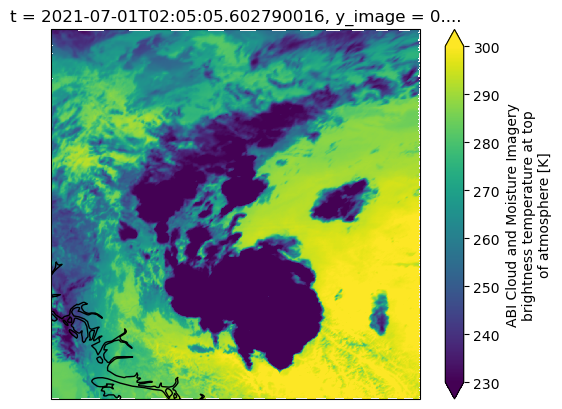

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

# Parallax 

## BT

### event 2 : hours 23 - 4

In [9]:
"""goes_data_pyrocb = []
lat_min, lat_max = 50, 65
lon_min, lon_max = -130, -115
variables = ["t", "lat", "lon", "CMI_C14"]
path = '/data2/edworak/data/PyroCb/MCMIPF1/'


for i in range(12, len(file_names_pyrocb)):
    FILE = path + file_names_pyrocb[i]
    print(FILE)
    goes_data_pyrocb = xarray.open_dataset(FILE)
    ds_latlon = calc_latlon(goes_data_pyrocb)

    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    ds_short = ds_selected[variables]
    ds_regrid = regridder(ds_short["CMI_C14"], keep_attrs=True)
    
    goes_data = ds_regrid - 273.15
    goes_data.attrs["units"] = "celsius"
    
    # Convert the xarray dataarray to a pandas dataframe
    df = goes_data.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    bt_hourly_df = df.loc[:, ("year","month","day", "hour", "minute", "second", "CMI_C14")] # "lat", "lon",
    
    bt_hourly_df.dropna(inplace = True)
    
    if i == 0: 
        bt_df = bt_hourly_df
    if i > 0: 
        bt_df = pd.concat([bt_df, bt_hourly_df], axis =0)
    
    """

'goes_data_pyrocb = []\nlat_min, lat_max = 50, 65\nlon_min, lon_max = -130, -115\nvariables = ["t", "lat", "lon", "CMI_C14"]\npath = \'/data2/edworak/data/PyroCb/MCMIPF1/\'\n\n\nfor i in range(12, len(file_names_pyrocb)):\n    FILE = path + file_names_pyrocb[i]\n    print(FILE)\n    goes_data_pyrocb = xarray.open_dataset(FILE)\n    ds_latlon = calc_latlon(goes_data_pyrocb)\n\n    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n    ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n    ds_short = ds_selected[variables]\n    ds_regrid = regridder(ds_short["CMI_C14"], keep_attrs=True)\n    \n    goes_data = ds_regrid - 273.15\n    goes_data.attrs["units"] = "celsius"\n    \n    # Convert the xarray dataarray to a pandas dataframe\n    df = goes_data.to_dataframe()\n    scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.%fZ\')\n    \

In [10]:
# bt_df.to_csv("/data2/edworak/data/regrid_mcmipf.nc")
bt_regrid_1 = pd.read_csv("/data2/edworak/data/regrid_mcmipf.nc")
bt_regrid_1 = bt_regrid_1.loc[(bt_regrid_1.CMI_C14 > -273) & (bt_regrid_1.CMI_C14 <= -20)]
print(np.unique(bt_regrid_1.hour))
bt_regrid_1

[ 0  1  2  3  4  5 23]


lat    lon  year  month  day  hour  minute  second    CMI_C14
692     51.5 -121.5  2021      7    1     4       5       6 -49.517136
693     51.5 -121.0  2021      7    1     4       5       6 -30.212708
754     52.0 -122.0  2021      7    1     4       5       6 -52.641296
755     52.0 -121.5  2021      7    1     4       5       6 -55.352554
756     52.0 -121.0  2021      7    1     4       5       6 -50.556274
...      ...    ...   ...    ...  ...   ...     ...     ...        ...
143077  64.0 -117.5  2021      7    1     3      55       5 -24.315690
143080  64.0 -116.0  2021      7    1     3      55       5 -22.025513
143138  64.5 -125.5  2021      7    1     3      55       5 -20.161850
143140  64.5 -124.5  2021      7    1     3      55       5 -23.037780
143141  64.5 -124.0  2021      7    1     3      55       5 -20.125840

[11460 rows x 9 columns]

### event 2: hour 22

In [11]:
folder_names_unsorted_b = []
path = '/data2/edworak/data/BT_allpyrocbs/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted_b.append(f)
folder_names_b = sorted(folder_names_unsorted_b)
folder_names_b = folder_names_b[:-1]
folder_names_b

file_names_unsorted_b = []

for i in range(len(folder_names_b)): 
    file = os.listdir(path + folder_names_b[i])
    file_names_unsorted_b.append(file)
file_names_b = sorted(file_names_unsorted_b)
file_names_b[17]

['OR_ABI-L2-MCMIPF-M6_G16_s20211812240207_e20211812249526_c20211812250017.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211812200207_e20211812209521_c20211812210019.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211812230207_e20211812239521_c20211812240027.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211812220207_e20211812229526_c20211812230022.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211812210207_e20211812219521_c20211812220017.nc',
 'OR_ABI-L2-MCMIPF-M6_G16_s20211812250207_e20211812259521_c20211812300027.nc']

In [12]:
"""path = '/data2/edworak/data/BT_allpyrocbs/'
goes_data_pyrocb = []
lat_min, lat_max = 50, 65
lon_min, lon_max = -130, -115
variables = ["t", "lat", "lon", "CMI_C14"]


for i in range(17, 18):
    for j in range(0, 6):
        FILE = path + folder_names_b[i] + '/' + file_names_b[i][j]
        print(FILE)
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))

        #select by lat/lon region
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
        ds_short = ds_selected[variables]
        ds_regrid = regridder(ds_short["CMI_C14"], keep_attrs=True)

        goes_data_b = ds_regrid - 273.15
        goes_data_b.attrs["units"] = "celsius"

        # Convert the xarray dataarray to a pandas dataframe
        df = goes_data_b.to_dataframe()
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

        df['Date'] = pd.to_datetime(df['t'])
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day
        df['hour'] = df['Date'].dt.hour
        df['minute'] = df['Date'].dt.minute
        df['second'] = df['Date'].dt.second

        bt_hourly_df_b = df.loc[:, ("year","month","day", "hour", "minute", "second", "CMI_C14")]
        bt_hourly_df_b.dropna(inplace = True)

        if j == 0: 
            bt_df_b = bt_hourly_df_b
        else: 
            bt_df_b = pd.concat([bt_df_b, bt_hourly_df_b], axis =0)
            
            """

'path = \'/data2/edworak/data/BT_allpyrocbs/\'\ngoes_data_pyrocb = []\nlat_min, lat_max = 50, 65\nlon_min, lon_max = -130, -115\nvariables = ["t", "lat", "lon", "CMI_C14"]\n\n\nfor i in range(17, 18):\n    for j in range(0, 6):\n        FILE = path + folder_names_b[i] + \'/\' + file_names_b[i][j]\n        print(FILE)\n        ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n        #select by lat/lon region\n        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n        ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n        ds_short = ds_selected[variables]\n        ds_regrid = regridder(ds_short["CMI_C14"], keep_attrs=True)\n\n        goes_data_b = ds_regrid - 273.15\n        goes_data_b.attrs["units"] = "celsius"\n\n        # Convert the xarray dataarray to a pandas dataframe\n        df = goes_data_b.to_dataframe()\n        scan_start = dateti

## lightning

In [13]:
data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

data_split2

year  month  day  hour  minute second     lat      lon  peak-current  \
0        2021      6    2    22      15     39  58.073 -119.732          14.7   
1        2021      6    2    22      15     40  58.043 -119.737          12.2   
2        2021      6    2    22      19     23  58.060 -118.448         -40.3   
3        2021      6    2    22      19     23  58.060 -118.449         -22.4   
4        2021      6    2    22      19     23  58.059 -118.448          -9.5   
...       ...    ...  ...   ...     ...    ...     ...      ...           ...   
1308797  2021      7   31    23      55     54  52.396 -123.137         -12.6   
1308798  2021      7   31    23      55     54  52.397 -123.148         -17.5   
1308799  2021      7   31    23      55     54  52.334 -123.095          -6.7   
1308800  2021      7   31    23      56     39  52.323 -122.974           2.4   
1308801  2021      7   31    23      59     57  52.412 -123.141           8.0   

        C or G  multi polarity     range  
0            C      0        +  11817.95  
1            C      0        +  11819.49  
2            G      0        -  11818.65  
3            G      0        -  11818.65  
4            G      0        -  11818.68  
...        ...    ...      ...       ...  
1308797      G      0        -  12104.32  
1308798      G      0        -  12104.26  
1308799      G      0        -  12107.33  
1308800      C      0        +  12107.86  
1308801      C      0        +  12103.51  

[1308802 rows x 13 columns]

In [14]:
data_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] >= 22) & (data_split2.lon >= -123) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -123) & (data_split2.lon <= -119) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
frames = [data_30, data_1]
data_event2= pd.concat(frames)
data_event2


year  month  day  hour  minute second     lat      lon  peak-current  \
277793  2021      6   30    22      12     59  51.215 -120.986          -6.3   
277829  2021      6   30    22      16     13  51.491 -120.962          -7.7   
277830  2021      6   30    22      17     08  51.354 -120.997           3.2   
277847  2021      6   30    22      19     12  51.501 -121.040           4.5   
277858  2021      6   30    22      20     29  51.579 -121.045           2.6   
...      ...    ...  ...   ...     ...    ...     ...      ...           ...   
333075  2021      7    1     3      59     31  52.728 -122.291           3.5   
333105  2021      7    1     3      59     34  52.719 -122.439           2.2   
333184  2021      7    1     3      59     43  52.867 -122.374          10.2   
333185  2021      7    1     3      59     43  52.896 -122.478         -13.9   
333243  2021      7    1     3      59     48  52.700 -122.423           5.6   

       C or G  multi polarity     range  
277793      C      0        -  12161.83  
277829      C      0        -  12148.47  
277830      C      0        +  12155.11  
277847      C      0        +  12147.96  
277858      C      0        +  12144.15  
...       ...    ...      ...       ...  
333075      C      0        +  12088.01  
333105      C      0        +  12088.45  
333184      C      0        +  12081.14  
333185      G      0        -  12079.72  
333243      C      0        +  12089.36  

[5996 rows x 13 columns]

## cloud top height

In [15]:
folder_names_unsorted_cth = []
path_cth = '/data2/edworak/data/cloud_top_height/'
folder_cth = os.listdir(path_cth)

for f in folder_cth: 
    folder_names_unsorted_cth.append(str(path_cth) + str(f))
folder_names_cth = sorted(folder_names_unsorted_cth)

folder_names_cth = folder_names_cth[:-2]


file_names_unsorted_cth = []

for i in range(len(folder_names_cth)): 
    file_cth = os.listdir(folder_names_cth[i])
    for f in file_cth: 
        file_names_unsorted_cth.append(str(folder_names_cth[i]) + "/" + str(f))
fullpath_cth = sorted(file_names_unsorted_cth)
fullpath_cth_pyrocb = fullpath_cth[521:557]
fullpath_cth_pyrocb

['/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812200319_e20211812209386_c20211812210445.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812210319_e20211812219386_c20211812220486.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812220319_e20211812229386_c20211812230390.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812230319_e20211812239386_c20211812240428.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812240319_e20211812249386_c20211812250443.nc',
 '/data2/edworak/data/cloud_top_height/202118122/OR_ABI-L2-ACHAF-M6_G17_s20211812250319_e20211812259386_c20211812300422.nc',
 '/data2/edworak/data/cloud_top_height/202118123/OR_ABI-L2-ACHAF-M6_G17_s20211812300319_e20211812309386_c20211812310445.nc',
 '/data2/edworak/data/cloud_top_height/202118123/OR_ABI-L2-ACHAF-M6_G17_s20211812310319_e20211812319386_c20211812320474.nc',


In [16]:
"""for i in range(len(fullpath_cth_pyrocb)):
    FILE = fullpath_cth_pyrocb[i] 
    ds_latlon = calc_latlon(xarray.open_dataset(FILE))

    #select by lat/lon region
    lat_min, lat_max = 51, 53
    lon_min, lon_max = -123, -119
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
    
    #select CMI_C14 channel anc convert into celsius
    max_cth = selected_region['maximum_cloud_top_height'][:]
    max_cth.attrs["units"] = "m"

#     mean_cth = selected_region['mean_cloud_top_height'][:]
#     mean_cth.attrs["units"] = "m"
    
    # Convert the xarray dataarray to a pandas dataframe
    df =  max_cth.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    cth_hourly_df_pyrocb = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "maximum_cloud_top_height")]
    cth_hourly_df_pyrocb.dropna(inplace = True)
    
    if i == 0: 
        cth_df_pyrocb = cth_hourly_df_pyrocb
    if i > 0: 
        cth_df_pyrocb = pd.concat([cth_df_pyrocb, cth_hourly_df_pyrocb], axis =0)

"""

'for i in range(len(fullpath_cth_pyrocb)):\n    FILE = fullpath_cth_pyrocb[i] \n    ds_latlon = calc_latlon(xarray.open_dataset(FILE))\n\n    #select by lat/lon region\n    lat_min, lat_max = 51, 53\n    lon_min, lon_max = -123, -119\n    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)\n    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)\n    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)\n    \n    #select CMI_C14 channel anc convert into celsius\n    max_cth = selected_region[\'maximum_cloud_top_height\'][:]\n    max_cth.attrs["units"] = "m"\n\n#     mean_cth = selected_region[\'mean_cloud_top_height\'][:]\n#     mean_cth.attrs["units"] = "m"\n    \n    # Convert the xarray dataarray to a pandas dataframe\n    df =  max_cth.to_dataframe()\n    scan_start = datetime.strptime(ds_latlon.time_coverage_start, \'%Y-%m-%dT%H:%M:%S.%fZ\')\n    \n    df[\'Date\'] = pd.to_datetime(df[\'t\'])\n    df[\'year\'] = df

In [17]:
df_cth_pyrocb = pd.read_csv('/data2/edworak/data/regrid_max_cth_event2.nc', usecols = [2, 3, 4, 5, 6, 7, 8, 9, 10])
df_cth_pyrocb

year  month  day  hour  minute  second        lat         lon  \
0     2021      6   30    22       5       5  52.806964 -122.940247   
1     2021      6   30    22       5       5  52.813535 -122.770777   
2     2021      6   30    22       5       5  52.820192 -122.601052   
3     2021      6   30    22       5       5  52.826937 -122.431066   
4     2021      6   30    22       5       5  52.833769 -122.260816   
...    ...    ...  ...   ...     ...     ...        ...         ...   
8923  2021      7    1     3      55       5  51.048044 -119.681394   
8924  2021      7    1     3      55       5  51.055640 -119.514640   
8925  2021      7    1     3      55       5  51.063319 -119.347587   
8926  2021      7    1     3      55       5  51.071082 -119.180230   
8927  2021      7    1     3      55       5  51.078930 -119.012564   

      maximum_cloud_top_height  
0                    17668.176  
1                    17668.176  
2                    17668.176  
3                    17668.176  
4                    17668.176  
...                        ...  
8923                 17616.904  
8924                 17616.904  
8925                 17616.904  
8926                 17616.904  
8927                 17616.904  

[8928 rows x 9 columns]

In [18]:
parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 51) & (parallax_testing.latitude <= 53) & (parallax_testing.longitude >= -123) & (parallax_testing.longitude <= -119)]
parallax_df

latitude  longitude  parallax_longitude  parallax_latitude  \
84028      51.0     -123.0            0.000008           0.000015   
84029      51.0     -122.5            0.000008           0.000015   
84030      51.0     -122.0            0.000008           0.000015   
84031      51.0     -121.5            0.000008           0.000015   
84032      51.0     -121.0            0.000009           0.000015   
84033      51.0     -120.5            0.000009           0.000015   
84034      51.0     -120.0            0.000009           0.000015   
84035      51.0     -119.5            0.000010           0.000015   
84036      51.0     -119.0            0.000010           0.000015   
84348      51.5     -123.0            0.000008           0.000015   
84349      51.5     -122.5            0.000008           0.000015   
84350      51.5     -122.0            0.000008           0.000015   
84351      51.5     -121.5            0.000009           0.000015   
84352      51.5     -121.0            0.000009           0.000015   
84353      51.5     -120.5            0.000009           0.000015   
84354      51.5     -120.0            0.000010           0.000015   
84355      51.5     -119.5            0.000010           0.000015   
84356      51.5     -119.0            0.000010           0.000015   
84668      52.0     -123.0            0.000008           0.000015   
84669      52.0     -122.5            0.000008           0.000015   
84670      52.0     -122.0            0.000009           0.000015   
84671      52.0     -121.5            0.000009           0.000015   
84672      52.0     -121.0            0.000009           0.000015   
84673      52.0     -120.5            0.000009           0.000015   
84674      52.0     -120.0            0.000010           0.000015   
84675      52.0     -119.5            0.000010           0.000015   
84676      52.0     -119.0            0.000010           0.000016   
84988      52.5     -123.0            0.000008           0.000016   
84989      52.5     -122.5            0.000008           0.000016   
84990      52.5     -122.0            0.000009           0.000016   
84991      52.5     -121.5            0.000009           0.000016   
84992      52.5     -121.0            0.000009           0.000016   
84993      52.5     -120.5            0.000010           0.000016   
84994      52.5     -120.0            0.000010           0.000016   
84995      52.5     -119.5            0.000010           0.000016   
84996      52.5     -119.0            0.000011           0.000016   
85308      53.0     -123.0            0.000008           0.000016   
85309      53.0     -122.5            0.000009           0.000016   
85310      53.0     -122.0            0.000009           0.000016   
85311      53.0     -121.5            0.000009           0.000016   
85312      53.0     -121.0            0.000010           0.000016   
85313      53.0     -120.5            0.000010           0.000016   
85314      53.0     -120.0            0.000010           0.000016   
85315      53.0     -119.5            0.000011           0.000016   
85316      53.0     -119.0            0.000011           0.000016   

       parallax_ratio  
84028        1.723566  
84029        1.730988  
84030        1.738702  
84031        1.746714  
84032        1.755025  
84033        1.763641  
84034        1.772566  
84035        1.781804  
84036        1.791359  
84348        1.760092  
84349        1.767612  
84350        1.775429  
84351        1.783547  
84352        1.791970  
84353        1.800702  
84354        1.809747  
84355        1.819111  
84356        1.828797  
84668        1.797782  
84669        1.805405  
84670        1.813330  
84671        1.821560  
84672        1.830101  
84673        1.838955  
84674        1.848128  
84675        1.857625  
84676        1.867449  
84988        1.836695  
84989        1.844428  
84990        1.852467  
84991        1.860817  
84992        1.869481  
84993        1.878465  
84994        1.8

## combine

### combine bt and cth

In [19]:
"""cth_bt_pyrocb = []

hours = [22, 23, 0, 1, 2, 3]
mins = range(0, 60, 10)

def find_nearest_max(lat, long):
    distances = cth_pyrocb_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return cth_pyrocb_time.loc[distances.idxmin(), 'maximum_cloud_top_height']


for i in range(len(hours)): 
    for j in range(len(mins)): 
        print(i)
        cth_pyrocb_time = df_cth_pyrocb.loc[(df_cth_pyrocb.hour == hours[i]) & (df_cth_pyrocb.minute >= mins[j]) & (df_cth_pyrocb.minute <= mins[j] + 9)]
        br_temp_pyrocb_time = bt_regrid_event2.loc[(bt_regrid_event2.hour == hours[i])& (bt_regrid_event2.minute >= mins[j]) & (bt_regrid_event2.minute <= mins[j] + 9)] 
        
        if (len(cth_pyrocb_time) >0) & (len(br_temp_pyrocb_time) >0): 
            
            br_temp_pyrocb_time['maximum_cloud_top_height'] = br_temp_pyrocb_time.apply(
                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)
            
            br_temp_pyrocb_time = pd.merge(br_temp_pyrocb_time, cth_pyrocb_time[['maximum_cloud_top_height', 'lat','lon']],on='maximum_cloud_top_height', how='left')

            # Rename the new columns as both the columns has same name, and python gets confused 
            br_temp_pyrocb_time = br_temp_pyrocb_time.rename(columns = {'lat_x':'bt_lat','lon_x':'bt_lon',
                                                                  'lat_y':'cth_lat','lon_y':'cth_lon'})

            br_temp_pyrocb_time['distance(km)'] = [dist(br_temp_pyrocb_time.bt_lon[i],br_temp_pyrocb_time.bt_lat[i],
                                                 br_temp_pyrocb_time.cth_lon[i], br_temp_pyrocb_time.cth_lat[i]) 
                                                 for i in range(len(br_temp_pyrocb_time))]
            br_temp_pyrocb_time['distance(km)'] = br_temp_pyrocb_time['distance(km)'].round(decimals=3)

            if len(cth_bt_pyrocb) == 0: 
                cth_bt_pyrocb = br_temp_pyrocb_time
            else: 
                cth_bt_pyrocb = pd.concat([cth_bt_pyrocb, br_temp_pyrocb_time], axis =0)
            cth_bt_pyrocb
            """

"cth_bt_pyrocb = []\n\nhours = [22, 23, 0, 1, 2, 3]\nmins = range(0, 60, 10)\n\ndef find_nearest_max(lat, long):\n    distances = cth_pyrocb_time.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)\n    return cth_pyrocb_time.loc[distances.idxmin(), 'maximum_cloud_top_height']\n\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        print(i)\n        cth_pyrocb_time = df_cth_pyrocb.loc[(df_cth_pyrocb.hour == hours[i]) & (df_cth_pyrocb.minute >= mins[j]) & (df_cth_pyrocb.minute <= mins[j] + 9)]\n        br_temp_pyrocb_time = bt_regrid_event2.loc[(bt_regrid_event2.hour == hours[i])& (bt_regrid_event2.minute >= mins[j]) & (bt_regrid_event2.minute <= mins[j] + 9)] \n        \n        if (len(cth_pyrocb_time) >0) & (len(br_temp_pyrocb_time) >0): \n            \n            br_temp_pyrocb_time['maximum_cloud_top_height'] = br_temp_pyrocb_time.apply(\n                lambda row: find_nearest_max(row['lat'], row['lon']), axis=1)\n            \n            br_t

In [20]:
# df = cth_bt_pyrocb
# df = df.sort_values('distance(km)', ascending=True)
# df = df.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'minute', 
#                                                       "CMI_C14", "bt_lat", "bt_lon"], keep='first')
cth_bt_event2 = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb_event2.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
cth_bt_event2



bt_lat  bt_lon  year  month  day  hour  minute  second    CMI_C14  \
0      53.0  -119.5  2021      7    1     2      15       5 -57.104310   
1      53.0  -119.5  2021      7    1     3      55       5 -57.672806   
2      53.0  -119.5  2021      7    1     2      35       5 -56.916245   
3      53.0  -119.5  2021      7    1     1      55       5 -56.936676   
4      53.0  -119.5  2021      7    1     1      45       5 -56.588135   
..      ...     ...   ...    ...  ...   ...     ...     ...        ...   
653    53.0  -119.0  2021      7    1     2      35       5 -45.522903   
654    53.0  -119.0  2021      7    1     3      15       5 -52.834045   
655    53.0  -119.0  2021      7    1     2      45       5 -49.684372   
656    53.0  -119.0  2021      7    1     3      45       5 -50.670746   
657    53.0  -119.0  2021      7    1     2      15       5 -26.575897   

     maximum_cloud_top_height    cth_lat     cth_lon  distance(km)  
0                   17391.332  52.955342 -119.497485         2.461  
1                   17616.904  52.955342 -119.497485         2.461  
2                   17624.521  52.955342 -119.497485         2.461  
3                   17432.475  52.955342 -119.497485         2.461  
4                   17343.707  52.955342 -119.497485         2.461  
..                        ...        ...         ...           ...  
653                 17624.521  52.780545 -119.065741        13.917  
654                 17853.450  52.780545 -119.065741        13.917  
655                 17697.275  52.780545 -119.065741        13.917  
656                 17766.783  52.780545 -119.065741        13.917  
657                 17391.332  52.780545 -119.065741        13.917  

[658 rows x 13 columns]

### combine bt, cth, parallax

In [21]:
def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_event2["parallax_longitude"] = cth_bt_event2.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_event2["parallax_latitude"] = cth_bt_event2.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_event2 = pd.merge(cth_bt_event2, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

cth_bt_event2['distance_plx'] = [dist(cth_bt_event2.bt_lon[i],cth_bt_event2.bt_lat[i],
                                     cth_bt_event2.longitude[i],cth_bt_event2.latitude[i]) 
                                     for i in range(len(cth_bt_event2))]
cth_bt_event2['distance_plx'] = cth_bt_event2['distance_plx'].round(decimals=3)

cth_bt_event2

bt_lat  bt_lon  year  month  day  hour  minute  second    CMI_C14  \
0      53.0  -119.5  2021      7    1     2      15       5 -57.104310   
1      53.0  -119.5  2021      7    1     3      55       5 -57.672806   
2      53.0  -119.5  2021      7    1     2      35       5 -56.916245   
3      53.0  -119.5  2021      7    1     1      55       5 -56.936676   
4      53.0  -119.5  2021      7    1     1      45       5 -56.588135   
..      ...     ...   ...    ...  ...   ...     ...     ...        ...   
653    53.0  -119.0  2021      7    1     2      35       5 -45.522903   
654    53.0  -119.0  2021      7    1     3      15       5 -52.834045   
655    53.0  -119.0  2021      7    1     2      45       5 -49.684372   
656    53.0  -119.0  2021      7    1     3      45       5 -50.670746   
657    53.0  -119.0  2021      7    1     2      15       5 -26.575897   

     maximum_cloud_top_height    cth_lat     cth_lon  distance(km)  \
0                   17391.332  52.955342 -119.497485         2.461   
1                   17616.904  52.955342 -119.497485         2.461   
2                   17624.521  52.955342 -119.497485         2.461   
3                   17432.475  52.955342 -119.497485         2.461   
4                   17343.707  52.955342 -119.497485         2.461   
..                        ...        ...         ...           ...   
653                 17624.521  52.780545 -119.065741        13.917   
654                 17853.450  52.780545 -119.065741        13.917   
655                 17697.275  52.780545 -119.065741        13.917   
656                 17766.783  52.780545 -119.065741        13.917   
657                 17391.332  52.780545 -119.065741        13.917   

     parallax_longitude  parallax_latitude  latitude  longitude  distance_plx  
0              0.000011           0.000016      53.0     -119.5           0.0  
1              0.000011           0.000016      53.0     -119.5           0.0  
2              0.000011           0.000016      53.0     -119.5           0.0  
3              0.000011           0.000016      53.0     -119.5           0.0  
4              0.000011           0.000016      53.0     -119.5           0.0  
..                  ...                ...       ...        ...           ...  
653            0.000011           0.000016      53.0     -119.0           0.0  
654            0.000011           0.000016      53.0     -119.0           0.0  
655            0.000011           0.000016      53.0     -119.0           0.0  
656            0.000011           0.000016      53.0     -119.0           0.0  
657            0.000011           0.000016      53.0     -119.0           0.0  

[658 rows x 18 columns]

In [22]:
print(cth_bt_event2.columns)

df2 = cth_bt_event2[['year', 'month', 'day', 'hour', 'minute', 'bt_lat', 'bt_lon', 'CMI_C14',
       'maximum_cloud_top_height', 'cth_lat', 'cth_lon', 'distance(km)',
       'parallax_longitude', 'parallax_latitude', 'latitude', 'longitude', 'distance_plx']].copy()
df2
cth_bt_plx_event2 = df2.drop_duplicates(keep='first')
cth_bt_plx_event2


Index(['bt_lat', 'bt_lon', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'CMI_C14', 'maximum_cloud_top_height', 'cth_lat', 'cth_lon',
       'distance(km)', 'parallax_longitude', 'parallax_latitude', 'latitude',
       'longitude', 'distance_plx'],
      dtype='object')


year  month  day  hour  minute  bt_lat  bt_lon    CMI_C14  \
0    2021      7    1     2      15    53.0  -119.5 -57.104310   
1    2021      7    1     3      55    53.0  -119.5 -57.672806   
2    2021      7    1     2      35    53.0  -119.5 -56.916245   
3    2021      7    1     1      55    53.0  -119.5 -56.936676   
4    2021      7    1     1      45    53.0  -119.5 -56.588135   
..    ...    ...  ...   ...     ...     ...     ...        ...   
653  2021      7    1     2      35    53.0  -119.0 -45.522903   
654  2021      7    1     3      15    53.0  -119.0 -52.834045   
655  2021      7    1     2      45    53.0  -119.0 -49.684372   
656  2021      7    1     3      45    53.0  -119.0 -50.670746   
657  2021      7    1     2      15    53.0  -119.0 -26.575897   

     maximum_cloud_top_height    cth_lat     cth_lon  distance(km)  \
0                   17391.332  52.955342 -119.497485         2.461   
1                   17616.904  52.955342 -119.497485         2.461   
2                   17624.521  52.955342 -119.497485         2.461   
3                   17432.475  52.955342 -119.497485         2.461   
4                   17343.707  52.955342 -119.497485         2.461   
..                        ...        ...         ...           ...   
653                 17624.521  52.780545 -119.065741        13.917   
654                 17853.450  52.780545 -119.065741        13.917   
655                 17697.275  52.780545 -119.065741        13.917   
656                 17766.783  52.780545 -119.065741        13.917   
657                 17391.332  52.780545 -119.065741        13.917   

     parallax_longitude  parallax_latitude  latitude  longitude  distance_plx  
0              0.000011           0.000016      53.0     -119.5           0.0  
1              0.000011           0.000016      53.0     -119.5           0.0  
2              0.000011           0.000016      53.0     -119.5           0.0  
3              0.000011           0.000016      53.0     -119.5           0.0  
4              0.000011           0.000016      53.0     -119.5           0.0  
..                  ...                ...       ...        ...           ...  
653            0.000011           0.000016      53.0     -119.0           0.0  
654            0.000011           0.000016      53.0     -119.0           0.0  
655            0.000011           0.000016      53.0     -119.0           0.0  
656            0.000011           0.000016      53.0     -119.0           0.0  
657            0.000011           0.000016      53.0     -119.0           0.0  

[658 rows x 17 columns]

In [23]:
cth_bt_plx_event2["tlat"] = cth_bt_plx_event2.bt_lat - cth_bt_plx_event2.parallax_latitude * cth_bt_plx_event2.maximum_cloud_top_height
cth_bt_plx_event2["tlon"] = cth_bt_plx_event2.bt_lon - cth_bt_plx_event2.parallax_longitude * cth_bt_plx_event2.maximum_cloud_top_height

correct_bt_event2 = cth_bt_plx_event2[['year', 'month', 'day', 'hour', 'minute',  "bt_lat", "bt_lon", "tlat", "tlon", 'CMI_C14']]
correct_bt_event2


year  month  day  hour  minute  bt_lat  bt_lon       tlat        tlon  \
0    2021      7    1     2      15    53.0  -119.5  52.718399 -119.685484   
1    2021      7    1     3      55    53.0  -119.5  52.714746 -119.687890   
2    2021      7    1     2      35    53.0  -119.5  52.714623 -119.687971   
3    2021      7    1     1      55    53.0  -119.5  52.717733 -119.685923   
4    2021      7    1     1      45    53.0  -119.5  52.719170 -119.684976   
..    ...    ...  ...   ...     ...     ...     ...        ...         ...   
653  2021      7    1     2      35    53.0  -119.0  52.714334 -119.193907   
654  2021      7    1     3      15    53.0  -119.0  52.710623 -119.196426   
655  2021      7    1     2      45    53.0  -119.0  52.713154 -119.194708   
656  2021      7    1     3      45    53.0  -119.0  52.712028 -119.195472   
657  2021      7    1     2      15    53.0  -119.0  52.718113 -119.191342   

       CMI_C14  
0   -57.104310  
1   -57.672806  
2   -56.916245  
3   -56.936676  
4   -56.588135  
..         ...  
653 -45.522903  
654 -52.834045  
655 -49.684372  
656 -50.670746  
657 -26.575897  

[658 rows x 10 columns]

### add lightning

In [24]:
"""# lightning_event2
# correct_bt_event2


lightning_df_event2 = []
# get it all into one 
# then limit it by time 
hours = [22, 23, 0, 1, 2, 3]
mins = range(0, 60, 5)

def find_nearest_event2(lat, long):
    distances = correct_bt_event2_time.apply(lambda row: dist(lat, long, row['tlat'], row['tlon']), axis=1)
    return correct_bt_event2_time.loc[distances.idxmin(), "CMI_C14"]

for i in range(len(hours)): 
    print(i)
    for j in range(len(mins)): 
        data_event2_time = data_event2.loc[(data_event2.hour == hours[i]) & (data_event2.minute >= mins[j]) & (data_event2.minute <= mins[j] + 9)]
        correct_bt_event2_time = correct_bt_event2.loc[(correct_bt_event2.hour == hours[i])& (correct_bt_event2.minute >= mins[j]) & (correct_bt_event2.minute <= mins[j] + 9)] 
        
        if (len(data_event2_time) >0) & (len(correct_bt_event2_time) >0): 
            
            data_event2_time['CMI_C14'] = data_event2_time.apply(
                lambda row: find_nearest_event2(row['lat'], row['lon']), axis=1)

            data_event2_time = pd.merge(data_event2_time, correct_bt_event2_time[['CMI_C14','tlat','tlon', 'bt_lat', 'bt_lon']],on='CMI_C14', how='left')


            # Rename the new columns as both the columns has same name, and python gets confused 
            data_event2_time = data_event2_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                                  'lat_y':'tlat','lon_y':'tlon'})

            data_event2_time['distance(km)'] = [dist(data_event2_time.lon[i],data_event2_time.lat[i],
                                                 data_event2_time.tlon[i],data_event2_time.tlat[i]) 
                                                 for i in range(len(data_event2_time))]
            data_event2_time['distance(km)'] = data_event2_time['distance(km)'].round(decimals=3)

            if len(lightning_df_event2) == 0: 
                lightning_df_event2 = data_event2_time
            else: 
                lightning_df_event2 = pd.concat([lightning_df_event2, data_event2_time], axis =0)
            lightning_df_event2
"""

'# lightning_event2\n# correct_bt_event2\n\n\nlightning_df_event2 = []\n# get it all into one \n# then limit it by time \nhours = [22, 23, 0, 1, 2, 3]\nmins = range(0, 60, 5)\n\ndef find_nearest_event2(lat, long):\n    distances = correct_bt_event2_time.apply(lambda row: dist(lat, long, row[\'tlat\'], row[\'tlon\']), axis=1)\n    return correct_bt_event2_time.loc[distances.idxmin(), "CMI_C14"]\n\nfor i in range(len(hours)): \n    print(i)\n    for j in range(len(mins)): \n        data_event2_time = data_event2.loc[(data_event2.hour == hours[i]) & (data_event2.minute >= mins[j]) & (data_event2.minute <= mins[j] + 9)]\n        correct_bt_event2_time = correct_bt_event2.loc[(correct_bt_event2.hour == hours[i])& (correct_bt_event2.minute >= mins[j]) & (correct_bt_event2.minute <= mins[j] + 9)] \n        \n        if (len(data_event2_time) >0) & (len(correct_bt_event2_time) >0): \n            \n            data_event2_time[\'CMI_C14\'] = data_event2_time.apply(\n                lambda row: 

## corrected

In [25]:
"""# correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
# correct_pyrocb = correct_pyrocb.sort_values('distance(km)', ascending=True)
# correct_pyrocb = correct_pyrocb.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
#                    'C or G', 'polarity'], keep='first') 
# df = correct_pyrocb.sort_index()
# df.to_csv('/data2/edworak/data/regridded_corrected_event2.nc')
correct_event2 = pd.read_csv('/data2/edworak/data/regridded_corrected_event2.nc', usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19])

correct_event2 = correct_event2.loc[(correct_event2.CMI_C14 <= -50)]
correct_event2

"""

'# correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])\n# correct_pyrocb = correct_pyrocb.sort_values(\'distance(km)\', ascending=True)\n# correct_pyrocb = correct_pyrocb.drop_duplicates(subset=[\'day\', \'hour\', \'minute\', \'lat\', \'lon\', \'peak-current\',\n#                    \'C or G\', \'polarity\'], keep=\'first\') \n# df = correct_pyrocb.sort_index()\n# df.to_csv(\'/data2/edworak/data/regridded_corrected_event2.nc\')\ncorrect_event2 = pd.read_csv(\'/data2/edworak/data/regridded_corrected_event2.nc\', usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19])\n\ncorrect_event2 = correct_event2.loc[(correct_event2.CMI_C14 <= -50)]\ncorrect_event2\n\n'

In [26]:
"""# grouped_event2 = correct_event2.groupby(['bt_lat', 'bt_lon', 'hour', 'C or G'])["peak-current"].count()
# grouped_event2.to_csv('/data2/edworak/data/regridded_grouped_event2.nc')

grouped_event2 = pd.read_csv('/data2/edworak/data/regridded_grouped_event2.nc')
grouped_event2

grouped_pyrocb4 = grouped_event2.loc[(grouped_event2.bt_lon >= -121.5) & (grouped_event2["C or G"] == "G")]
grouped_pyrocb4 = grouped_pyrocb4.sort_values('hour', ascending=True)
grouped_pyrocb4 = grouped_pyrocb4.rename(columns={'peak-current': 'lightning-count'})
grouped_pyrocb4"""

'# grouped_event2 = correct_event2.groupby([\'bt_lat\', \'bt_lon\', \'hour\', \'C or G\'])["peak-current"].count()\n# grouped_event2.to_csv(\'/data2/edworak/data/regridded_grouped_event2.nc\')\n\ngrouped_event2 = pd.read_csv(\'/data2/edworak/data/regridded_grouped_event2.nc\')\ngrouped_event2\n\ngrouped_pyrocb4 = grouped_event2.loc[(grouped_event2.bt_lon >= -121.5) & (grouped_event2["C or G"] == "G")]\ngrouped_pyrocb4 = grouped_pyrocb4.sort_values(\'hour\', ascending=True)\ngrouped_pyrocb4 = grouped_pyrocb4.rename(columns={\'peak-current\': \'lightning-count\'})\ngrouped_pyrocb4'

# Not Using

## Testing  5 km grid 

In [27]:
"""# one degree latitude is 111 km - 1 km = 0.00899820035 deg 
# one degree longitude is 68 km - 1 km = 0.01401869158 deg for sout5h end, 0.0213371266 for north end 

lat_vals =np.arange(50, 66, 1)
lon_vals =np.arange(-130, -114, 1)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])

ds_out5_lat = []
ds_out5_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out5_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out5_lon.append(ds_lon)

ds_out5_lon_flat = [item for sublist in ds_out5_lon for item in sublist]
ds_out5_lat_flat = [item for sublist in ds_out5_lat for item in sublist]
ds_out5 = xarray.Dataset(
     {"lat": (["lat"], ds_out5_lat_flat, {"units": "degrees_north"}),
     "lon": (["lon"], ds_out5_lon_flat, {"units": "degrees_east"}) } )
ds_out5
"""

'# one degree latitude is 111 km - 1 km = 0.00899820035 deg \n# one degree longitude is 68 km - 1 km = 0.01401869158 deg for sout5h end, 0.0213371266 for north end \n\nlat_vals =np.arange(50, 66, 1)\nlon_vals =np.arange(-130, -114, 1)\n\nresolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])\n\nds_out5_lat = []\nds_out5_lon = []\n\nfor i in range(0, len(lon_vals)-1):\n    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)\n    ds_out5_lat.append(ds_lat)\n    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])\n    ds_out5_lon.append(ds_lon)\n\nds_out5_lon_flat = [item for sublist in ds_out5_lon for item in sublist]\nds_out5_lat_flat = [item for sublist in ds_out5_lat for item in sublist]\nds_out5 = xarray.Dataset(\n     {"lat": (["lat"], ds_out5_lat_flat, {"units": "degrees_north"}),\n     "lon": (["lon"], ds_out5_lon_flat, {"units": "degrees_east"}) } )\nds_out5\n'

In [28]:
"""regridder = xe.Regridder(ds_short, ds_out5, "bilinear")
dr_out5 = regridder(ds_short["CMI_C14"], keep_attrs=True)
dr_out5 = dr_out - 273

# Use the mask to select the values within the range
dr_out5sel = dr_out5.where((dr_out5 > -273) & (dr_out5 <= -50))


dr_out5sel = dr_out5sel.where((dr_out5sel.lon >= -121.5) & (dr_out5sel.lon <= -120)
                          & (dr_out5sel.lat >= 51) & (dr_out5sel.lat <= 53))


dr_out5sel"""

'regridder = xe.Regridder(ds_short, ds_out5, "bilinear")\ndr_out5 = regridder(ds_short["CMI_C14"], keep_attrs=True)\ndr_out5 = dr_out - 273\n\n# Use the mask to select the values within the range\ndr_out5sel = dr_out5.where((dr_out5 > -273) & (dr_out5 <= -50))\n\n\ndr_out5sel = dr_out5sel.where((dr_out5sel.lon >= -121.5) & (dr_out5sel.lon <= -120)\n                          & (dr_out5sel.lat >= 51) & (dr_out5sel.lat <= 53))\n\n\ndr_out5sel'

In [29]:
"""# turn 1 km grid into dataframe 
# data_bt5 = dr_out5.to_dataframe()
# data_bt5.to_csv("/data2/edworak/data/kmgridtest5.csv")

data_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])
data_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]
data_bt5

data_30 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"] == 2) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_bt5"""

'# turn 1 km grid into dataframe \n# data_bt5 = dr_out5.to_dataframe()\n# data_bt5.to_csv("/data2/edworak/data/kmgridtest5.csv")\n\ndata_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])\ndata_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]\ndata_bt5\n\ndata_30 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"] == 2) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]\ndata_bt5'

In [30]:
"""# turn 1 km grid into dataframe 
data_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])
data_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & 
                      (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]

# assign lightning to grid by lat lon
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"] == 2) & 
                          (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]

lightning_df_5km = []

def find_nearest_5km(lat, long):
    distances = data_bt5.apply(lambda row: dist(lat, long, row['lat'], row['lon']), axis=1)
    return data_bt5.loc[distances.idxmin(), "CMI_C14"]


data_1['CMI_C14'] = data_1.apply(
    lambda row: find_nearest_5km(row['lat'], row['lon']), axis=1)

data_1 = pd.merge(data_1, data_bt5[['CMI_C14','lat','lon']],on='CMI_C14', how='left')


# Rename the new columns as both the columns has same name, and python gets confused 
data_1 = data_1.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                      'lat_y':'b_lat','lon_y':'b_lon'})

data_1['distance(km)'] = [dist(data_1.l_lon[i],data_1.l_lat[i],
                                     data_1.b_lon[i],data_1.b_lat[i]) 
                                     for i in range(len(data_1))]
data_1['distance(km)'] = data_1['distance(km)'].round(decimals=3)

if len(lightning_df_5km) == 0: 
    lightning_df_5km = data_1
else: 
    lightning_df_5km = pd.concat([lightning_df_5km, data_1], axis =0)
lightning_df_5km
"""

'# turn 1 km grid into dataframe \ndata_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])\ndata_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & \n                      (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]\n\n# assign lightning to grid by lat lon\ndata_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"] == 2) & \n                          (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]\n\nlightning_df_5km = []\n\ndef find_nearest_5km(lat, long):\n    distances = data_bt5.apply(lambda row: dist(lat, long, row[\'lat\'], row[\'lon\']), axis=1)\n    return data_bt5.loc[distances.idxmin(), "CMI_C14"]\n\n\ndata_1[\'CMI_C14\'] = data_1.apply(\n    lambda row: find_nearest_5km(row[\'lat\'], row[\'lon\']), axis=1)\n\ndata_1 = pd.merge(data_1, data_bt5[[\'CMI_C14\',\'lat\',\'lon\']],on=\'CMI_C14\', how=\'left\')\n\n\n# Rename the new colu

## 5 km for pyroCb 4

In [31]:
"""lat_min, lat_max = 51, 53
lon_min, lon_max = -121.5, -120
variables = ["t", "lat", "lon", "CMI_C14"]

data_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])
data_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]

data_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] == 23) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
data_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]
frames = [data_30, data_1]
data_event2= pd.concat(frames)


for i in range(len(file_names_pyrocb)):
    path = '/data2/edworak/data/PyroCb/MCMIPF1/'
    FILE = path + file_names_pyrocb[i]
    goes_data_pyrocb = xarray.open_dataset(FILE)
    
    ds_latlon = calc_latlon(goes_data_pyrocb)

    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    ds_selected = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

    ds_short = ds_selected[variables]
    
    regridder = xe.Regridder(ds_short, ds_out5, "bilinear")
    dr_out5 = regridder(ds_short["CMI_C14"], keep_attrs=True)
    dr_out5 = dr_out - 273

    # Use the mask to select the values within the range
    dr_out5sel = dr_out5.where((dr_out5 > -273) & (dr_out5 <= -50))
    """

'lat_min, lat_max = 51, 53\nlon_min, lon_max = -121.5, -120\nvariables = ["t", "lat", "lon", "CMI_C14"]\n\ndata_bt5= pd.read_csv("/data2/edworak/data/kmgridtest5.csv", usecols = [0, 1, 5])\ndata_bt5 = data_bt5.loc[(data_bt5.CMI_C14 > 0) & (data_bt5.lat >= 51) & (data_bt5.lat <= 53) & (data_bt5.lon >= -121.5) & (data_bt5.lon <= -120)]\n\ndata_30 = data_split2.loc[(data_split2["day"] == 30) & (data_split2["hour"] == 23) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]\ndata_1 = data_split2.loc[(data_split2["day"] == 1) & (data_split2["hour"]<= 3) & (data_split2.lon >= -121.5) & (data_split2.lon <= -120) & (data_split2.lat >= 51) & (data_split2.lat <= 53)]\nframes = [data_30, data_1]\ndata_event2= pd.concat(frames)\n\n\nfor i in range(len(file_names_pyrocb)):\n    path = \'/data2/edworak/data/PyroCb/MCMIPF1/\'\n    FILE = path + file_names_pyrocb[i]\n    goes_data_pyrocb = xarray.open_dataset(FILE)\n    \n    ds_latlon = calc_l

## trying things

In [32]:
"""cth_bt_pyrocb = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cth_bt_pyrocb
"""

'cth_bt_pyrocb = pd.read_csv("/data2/edworak/data/cth_bt_pyrocb.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])\ncth_bt_pyrocb\n'

In [33]:
"""parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")
# df = parallax.to_dataframe()
parallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")
parallax_testing.longitude = parallax_testing.longitude - 137
parallax_df = parallax_testing.loc[(parallax_testing.latitude >= 51) & (parallax_testing.latitude <= 53) & (parallax_testing.longitude >= -121.5) & (parallax_testing.longitude <= -120)]

"""

'parallax = xarray.open_dataset("/data2/edworak/data/cloud_top_height/geostationary_parallax.nc")\n# df = parallax.to_dataframe()\nparallax_testing = pd.read_csv("/data2/edworak/data/parallax_testing.nc")\nparallax_testing.longitude = parallax_testing.longitude - 137\nparallax_df = parallax_testing.loc[(parallax_testing.latitude >= 51) & (parallax_testing.latitude <= 53) & (parallax_testing.longitude >= -121.5) & (parallax_testing.longitude <= -120)]\n\n'

In [34]:
"""%%time

#cth_bt_plx_pyrocb = []

def find_nearest_lon(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]

def find_nearest_lat(lat, long):
    distances = parallax_df.apply(lambda row: dist(lat, long, row['latitude'], row['longitude']), axis=1)
    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]

cth_bt_pyrocb["parallax_longitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lon(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_pyrocb["parallax_latitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lat(row['bt_lat'], row['bt_lon']), axis=1)
cth_bt_pyrocb = pd.merge(cth_bt_pyrocb, parallax_df[["parallax_longitude", "parallax_latitude", 'latitude','longitude']],on=["parallax_longitude", "parallax_latitude"], how='left')

# Rename the new columns as both the columns has same name, and python gets confused 
cth_bt_pyrocb['distance_plx'] = [dist(cth_bt_pyrocb.bt_lon[i],cth_bt_pyrocb.bt_lat[i],
                                     cth_bt_pyrocb.longitude_x[i],cth_bt_pyrocb.latitude_x[i]) 
                                     for i in range(len(cth_bt_pyrocb))]
cth_bt_pyrocb['distance_plx'] = cth_bt_pyrocb['distance_plx'].round(decimals=3)

cth_bt_pyrocb"""



'%%time\n\n#cth_bt_plx_pyrocb = []\n\ndef find_nearest_lon(lat, long):\n    distances = parallax_df.apply(lambda row: dist(lat, long, row[\'latitude\'], row[\'longitude\']), axis=1)\n    return parallax_df.loc[distances.idxmin(), "parallax_longitude"]\n\ndef find_nearest_lat(lat, long):\n    distances = parallax_df.apply(lambda row: dist(lat, long, row[\'latitude\'], row[\'longitude\']), axis=1)\n    return parallax_df.loc[distances.idxmin(),"parallax_latitude"]\n\ncth_bt_pyrocb["parallax_longitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lon(row[\'bt_lat\'], row[\'bt_lon\']), axis=1)\ncth_bt_pyrocb["parallax_latitude"] = cth_bt_pyrocb.apply(lambda row: find_nearest_lat(row[\'bt_lat\'], row[\'bt_lon\']), axis=1)\ncth_bt_pyrocb = pd.merge(cth_bt_pyrocb, parallax_df[["parallax_longitude", "parallax_latitude", \'latitude\',\'longitude\']],on=["parallax_longitude", "parallax_latitude"], how=\'left\')\n\n# Rename the new columns as both the columns has same name, and python gets con

In [35]:
"""
#cth_bt_plx_pyrocb = cth_bt_pyrocb.drop_duplicates(keep='first')
# cth_bt_plx_pyrocb["tlat"] = cth_bt_plx_pyrocb.bt_lat - cth_bt_plx_pyrocb.parallax_latitude * cth_bt_plx_pyrocb.maximum_cloud_top_height
# cth_bt_plx_pyrocb["tlon"] = cth_bt_plx_pyrocb.bt_lon - cth_bt_plx_pyrocb.parallax_longitude * cth_bt_plx_pyrocb.maximum_cloud_top_height

# correct_bt_pyrocb = cth_bt_plx_pyrocb[['year', 'month', 'day', 'hour', 'minute',  "tlat", "tlon", 'CMI_C14']]
correct_bt_pyrocb = pd.read_csv("/data2/edworak/data/fixed_bt_pyrocb_density", usecols = [1, 2, 3, 4, 5, 6, 7, 8])
correct_bt_pyrocb = correct_bt_pyrocb.loc[(correct_bt_pyrocb["CMI_C14"] <= -50)]
#correct_bt_pyrocb = correct_bt_pyrocb.drop_duplicates(subset=['tlat', 'tlon', "CMI_C14"], keep='first')
correct_bt_pyrocb
"""

'\n#cth_bt_plx_pyrocb = cth_bt_pyrocb.drop_duplicates(keep=\'first\')\n# cth_bt_plx_pyrocb["tlat"] = cth_bt_plx_pyrocb.bt_lat - cth_bt_plx_pyrocb.parallax_latitude * cth_bt_plx_pyrocb.maximum_cloud_top_height\n# cth_bt_plx_pyrocb["tlon"] = cth_bt_plx_pyrocb.bt_lon - cth_bt_plx_pyrocb.parallax_longitude * cth_bt_plx_pyrocb.maximum_cloud_top_height\n\n# correct_bt_pyrocb = cth_bt_plx_pyrocb[[\'year\', \'month\', \'day\', \'hour\', \'minute\',  "tlat", "tlon", \'CMI_C14\']]\ncorrect_bt_pyrocb = pd.read_csv("/data2/edworak/data/fixed_bt_pyrocb_density", usecols = [1, 2, 3, 4, 5, 6, 7, 8])\ncorrect_bt_pyrocb = correct_bt_pyrocb.loc[(correct_bt_pyrocb["CMI_C14"] <= -50)]\n#correct_bt_pyrocb = correct_bt_pyrocb.drop_duplicates(subset=[\'tlat\', \'tlon\', "CMI_C14"], keep=\'first\')\ncorrect_bt_pyrocb\n'

In [36]:
"""df = correct_bt_pyrocb
df = df.to_xarray()

df = df.assign_coords({ "lat": (["lat"], df.tlat.values), "lon": (["lon"], df.tlon.values)})

# ds = df.copy(deep=True)
# ds.coords['lon'] = df['tlon'] 

# ds.coords['lat'] = df['tlat'] 

# df = df.drop_dims("index")
# variables = ["day", "hour", "minute", "lat", "lon", "CMI_C14"]
# df = df[variables]
#df.set_index(['lat', 'lon'])

 
data_set=xarray.Dataset(coords={'lon': (['lon'],  df.tlon.values),
                    'lat': (['lat'], df.tlat.values)})
bt=np.array(df["CMI_C14"].values)
data_set["CMI_C14"]=(['x', 'y'],  bt)

data_set
"""

'df = correct_bt_pyrocb\ndf = df.to_xarray()\n\ndf = df.assign_coords({ "lat": (["lat"], df.tlat.values), "lon": (["lon"], df.tlon.values)})\n\n# ds = df.copy(deep=True)\n# ds.coords[\'lon\'] = df[\'tlon\'] \n\n# ds.coords[\'lat\'] = df[\'tlat\'] \n\n# df = df.drop_dims("index")\n# variables = ["day", "hour", "minute", "lat", "lon", "CMI_C14"]\n# df = df[variables]\n#df.set_index([\'lat\', \'lon\'])\n\n \ndata_set=xarray.Dataset(coords={\'lon\': ([\'lon\'],  df.tlon.values),\n                    \'lat\': ([\'lat\'], df.tlat.values)})\nbt=np.array(df["CMI_C14"].values)\ndata_set["CMI_C14"]=([\'x\', \'y\'],  bt)\n\ndata_set\n'

In [37]:
"""lat_vals =np.arange(51, 54, 1)
lon_vals =np.arange(-122, -119, 1)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]
ds_out = xarray.Dataset(
     {"lat": (["lat"], ds_out_lat_flat, {"units": "degrees_north"}),
     "lon": (["lon"], ds_out_lon_flat, {"units": "degrees_east"}) } )
ds_out

"""

'lat_vals =np.arange(51, 54, 1)\nlon_vals =np.arange(-122, -119, 1)\n\nresolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lon))) for lon in lon_vals])\n\nds_out_lat = []\nds_out_lon = []\n\nfor i in range(0, len(lon_vals)-1):\n    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)\n    ds_out_lat.append(ds_lat)\n    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])\n    ds_out_lon.append(ds_lon)\n\nds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]\nds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]\nds_out = xarray.Dataset(\n     {"lat": (["lat"], ds_out_lat_flat, {"units": "degrees_north"}),\n     "lon": (["lon"], ds_out_lon_flat, {"units": "degrees_east"}) } )\nds_out\n\n'

# PyroCb : 23 UTC June 30 - 3 UTC July 1 2021


Goal:  <br>
    1. Take the parallax corrected dataframe that has bt and lightning data. <br>
    2. create a grid for the 5 km grid boxes  <br>
    3. apply grid to dataframe  <br>
    4. take mean or minimum of bt for each grid box  <br>
    5. take sum of lightning strike count  <br>
    

In [38]:
correct_pyrocb = pd.read_csv("/data2/edworak/data/plxcorrected_bt_lightning_23_3.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_pyrocb = correct_pyrocb.sort_values('distance(km)', ascending=True)
correct_pyrocb = correct_pyrocb.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity'], keep='first') 
correct_pyrocb = correct_pyrocb.sort_index()
correct_pyrocb = correct_pyrocb.reset_index()

correct_pyrocb["lt_count"] = np.zeros((5598))
np.unique(correct_pyrocb.hour)


array([ 0,  1,  2,  3, 23])

- creating a 5 km grid 

In [39]:
lat_vals = range(51, 54)
lon_vals = range(-122, -119)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### no 

In [40]:
"""def calculate_grid_coords(lat, lon):
    # Assuming each degree of latitude and longitude is approximately 111 km
    lat_grid = round(lat * 111 / 5) * 5
    lon_grid = round(lon * 111 / 5) * 5
    return (lat_grid, lon_grid)

# Apply the function to create new columns for grid coordinates
correct_pyrocb['grid_coords'] = correct_pyrocb.apply(lambda row: calculate_grid_coords(row['lat'], row['lon']), axis=1)

# Group by grid coordinates and calculate the mean of 'bt' for each group
grid_bt = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['CMI_C14'].mean().reset_index()
grid_lt = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['peak-current'].count().reset_index()
grid_centlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].mean().reset_index()
grid_centlon = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lon'].mean().reset_index()
grid_minlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].min().reset_index()
grid_minlon = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lon'].min().reset_index()
grid_maxlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].max().reset_index()
grid_maxlon = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lon'].max().reset_index()

#grid_correct_pyrocb = grid_correct_pyrocb.groupby(['grid_coords', 'hour'])['peak-current'].count().reset_index()

# Optionally, you can rename the columns for clarity
grid_bt.columns = ['grid', 'hour', 'C or G', 'bt_mean']
grid_lt.columns = ['grid', 'hour', 'C or G', 'lt_count']
grid_centlat.columns = ['grid', 'hour', 'C or G', 'cent_lat']
grid_centlon.columns = ['grid', 'hour', 'C or G', 'cent_lon']
grid_minlat.columns = ['grid', 'hour', 'C or G', 'min_lat']
grid_minlon.columns = ['grid', 'hour', 'C or G', 'min_lon']
grid_maxlat.columns = ['grid', 'hour', 'C or G', 'max_lat']
grid_maxlon.columns = ['grid', 'hour', 'C or G', 'max_lon']

grid_pyrocb = pd.concat([grid_centlat, grid_centlon, 
                         grid_minlat, grid_minlon, 
                         grid_maxlat, grid_maxlon,
                         grid_bt, grid_lt], axis=1)
grid_pyrocb = grid_pyrocb[['grid', 'hour', 'C or G', 
                           'cent_lat', 'cent_lon', 
                           'min_lat', 'min_lon',
                           'max_lat', 'max_lon',
                           'bt_mean', 'lt_count']]
grid_pyrocb = grid_pyrocb.T.drop_duplicates().T

grid_pyrocb
"""

"def calculate_grid_coords(lat, lon):\n    # Assuming each degree of latitude and longitude is approximately 111 km\n    lat_grid = round(lat * 111 / 5) * 5\n    lon_grid = round(lon * 111 / 5) * 5\n    return (lat_grid, lon_grid)\n\n# Apply the function to create new columns for grid coordinates\ncorrect_pyrocb['grid_coords'] = correct_pyrocb.apply(lambda row: calculate_grid_coords(row['lat'], row['lon']), axis=1)\n\n# Group by grid coordinates and calculate the mean of 'bt' for each group\ngrid_bt = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['CMI_C14'].mean().reset_index()\ngrid_lt = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['peak-current'].count().reset_index()\ngrid_centlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].mean().reset_index()\ngrid_centlon = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lon'].mean().reset_index()\ngrid_minlat = correct_pyrocb.groupby(['grid_coords', 'hour', 'C or G'])['lat'].min().reset_

## brain working

- create grid corners based on lat and lon for 5 km grid

### ligthning grid

In [41]:
# Define the latitude and longitude values for your pyrocb_grid (assuming evenly spaced)
latitude_values = np.linspace(51, 53, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-122, -120, num=len(ds_out_lon_flat)) 

# Calculate the pyrocb_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store pyrocb_grid corners
pyrocb_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the pyrocb_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the pyrocb_grid cell's corners to the list
        pyrocb_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The pyrocb_grid_corners list now contains the corner coordinates of each pyrocb_grid cell
# Each element of the list is a list of four tuples representing the corners
pyrocb_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
pyrocb_grid_corners_df = pyrocb_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
pyrocb_grid_corners_df = pyrocb_grid_corners_df.drop_duplicates(keep='first') 
pyrocb_grid_corners_df

min_lat    max_lat     min_lon     max_lon
0     51.000000  51.044444 -122.000000 -121.928571
1     51.000000  51.044444 -121.928571 -121.857143
2     51.000000  51.044444 -121.857143 -121.785714
3     51.000000  51.044444 -121.785714 -121.714286
4     51.000000  51.044444 -121.714286 -121.642857
...         ...        ...         ...         ...
1255  52.955556  53.000000 -120.357143 -120.285714
1256  52.955556  53.000000 -120.285714 -120.214286
1257  52.955556  53.000000 -120.214286 -120.142857
1258  52.955556  53.000000 -120.142857 -120.071429
1259  52.955556  53.000000 -120.071429 -120.000000

[1260 rows x 4 columns]

- test if correct_pyrocb points are in grid boxes
-  add min and max for lat and lon for each grid box 


In [42]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_pyrocb)): 
    # print(i)
    findlat = correct_pyrocb.lat[i]
    findlon = correct_pyrocb.lon[i]

    findcorners = pyrocb_grid_corners_df.loc[(pyrocb_grid_corners_df.min_lat <= findlat) & (pyrocb_grid_corners_df.max_lat >= findlat) & 
                                     (pyrocb_grid_corners_df.min_lon <= findlon) & (pyrocb_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_pyrocb["min_lat"] = min_lat_array
correct_pyrocb["max_lat"] = max_lat_array
correct_pyrocb["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_pyrocb["min_lon"] = min_lon_array
correct_pyrocb["max_lon"] = max_lon_array
correct_pyrocb["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_pyrocb.columns



Index(['index', 'year', 'month', 'day', 'hour', 'minute', 'lat', 'lon',
       'peak-current', 'C or G', 'polarity', 'CMI_C14', 'tlat', 'tlon',
       'distance(km)', 'lt_count', 'min_lat', 'max_lat', 'cent_lat', 'min_lon',
       'max_lon', 'cent_lon'],
      dtype='object')

- group by the min and max lat and lon into grid boxes

In [43]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_pyrocb_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_split = grid_pyrocb_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_pyrocb_split = grid_pyrocb_split.T.drop_duplicates().T
grid_pyrocb_split.lt_count = pd.to_numeric(grid_pyrocb_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_pyrocb_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_split_all = grid_pyrocb_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_pyrocb_split_all = grid_pyrocb_split_all.T.drop_duplicates().T
grid_pyrocb_split_all.lt_count = pd.to_numeric(grid_pyrocb_split_all.lt_count)
grid_pyrocb_split_cloud = grid_pyrocb_split_all.loc[grid_pyrocb_split_all["C or G"] == "C"]
grid_pyrocb_split_ground = grid_pyrocb_split_all.loc[grid_pyrocb_split_all["C or G"] == "G"]


grid_pyrocb_split_cccg = pd.merge(grid_pyrocb_split_cloud, grid_pyrocb_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_pyrocb_split_cccg.loc[(grid_pyrocb_split_cccg.lt_count_y >= 0)]
grid_pyrocb_split_cccg["CC:CG"] = grid_pyrocb_split_cccg.lt_count_x / grid_pyrocb_split_cccg.lt_count_y
grid_pyrocb_split_cccg = grid_pyrocb_split_cccg.loc[grid_pyrocb_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_pyrocb_ground = correct_pyrocb.loc[correct_pyrocb["C or G"] != "C"]
grouped_lt = correct_pyrocb_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak-current', 'polarity'])["lt_count"].count().reset_index()
grouped_bt = correct_pyrocb_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak-current', 'polarity'])['CMI_C14'].min().reset_index()

grid_pyrocb_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_percpos = grid_pyrocb_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak-current', 'polarity', 'CMI_C14','lt_count']]
grid_pyrocb_percpos = grid_pyrocb_percpos.T.drop_duplicates().T
grid_pyrocb_percpos.lt_count = pd.to_numeric(grid_pyrocb_percpos.lt_count)
grid_pyrocb_percpos_pos = grid_pyrocb_percpos.loc[grid_pyrocb_percpos["polarity"] == "+"]

grid_pyrocb_percpos = pd.merge(grid_pyrocb_split_ground, grid_pyrocb_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'polarity', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_pyrocb_percpos.lt_count_y = np.nan_to_num(grid_pyrocb_percpos.lt_count_y)
grid_pyrocb_percpos["perc_pos"] = (grid_pyrocb_percpos.lt_count_y / grid_pyrocb_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_pyrocb = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb = grid_pyrocb[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_pyrocb = grid_pyrocb.T.drop_duplicates().T
grid_pyrocb.lt_count = pd.to_numeric(grid_pyrocb.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_pyrocb_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_all = grid_pyrocb_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_pyrocb_all = grid_pyrocb_all.T.drop_duplicates().T
grid_pyrocb_all.lt_count = pd.to_numeric(grid_pyrocb_all.lt_count)
grid_pyrocb_all


min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  \
0    51.177778  51.222222  51.200000 -121.071429 -121.000000 -121.035714   
1    51.222222  51.266667  51.244444 -121.000000 -120.928571 -120.964286   
2    51.222222  51.266667  51.244444 -120.928571 -120.857143 -120.892857   
3    51.222222  51.266667  51.244444 -120.857143 -120.785714 -120.821429   
4    51.222222  51.266667  51.244444 -120.785714 -120.714286 -120.750000   
..         ...        ...        ...         ...         ...         ...   
230  52.466667  52.511111  52.488889 -120.785714 -120.714286 -120.750000   
231  52.466667  52.511111  52.488889 -120.714286 -120.642857 -120.678571   
232  52.511111  52.555556  52.533333 -121.142857 -121.071429 -121.107143   
233  52.511111  52.555556  52.533333 -120.785714 -120.714286 -120.750000   
234  52.511111  52.555556  52.533333 -120.714286 -120.642857 -120.678571   

       CMI_C14  lt_count  
0   -53.188644       1.0  
1   -50.854460       3.0  
2   -51.393127       7.0  
3   -53.966705       3.0  
4   -54.325806       3.0  
..         ...       ...  
230 -55.881927       4.0  
231 -55.163727       9.0  
232 -54.684906       1.0  
233 -55.343260       2.0  
234 -54.924316       1.0  

[235 rows x 8 columns]

In [44]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_pyrocb_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_int_split = grid_pyrocb_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_pyrocb_int_split = grid_pyrocb_int_split.T.drop_duplicates().T
grid_pyrocb_int_split.lt_count = pd.to_numeric(grid_pyrocb_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_pyrocb.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_pyrocb_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_pyrocb_int = grid_pyrocb_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_pyrocb_int = grid_pyrocb_int.T.drop_duplicates().T
grid_pyrocb_int.lt_count = pd.to_numeric(grid_pyrocb_int.lt_count)

grid_pyrocb_int_split
grid_pyrocb_int_split

hour minute    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0       2      6  51.177778  51.222222       51.2 -121.071429      -121.0   
1       2     19  51.222222  51.266667  51.244444      -121.0 -120.928571   
2       3     50  51.222222  51.266667  51.244444      -121.0 -120.928571   
3       3     51  51.222222  51.266667  51.244444      -121.0 -120.928571   
4       2     23  51.222222  51.266667  51.244444 -120.928571 -120.857143   
...   ...    ...        ...        ...        ...         ...         ...   
2650    3     57  52.466667  52.511111  52.488889 -120.714286 -120.642857   
2651    1     51  52.511111  52.555556  52.533333 -121.142857 -121.071429   
2652    3     12  52.511111  52.555556  52.533333 -120.785714 -120.714286   
2653    3     56  52.511111  52.555556  52.533333 -120.785714 -120.714286   
2654    3     55  52.511111  52.555556  52.533333 -120.714286 -120.642857   

        cent_lon C or G    CMI_C14  lt_count  
0    -121.035714      C -53.188644         1  
1    -120.964286      C  -50.85446         1  
2    -120.964286      C -48.221024         1  
3    -120.964286      C  -49.53775         1  
4    -120.892857      C -50.914307         1  
...          ...    ...        ...       ...  
2650 -120.678571      G -54.924316         3  
2651 -121.107143      C -54.684906         1  
2652     -120.75      C -52.231033         1  
2653     -120.75      C  -55.34326         1  
2654 -120.678571      C -54.924316         1  

[2655 rows x 11 columns]

### grid bt dataset
- had to redo parallax process for BT 

In [45]:
bt_pyrocb = pd.read_csv("/data2/edworak/data/fixed_bt_pyrocb_density", usecols = [1, 2, 3, 4, 5, 6, 7, 8])
bt_pyrocb = bt_pyrocb.loc[(bt_pyrocb.CMI_C14 <= -50) & (bt_pyrocb.tlat >= 51) & (bt_pyrocb.tlat <= 53) 
                         & (bt_pyrocb.tlon >= -121.5) & (bt_pyrocb.tlon <= -120)]
bt_pyrocb = bt_pyrocb.reset_index()
bt_pyrocb = bt_pyrocb.loc[(bt_pyrocb.hour != 3)]
np.unique(bt_pyrocb.hour)
bt_pyrocb = bt_pyrocb.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_pyrocb)): 
    findlat = bt_pyrocb.tlat[i]
    findlon = bt_pyrocb.tlon[i]

    findcorners = pyrocb_grid_corners_df.loc[(pyrocb_grid_corners_df.min_lat <= findlat) & (pyrocb_grid_corners_df.max_lat >= findlat) & 
                                     (pyrocb_grid_corners_df.min_lon <= findlon) & (pyrocb_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_pyrocb["min_lat"] = min_lat_array_flat
bt_pyrocb["max_lat"] = max_lat_array_flat
bt_pyrocb["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_pyrocb["min_lon"] = min_lon_array_flat
bt_pyrocb["max_lon"] = max_lon_array_flat
bt_pyrocb["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2

bt_pyrocb

level_0  index  year  month  day  hour  minute       tlat        tlon  \
0            0     23  2021      6   30    23       5  52.678335 -121.165226   
1            1     24  2021      6   30    23       5  52.679105 -121.131084   
2            2     25  2021      6   30    23       5  52.680625 -121.096515   
3            3     26  2021      6   30    23       5  52.682431 -121.061750   
4            4     27  2021      6   30    23       5  52.684255 -121.026950   
...        ...    ...   ...    ...  ...   ...     ...        ...         ...   
35419    35419  91659  2021      7    1     2      55  51.036312 -120.749618   
35420    35420  91660  2021      7    1     2      55  51.037364 -120.716594   
35421    35421  91661  2021      7    1     2      55  51.038707 -120.683394   
35422    35422  91662  2021      7    1     2      55  51.040222 -120.650074   
35423    35423  91663  2021      7    1     2      55  51.041927 -120.616624   

         CMI_C14    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0     -51.273422  52.644444  52.688889  52.666667 -121.214286 -121.142857   
1     -52.051483  52.644444  52.688889  52.666667 -121.142857 -121.071429   
2     -52.649994  52.644444  52.688889  52.666667 -121.142857 -121.071429   
3     -52.709840  52.644444  52.688889  52.666667 -121.071429 -121.000000   
4     -52.530290  52.644444  52.688889  52.666667 -121.071429 -121.000000   
...          ...        ...        ...        ...         ...         ...   
35419 -52.231033  51.000000  51.044444  51.022222 -120.785714 -120.714286   
35420 -51.452972  51.000000  51.044444  51.022222 -120.785714 -120.714286   
35421 -50.974167  51.000000  51.044444  51.022222 -120.714286 -120.642857   
35422 -50.854460  51.000000  51.044444  51.022222 -120.714286 -120.642857   
35423 -50.016556  51.000000  51.044444  51.022222 -120.642857 -120.571429   

         cent_lon  
0     -121.178571  
1     -121.107143  
2     -121.107143  
3     -121.035714  
4     -121.035714  
...           ...  
35419 -120.750000  
35420 -120.750000  
35421 -120.678571  
35422 -120.678571  
35423 -120.607143  

[35424 rows x 16 columns]

In [46]:
## group the bt data to get area at each hour
#grouped_pyrocb_bt = bt_pyrocb.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_pyrocb_bt = bt_pyrocb.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_pyrocb_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_pyrocb_bt["bt_area_km2"] = grouped_pyrocb_bt["bt_area_km2"] * 25
grid_pyrocb_bt = grouped_pyrocb_bt

grid_pyrocb_bt

min_lat    max_lat     min_lon     max_lon  hour  bt_area_km2
0     51.000000  51.044444 -121.071429 -121.000000     2          225
1     51.000000  51.044444 -121.000000 -120.928571     2          275
2     51.000000  51.044444 -120.928571 -120.857143     0           25
3     51.000000  51.044444 -120.928571 -120.857143     1           75
4     51.000000  51.044444 -120.928571 -120.857143     2          300
...         ...        ...         ...         ...   ...          ...
2677  52.688889  52.733333 -120.142857 -120.071429     1          300
2678  52.688889  52.733333 -120.142857 -120.071429     2          250
2679  52.688889  52.733333 -120.071429 -120.000000     0          200
2680  52.688889  52.733333 -120.071429 -120.000000     1          300
2681  52.688889  52.733333 -120.071429 -120.000000     2          300

[2682 rows x 6 columns]

In [47]:
grouped_pyrocb_int_bt = bt_pyrocb.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_pyrocb_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_pyrocb_int_bt["bt_area_km2"] = 25
grid_pyrocb_int_bt = grouped_pyrocb_int_bt
grid_pyrocb_int_bt


min_lat    max_lat     min_lon  max_lon  hour  minute  bt_area_km2
0      51.000000  51.044444 -121.071429   -121.0     2      15           25
1      51.000000  51.044444 -121.071429   -121.0     2      25           25
2      51.000000  51.044444 -121.071429   -121.0     2      35           25
3      51.000000  51.044444 -121.071429   -121.0     2      45           25
4      51.000000  51.044444 -121.071429   -121.0     2      55           25
...          ...        ...         ...      ...   ...     ...          ...
14665  52.688889  52.733333 -120.071429   -120.0     2      15           25
14666  52.688889  52.733333 -120.071429   -120.0     2      25           25
14667  52.688889  52.733333 -120.071429   -120.0     2      35           25
14668  52.688889  52.733333 -120.071429   -120.0     2      45           25
14669  52.688889  52.733333 -120.071429   -120.0     2      55           25

[14670 rows x 7 columns]

### combine datasets

In [48]:
# hourly all together 
grid_pyrocb_conc = pd.merge(grid_pyrocb_bt, grid_pyrocb[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_pyrocb_conc['lt_count'] = np.nan_to_num(grid_pyrocb_conc.lt_count)

# hourly split into C and G
grid_pyrocb_split_conc = pd.merge(grid_pyrocb_bt, grid_pyrocb_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_pyrocb_split_conc['lt_count'] = np.nan_to_num(grid_pyrocb_split_conc.lt_count)

## map

In [49]:
# polygons for brightness temp 

bt_pyrocb_select = bt_pyrocb

patches_bt_pyrocb = []

for i in range(len(bt_pyrocb_select)):
    y = np.array([[bt_pyrocb_select.min_lon[i], bt_pyrocb_select.min_lat[i]], [bt_pyrocb_select.max_lon[i], bt_pyrocb_select.min_lat[i]], 
                  [bt_pyrocb_select.max_lon[i], bt_pyrocb_select.max_lat[i]], [bt_pyrocb_select.min_lon[i], bt_pyrocb_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_pyrocb.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
bt_min_lat = np.min(bt_pyrocb.min_lat)
bt_max_lat = np.max(bt_pyrocb.max_lat)
bt_min_lon = np.min(bt_pyrocb.min_lon)
bt_max_lon = np.max(bt_pyrocb.max_lon)

grid_select = grid_pyrocb_all.loc[(grid_pyrocb_all.min_lat >= bt_min_lat) & (grid_pyrocb_all.max_lat <= bt_max_lat) &
                              (grid_pyrocb_all.min_lon >= bt_min_lon) & (grid_pyrocb_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb = []
color_lt_pyrocb = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_pyrocb.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_pyrocb.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_pyrocb.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_pyrocb.append("darkorange")
    if (x > 140): 
        color_lt_pyrocb.append("red")

    
    

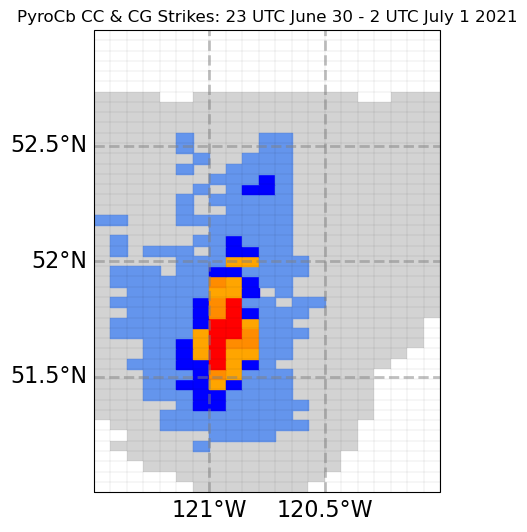

In [50]:


fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_pyrocb, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_pyrocb, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_pyrocb)


# Make figure larger
plt.xlim([-121.5, -120])
plt.ylim([51, 53])

latlines = np.unique(pyrocb_grid_corners_df["max_lat"])
lonlines = np.unique(pyrocb_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -121.5,  -121,  -120.5])
gl.ylocator = mticker.FixedLocator([ 51.5, 52, 52.5, 53, 53.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("PyroCb CC & CG Strikes: 23 UTC June 30 - 2 UTC July 1 2021")

plt.show()

## CC:CG density 

In [51]:
# polygons for lightning density 
bt_min_lat = np.min(bt_pyrocb.min_lat)
bt_max_lat = np.max(bt_pyrocb.max_lat)
bt_min_lon = np.min(bt_pyrocb.min_lon)
bt_max_lon = np.max(bt_pyrocb.max_lon)

grid_pyrocb_split_cloud
grid_pyrocb_split_ground

grid_select = grid_pyrocb_split_cloud.loc[(grid_pyrocb_split_cloud.min_lat >= bt_min_lat) & (grid_pyrocb_split_cloud.max_lat <= bt_max_lat) &
                              (grid_pyrocb_split_cloud.min_lon >= bt_min_lon) & (grid_pyrocb_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_cloud = []
color_lt_pyrocb_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_pyrocb_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_pyrocb_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_pyrocb_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_pyrocb_cloud.append("darkorange")
    if (x > 140): 
        color_lt_pyrocb_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_pyrocb_split_ground.loc[(grid_pyrocb_split_ground.min_lat >= bt_min_lat) & (grid_pyrocb_split_ground.max_lat <= bt_max_lat) &
                              (grid_pyrocb_split_ground.min_lon >= bt_min_lon) & (grid_pyrocb_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_ground = []
color_lt_pyrocb_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_pyrocb_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_pyrocb_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_pyrocb_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_pyrocb_ground.append("darkorange")
    if (x > 140): 
        color_lt_pyrocb_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_pyrocb_split_cccg.loc[(grid_pyrocb_split_cccg.min_lat >= bt_min_lat) & (grid_pyrocb_split_cccg.max_lat <= bt_max_lat) &
                              (grid_pyrocb_split_cccg.min_lon >= bt_min_lon) & (grid_pyrocb_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_cccg = []
color_lt_pyrocb_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_pyrocb_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_pyrocb_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_pyrocb_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_pyrocb_cccg.append("darkorange")
    if (x > 12): 
        color_lt_pyrocb_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_pyrocb_percpos.loc[(grid_pyrocb_percpos.min_lat >= bt_min_lat) & (grid_pyrocb_percpos.max_lat <= bt_max_lat) &
                              (grid_pyrocb_percpos.min_lon >= bt_min_lon) & (grid_pyrocb_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_pyrocb_percpos = []
color_lt_pyrocb_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_pyrocb_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_pyrocb_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_pyrocb_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_pyrocb_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_pyrocb_percpos.append("darkorange")
    if (x > 50): 
        color_lt_pyrocb_percpos.append("red")

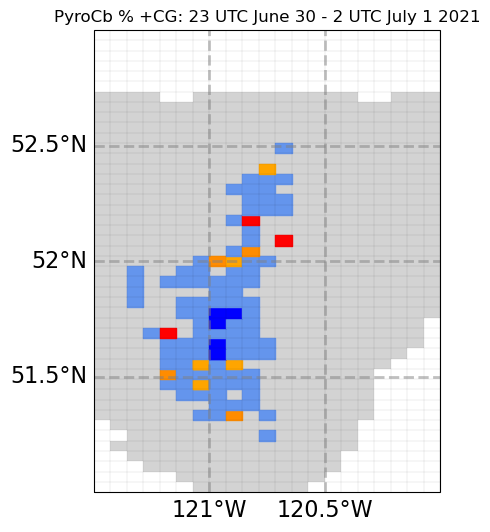

In [52]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_pyrocb, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_pyrocb_percpos, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_pyrocb_percpos)


# Make figure larger
plt.xlim([-121.5, -120])
plt.ylim([51, 53])

latlines = np.unique(pyrocb_grid_corners_df["max_lat"])
lonlines = np.unique(pyrocb_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)



gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -121.5,  -121,  -120.5])
gl.ylocator = mticker.FixedLocator([ 51.5, 52, 52.5, 53, 53.5])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("PyroCb % +CG: 23 UTC June 30 - 2 UTC July 1 2021")

plt.show()

## process data

In [53]:
hours = [23, 0, 1, 2]

pyrocb_cloud_density_array = []
pyrocb_ground_density_array = []
pyrocb_total_density_array = []

pyrocb_cloud_log_density_array = []
pyrocb_ground_log_density_array = []
pyrocb_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_pyrocb_split = grid_pyrocb_split_conc.loc[(grid_pyrocb_split_conc.hour == hours[i])]
        strikes_pyrocb = grid_pyrocb_conc.loc[(grid_pyrocb_conc.hour == hours[i])]

        cloud_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_pyrocb["bt_area_km2"])
        
        pyrocb_cloud_density = list(cloud_count/area * 10000)
        pyrocb_cloud_density = np.nan_to_num(pyrocb_cloud_density)
        pyrocb_cloud_density_array.append(pyrocb_cloud_density)
        cloud_log = np.log(pyrocb_cloud_density + 0.019853087155052608)
        pyrocb_cloud_log_density_array.append(cloud_log)
        
        
        pyrocb_ground_density = list(ground_count/area * 10000)
        pyrocb_ground_density = np.nan_to_num(pyrocb_ground_density)
        pyrocb_ground_density_array.append(pyrocb_ground_density)  
        ground_log = np.log(pyrocb_ground_density + 0.019853087155052608)
        pyrocb_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_pyrocb["lt_count"]
        
        pyrocb_total_density = list(total_count/area * 10000)
        pyrocb_total_density = np.nan_to_num(pyrocb_total_density)
        pyrocb_total_density_array.append(pyrocb_total_density)
        total_log = np.log(pyrocb_total_density + 0.019853087155052608)
        pyrocb_total_log_density_array.append(total_log)
        
        
pyrocb_cloud_density_flat = [item for sublist in pyrocb_cloud_density_array for item in sublist]
pyrocb_ground_density_flat = [item for sublist in pyrocb_ground_density_array for item in sublist]
pyrocb_total_density_flat = [item for sublist in pyrocb_total_density_array for item in sublist]



In [54]:
pyrocb_cloud_halfmin = []
for i in range(0, 4): 
    if len([x for x in pyrocb_cloud_density_array[i] if x != 0]) > 0: 
        pyrocb_cloud_halfmin.append(np.min([x for x in pyrocb_cloud_density_array[i] if x != 0]) / 2)

pyrocb_ground_halfmin = []
for i in range(0, 4): 
    if len([x for x in pyrocb_ground_density_array[i] if x != 0]) > 0: 
        pyrocb_ground_halfmin.append(np.min([x for x in pyrocb_ground_density_array[i] if x != 0]) / 2)

pyrocb_total_halfmin = []
for i in range(0, 4): 
    if len([x for x in pyrocb_total_density_array[i] if x != 0]) > 0: 
        pyrocb_total_halfmin.append(np.min([x for x in pyrocb_total_density_array[i] if x != 0]) / 2)

pyrocb_cloud_totmin = np.min(pyrocb_cloud_halfmin)
pyrocb_ground_totmin = np.min(pyrocb_ground_halfmin)
pyrocb_total_totmin = np.min(pyrocb_total_halfmin)

pyrocb_cloud_totmin, pyrocb_ground_totmin, pyrocb_total_totmin

(0.019853087155052608, 0.019853087155052608, 0.019853087155052608)

### boxplot

In [55]:
pyrocb_cloud_max = []
for i in range(0, 4): 
    pyrocb_cloud_max.append(np.max(pyrocb_cloud_log_density_array[i]))

pyrocb_ground_max = []
for j in range(0, 4): 
    pyrocb_ground_max.append(np.max(pyrocb_ground_log_density_array[j]))

pyrocb_ground_max

[-0.3941906772264935,
 0.15942557171855415,
 0.3684504433568854,
 -1.5215004869591886]

[Text(0, 0, '23:00\n06/30'),
 Text(2, 0, '00:00\n07/01'),
 Text(4, 0, '01:00'),
 Text(6, 0, '02:00'),
 Text(1, 0, ''),
 Text(3, 0, ''),
 Text(5, 0, ''),
 Text(7, 0, '')]

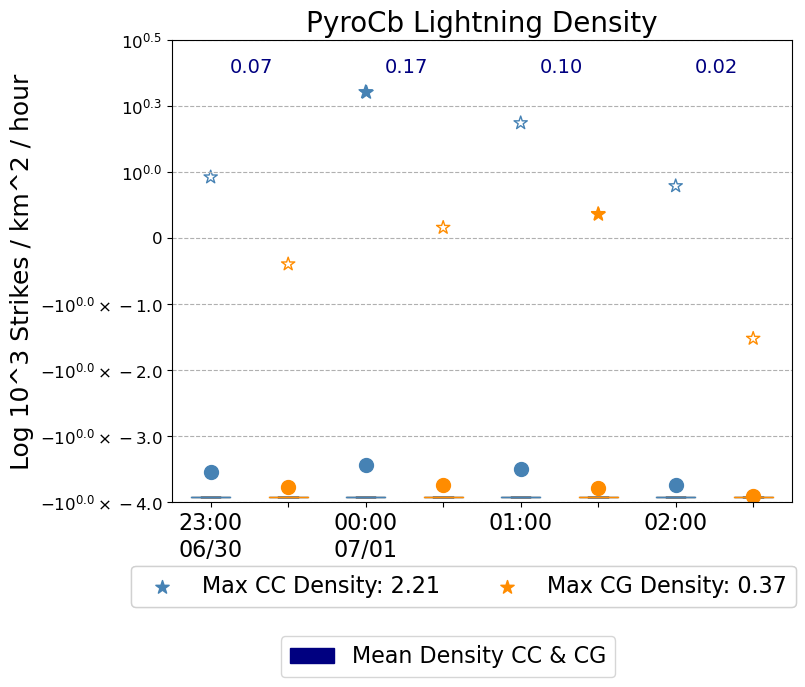

In [56]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


#ax = plt.subplot2grid(shape = (3,4), loc = (0,0), colspan=2)
ax.set_title('PyroCb Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-4, 3)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(pyrocb_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6]) 


box4_2 = ax.boxplot(pyrocb_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7]) 

ax.scatter(np.arange(0, 8, 2), pyrocb_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(2, pyrocb_cloud_max[1], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(pyrocb_cloud_max))) 

ax.scatter(np.arange(1, 9, 2), pyrocb_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(5, pyrocb_ground_max[2], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(pyrocb_ground_max))) 

x = np.arange(0.25, 7.25, 2)
for i in range(0, 4, 1):
    ax.annotate("{:.2f}".format(np.mean(pyrocb_total_density_array[i])), (x[i], 2.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["23:00  06/30", "00:00 07/01", "01:00","02:00", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 minute analysis

### max denisty per 10 minute intervals

#### bt per 10 mins

In [57]:
## group the bt data to get area each 10 minutes
grouped_pyrocb_int_bt = bt_pyrocb.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_pyrocb_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
# grouped_pyrocb_int_bt["bt_area_km2"] = grouped_pyrocb_int_bt["bt_area_km2"] * 25
grouped_pyrocb_int_bt["bt_area_km2"] = 25
grid_pyrocb_int_bt = grouped_pyrocb_int_bt

grid_pyrocb_int_bt

min_lat    max_lat     min_lon  max_lon  hour  minute  bt_area_km2
0      51.000000  51.044444 -121.071429   -121.0     2      15           25
1      51.000000  51.044444 -121.071429   -121.0     2      25           25
2      51.000000  51.044444 -121.071429   -121.0     2      35           25
3      51.000000  51.044444 -121.071429   -121.0     2      45           25
4      51.000000  51.044444 -121.071429   -121.0     2      55           25
...          ...        ...         ...      ...   ...     ...          ...
14665  52.688889  52.733333 -120.071429   -120.0     2      15           25
14666  52.688889  52.733333 -120.071429   -120.0     2      25           25
14667  52.688889  52.733333 -120.071429   -120.0     2      35           25
14668  52.688889  52.733333 -120.071429   -120.0     2      45           25
14669  52.688889  52.733333 -120.071429   -120.0     2      55           25

[14670 rows x 7 columns]

#### process data

In [58]:
"""hours = [23, 0, 1, 2]
mins = range(0, 60, 10)

grid_pyrocb_int_conc  = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        time_bt = grid_pyrocb_int_bt.loc[(grid_pyrocb_int_bt.hour == hours[i]) & (grid_pyrocb_int_bt.minute >= mins[j]) & (grid_pyrocb_int_bt.minute <= mins[j] + 9)]
        time_lt = grid_pyrocb_int.loc[(grid_pyrocb_int.hour == hours[i]) & (grid_pyrocb_int.minute >= mins[j]) & (grid_pyrocb_int.minute <= mins[j] + 9)]
        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']], on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')

        if len(grid_pyrocb_int_conc) == 0: 
            grid_pyrocb_int_conc = time_df
        else: 
            grid_pyrocb_int_conc = pd.concat([grid_pyrocb_int_conc, time_df], axis =0)


grid_pyrocb_int_conc['lt_count'] = np.nan_to_num(grid_pyrocb_int_conc.lt_count)

# ------------------------------------------

pyrocb_int_cloud_density_array = []
pyrocb_int_ground_density_array = []
pyrocb_total_density_array = []

pyrocb_int_cloud_max = []
pyrocb_int_ground_max = []

pyrocb_int_cloud_log_density_array = []
pyrocb_int_ground_log_density_array = []
pyrocb_total_log_density_array = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        
        strikes_pyrocb_int = grid_pyrocb_int_conc.loc[(grid_pyrocb_int_conc.hour == hours[i]) 
                                                      & (grid_pyrocb_int_conc.minute >= mins[j])
                                                      & (grid_pyrocb_int_conc.minute <= mins[j] + 9)]        
        cloud_count = strikes_pyrocb_int[(strikes_pyrocb_int["C or G"] != "G")]["lt_count"]
        ground_count = strikes_pyrocb_int[(strikes_pyrocb_int["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_pyrocb["bt_area_km2"])
        
        pyrocb_int_cloud_density = list(cloud_count/area * 10000)
        pyrocb_int_cloud_density = np.nan_to_num(pyrocb_int_cloud_density)
        pyrocb_int_cloud_density_array.append(pyrocb_int_cloud_density)
        pyrocb_int_cloud_max.append(np.max(pyrocb_int_cloud_density))

        pyrocb_int_ground_density = list(ground_count/area * 10000)
        pyrocb_int_ground_density = np.nan_to_num(pyrocb_int_ground_density)
        pyrocb_int_ground_density_array.append(pyrocb_int_ground_density)  
        pyrocb_int_ground_max.append(np.max(pyrocb_int_ground_density))

"""

'hours = [23, 0, 1, 2]\nmins = range(0, 60, 10)\n\ngrid_pyrocb_int_conc  = []\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        time_bt = grid_pyrocb_int_bt.loc[(grid_pyrocb_int_bt.hour == hours[i]) & (grid_pyrocb_int_bt.minute >= mins[j]) & (grid_pyrocb_int_bt.minute <= mins[j] + 9)]\n        time_lt = grid_pyrocb_int.loc[(grid_pyrocb_int.hour == hours[i]) & (grid_pyrocb_int.minute >= mins[j]) & (grid_pyrocb_int.minute <= mins[j] + 9)]\n        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", \'min_lat\', \'max_lat\', \'min_lon\', \'max_lon\']], on=["hour", \'min_lat\', \'max_lat\', \'min_lon\', \'max_lon\'], how=\'left\')\n\n        if len(grid_pyrocb_int_conc) == 0: \n            grid_pyrocb_int_conc = time_df\n        else: \n            grid_pyrocb_int_conc = pd.concat([grid_pyrocb_int_conc, time_df], axis =0)\n\n\ngrid_pyrocb_int_conc[\'lt_count\'] = np.nan_to_num(grid_pyrocb_int_conc.lt_count)\n\n# ---------------------------------------

## 10 minute intervals

In [59]:
# grid_pyrocb_int = pd.read_csv("/data2/edworak/data/pyrocb_lightning_bt.csv", sep='\t')

hours1 = [23, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

pyrocb_cloud_density_array = []
pyrocb_ground_density_array = []
pyrocb_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_pyrocb_split = grid_pyrocb_int_split.loc[(grid_pyrocb_int_split.hour == hours1[i]) & (grid_pyrocb_int_split.minute >= mins1[j]) & (grid_pyrocb_int_split.minute <= mins1[j] + 9)]        
        strikes_pyrocb = grid_pyrocb_int.loc[(grid_pyrocb_int.hour == hours1[i]) & (grid_pyrocb_int.minute >= mins1[j]) & (grid_pyrocb_int.minute <= mins1[j] + 9)]        
        bt_pyrocb = grid_pyrocb_int_bt.loc[(grid_pyrocb_int_bt.hour == hours1[i]) & (grid_pyrocb_int_bt.minute >= mins1[j]) & (grid_pyrocb_int_bt.minute <= mins1[j] + 9)]        
        # ----------------
        
        if len(strikes_pyrocb_split) >= 1: 
            #pyrocb_cloud_array.append(np.array(strikes_pyrocb[(strikes_pyrocb["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_pyrocb_split[(strikes_pyrocb_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_pyrocb["bt_area_km2"])

            pyrocb_cloud_density = list(cloud_count/area * 10000)
            pyrocb_cloud_density = np.nan_to_num(pyrocb_cloud_density)
            pyrocb_cloud_density_array.append(np.array(pyrocb_cloud_density))

            pyrocb_ground_density = list(ground_count/area * 10000)
            pyrocb_ground_density = np.nan_to_num(pyrocb_ground_density)
            pyrocb_ground_density_array.append(np.array(pyrocb_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_pyrocb["lt_count"]

            pyrocb_total_density = list(total_count/area * 10000)
            pyrocb_total_density = np.nan_to_num(pyrocb_total_density)
            pyrocb_total_density_array.append(np.array(pyrocb_total_density))

pyrocb_cloud_density_array =  pyrocb_cloud_density_array[:24]
pyrocb_ground_density_array =  pyrocb_ground_density_array[:24]
pyrocb_total_density_array =  pyrocb_total_density_array[:24]

pyrocb_cloud_density_flat = [item for sublist in pyrocb_cloud_density_array for item in sublist]
pyrocb_ground_density_flat = [item for sublist in pyrocb_ground_density_array for item in sublist]
pyrocb_total_density_flat = [item for sublist in pyrocb_total_density_array for item in sublist]

np.mean(pyrocb_total_density_flat)


1.556677410440043

In [60]:
a = grid_pyrocb_int_split[(grid_pyrocb_int_split["C or G"] != "G")]["lt_count"]
print(np.unique(a))

b = grid_pyrocb_int_split[(grid_pyrocb_int_split["C or G"] != "C")]["lt_count"]
print(np.unique(b))

c = grid_pyrocb_int["lt_count"] 
print(np.unique(c))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 30]
[ 1  2  3  4  5  6  7  8 11]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18. 19.
 20. 21. 23. 30.]


# Smoke : 8 - 11 UTC June 29 2021
- lon: -120 : -114 
- lat: 58 : 60.5

## gridding

###  parallax corrected lightning and BT 

In [61]:
correct_smoke = pd.read_csv("/data2/edworak/data/smoke_plxcorrected_bt_lightning.nc", usecols = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17])
correct_smoke = correct_smoke.sort_values('distance(km)', ascending=True)
correct_smoke = correct_smoke.drop_duplicates(subset=['day', 'hour', 'minute', 'lat', 'lon', 'peak-current',
                   'C or G', 'polarity', "CMI_C14"], keep='first') 
correct_smoke = correct_smoke.sort_index()

correct_smoke["lt_count"] = np.zeros((35236))
correct_smoke = correct_smoke.reset_index()
np.unique(correct_smoke.hour)

array([ 8,  9, 10, 11])

### 5 km grid

In [62]:
lat_vals = range(58, 65)
lon_vals = range(-120, -113)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]
ds_out = pd.DataFrame(
     {"lat": (["lat"], ds_out_lat),
     "lon": (["lon"], ds_out_lon)})

ds_out = pd.DataFrame([ds_out_lon_flat, ds_out_lat_flat]).T
grid_5km = ds_out.set_axis(['lon', 'lat'], axis=1)


### grid corners

In [63]:
# Define the latitude and longitude values for your smoke_grid (assuming evenly spaced)
latitude_values = np.linspace(58, 64, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-120, -114, num=len(ds_out_lon_flat)) 

# Calculate the smoke_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store smoke_grid corners
smoke_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the smoke_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the smoke_grid cell's corners to the list
        smoke_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The smoke_grid_corners list now contains the corner coordinates of each smoke_grid cell
# Each element of the list is a list of four tuples representing the corners
smoke_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
smoke_grid_corners_df = smoke_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
smoke_grid_corners_df = smoke_grid_corners_df.drop_duplicates(keep='first') 
smoke_grid_corners_df

min_lat    max_lat     min_lon     max_lon
0     58.000000  58.043796 -120.000000 -119.911765
1     58.000000  58.043796 -119.911765 -119.823529
2     58.000000  58.043796 -119.823529 -119.735294
3     58.000000  58.043796 -119.735294 -119.647059
4     58.000000  58.043796 -119.647059 -119.558824
...         ...        ...         ...         ...
9311  63.956204  64.000000 -114.441176 -114.352941
9312  63.956204  64.000000 -114.352941 -114.264706
9313  63.956204  64.000000 -114.264706 -114.176471
9314  63.956204  64.000000 -114.176471 -114.088235
9315  63.956204  64.000000 -114.088235 -114.000000

[9316 rows x 4 columns]

### grid lightning

In [64]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_smoke)): 
    # print(i)
    findlat = correct_smoke.lat[i]
    findlon = correct_smoke.lon[i]

    findcorners = smoke_grid_corners_df.loc[(smoke_grid_corners_df.min_lat <= findlat) & (smoke_grid_corners_df.max_lat >= findlat) & 
                                     (smoke_grid_corners_df.min_lon <= findlon) & (smoke_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_smoke["min_lat"] = min_lat_array
correct_smoke["max_lat"] = max_lat_array
correct_smoke["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_smoke["min_lon"] = min_lon_array
correct_smoke["max_lon"] = max_lon_array
correct_smoke["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_smoke


index  year  month  day  hour  minute     lat      lon  peak-current  \
0            4  2021      6   29     8      30  58.627 -118.194           9.2   
1           45  2021      6   29     8      30  58.579 -118.444           4.4   
2           61  2021      6   29     8      30  58.614 -118.481           4.9   
3           75  2021      6   29     8      30  58.549 -118.341           5.8   
4          109  2021      6   29     8      30  58.535 -118.365           3.3   
...        ...   ...    ...  ...   ...     ...     ...      ...           ...   
35231  1327654  2021      6   29    11      44  58.876 -117.757         -52.5   
35232  1327687  2021      6   29    11      44  58.876 -117.757          -8.7   
35233  1327720  2021      6   29    11      44  58.877 -117.754         -19.7   
35234  1327750  2021      6   29    11      44  58.374 -115.321           7.0   
35235  1327796  2021      6   29    11      44  58.384 -115.248           4.3   

      C or G  ...       tlat        tlon  distance(km)  lt_count    min_lat  \
0          G  ...  58.627953 -118.199786         0.645       0.0  58.613139   
1          C  ...  58.564999 -118.485836         4.711       0.0  58.569343   
2          C  ...  58.608120 -118.447966         3.686       0.0  58.613139   
3          C  ...  58.549244 -118.345186         0.466       0.0  58.525547   
4          C  ...  58.549244 -118.345186         2.328       0.0  58.525547   
...      ...  ...        ...         ...           ...       ...        ...   
35231      G  ...  58.866059 -117.770269         1.563       0.0  58.875912   
35232      G  ...  58.866059 -117.770269         1.563       0.0  58.875912   
35233      G  ...  58.866059 -117.770269         1.896       0.0  58.875912   
35234      C  ...  58.365315 -115.337302         1.859       0.0  58.350365   
35235      C  ...  58.392134 -115.247598         0.388       0.0  58.350365   

         max_lat   cent_lat     min_lon     max_lon    cent_lon  
0      58.656934  58.635036 -118.235294 -118.147059 -118.191176  
1      58.613139  58.591241 -118.500000 -118.411765 -118.455882  
2      58.656934  58.635036 -118.500000 -118.411765 -118.455882  
3      58.569343  58.547445 -118.411765 -118.323529 -118.367647  
4      58.569343  58.547445 -118.411765 -118.323529 -118.367647  
...          ...        ...         ...         ...         ...  
35231  58.919708  58.897810 -117.794118 -117.705882 -117.750000  
35232  58.919708  58.897810 -117.794118 -117.705882 -117.750000  
35233  58.919708  58.897810 -117.794118 -117.705882 -117.750000  
35234  58.394161  58.372263 -115.323529 -115.235294 -115.279412  
35235  58.394161  58.372263 -115.323529 -115.235294 -115.279412  

[35236 rows x 22 columns]

In [65]:
## seperate into C or G for count 

smoke_grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()
smoke_grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_smoke_split = pd.concat([smoke_grouped_lt, smoke_grouped_bt], axis=1)
grid_smoke_split = grid_smoke_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_smoke_split = grid_smoke_split.T.drop_duplicates().T
grid_smoke_split.lt_count = pd.to_numeric(grid_smoke_split.lt_count)


# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_smoke_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_split_all = grid_smoke_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_smoke_split_all = grid_smoke_split_all.T.drop_duplicates().T
grid_smoke_split_all.lt_count = pd.to_numeric(grid_smoke_split_all.lt_count)
grid_smoke_split_cloud = grid_smoke_split_all.loc[grid_smoke_split_all["C or G"] == "C"]
grid_smoke_split_ground = grid_smoke_split_all.loc[grid_smoke_split_all["C or G"] == "G"]


grid_smoke_split_cccg = pd.merge(grid_smoke_split_cloud, grid_smoke_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_smoke_split_cccg.loc[(grid_smoke_split_cccg.lt_count_y >= 0)]
grid_smoke_split_cccg["CC:CG"] = grid_smoke_split_cccg.lt_count_x / grid_smoke_split_cccg.lt_count_y
grid_smoke_split_cccg = grid_smoke_split_cccg.loc[grid_smoke_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_smoke_ground = correct_smoke.loc[correct_smoke["C or G"] != "C"]
grouped_lt = correct_smoke_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak-current', 'polarity'])["lt_count"].count().reset_index()
grouped_bt = correct_smoke_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak-current', 'polarity'])['CMI_C14'].min().reset_index()

grid_smoke_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_percpos = grid_smoke_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak-current', 'polarity', 'CMI_C14','lt_count']]
grid_smoke_percpos = grid_smoke_percpos.T.drop_duplicates().T
grid_smoke_percpos.lt_count = pd.to_numeric(grid_smoke_percpos.lt_count)
grid_smoke_percpos_pos = grid_smoke_percpos.loc[grid_smoke_percpos["polarity"] == "+"]

grid_smoke_percpos = pd.merge(grid_smoke_split_ground, grid_smoke_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'polarity', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_smoke_percpos.lt_count_y = np.nan_to_num(grid_smoke_percpos.lt_count_y)
grid_smoke_percpos["perc_pos"] = (grid_smoke_percpos.lt_count_y / grid_smoke_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

smoke_grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
smoke_grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_smoke = pd.concat([smoke_grouped_lt, smoke_grouped_bt], axis=1)
grid_smoke = grid_smoke[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_smoke = grid_smoke.T.drop_duplicates().T
grid_smoke.lt_count = pd.to_numeric(grid_smoke.lt_count)

grid_smoke

# --------------------------------------------------------------

## count for all hours 

smoke_grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
smoke_grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_smoke_all = pd.concat([smoke_grouped_lt, smoke_grouped_bt], axis=1)
grid_smoke_all = grid_smoke_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_smoke_all = grid_smoke_all.T.drop_duplicates().T
grid_smoke_all.lt_count = pd.to_numeric(grid_smoke_all.lt_count)

grid_smoke_all

# --------------------------------------------------------------

min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  \
0     58.218978  58.262774  58.240876 -117.000000 -116.911765 -116.955882   
1     58.218978  58.262774  58.240876 -116.911765 -116.823529 -116.867647   
2     58.218978  58.262774  58.240876 -116.823529 -116.735294 -116.779412   
3     58.218978  58.262774  58.240876 -116.735294 -116.647059 -116.691176   
4     58.218978  58.262774  58.240876 -116.647059 -116.558824 -116.602941   
...         ...        ...        ...         ...         ...         ...   
1101  59.970803  60.014599  59.992701 -119.205882 -119.117647 -119.161765   
1102  59.970803  60.014599  59.992701 -118.852941 -118.764706 -118.808824   
1103  59.970803  60.014599  59.992701 -118.764706 -118.676471 -118.720588   
1104  59.970803  60.014599  59.992701 -118.676471 -118.588235 -118.632353   
1105  59.970803  60.014599  59.992701 -118.588235 -118.500000 -118.544118   

        CMI_C14  lt_count  
0    -53.607605       2.0  
1    -53.068940       2.0  
2    -52.290880       1.0  
3    -51.931778       1.0  
4    -53.607605       1.0  
...         ...       ...  
1101 -52.350740       5.0  
1102 -53.607605       1.0  
1103 -54.445510       2.0  
1104 -53.906860       1.0  
1105 -53.667450       1.0  

[1106 rows x 8 columns]

In [66]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_smoke_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_int_split = grid_smoke_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_smoke_int_split = grid_smoke_int_split.T.drop_duplicates().T
grid_smoke_int_split.lt_count = pd.to_numeric(grid_smoke_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_smoke.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_smoke_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_smoke_int = grid_smoke_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_smoke_int = grid_smoke_int.T.drop_duplicates().T
grid_smoke_int.lt_count = pd.to_numeric(grid_smoke_int.lt_count)

grid_smoke_int_split
grid_smoke_int_split

hour minute    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0        9     51  58.218978  58.262774  58.240876      -117.0 -116.911765   
1       10     21  58.218978  58.262774  58.240876      -117.0 -116.911765   
2        9     42  58.218978  58.262774  58.240876 -116.911765 -116.823529   
3        9     51  58.218978  58.262774  58.240876 -116.823529 -116.735294   
4        9     36  58.218978  58.262774  58.240876 -116.735294 -116.647059   
...    ...    ...        ...        ...        ...         ...         ...   
13574   11      2  59.970803  60.014599  59.992701 -118.852941 -118.764706   
13575   11      5  59.970803  60.014599  59.992701 -118.764706 -118.676471   
13576   11     18  59.970803  60.014599  59.992701 -118.764706 -118.676471   
13577   11     23  59.970803  60.014599  59.992701 -118.676471 -118.588235   
13578   11     26  59.970803  60.014599  59.992701 -118.588235      -118.5   

         cent_lon C or G    CMI_C14  lt_count  
0     -116.955882      C -53.607605         1  
1     -116.955882      C -53.128784         1  
2     -116.867647      C  -53.06894         2  
3     -116.779412      C  -52.29088         1  
4     -116.691176      C -51.931778         1  
...           ...    ...        ...       ...  
13574 -118.808824      C -53.607605         1  
13575 -118.720588      C -53.607605         1  
13576 -118.720588      C  -54.44551         1  
13577 -118.632353      C  -53.90686         1  
13578 -118.544118      C  -53.66745         1  

[13579 rows x 11 columns]

### grid BT 

In [67]:
bt_smoke = pd.read_csv('/data2/edworak/data/parallax_bt_sdensity_smoke', usecols = [1, 2, 3, 4, 5, 6, 7, 8])

bt_smoke = bt_smoke.loc[(bt_smoke.CMI_C14 <= -50) 
                          & (bt_smoke.tlat >= 58) & (bt_smoke.tlat <= 60.5)
                          & (bt_smoke.tlon >= -120) & (bt_smoke.tlon <= -114)]
bt_smoke = bt_smoke.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_smoke)): 
    findlat = bt_smoke.tlat[i]
    findlon = bt_smoke.tlon[i]

    findcorners = smoke_grid_corners_df.loc[(smoke_grid_corners_df.min_lat <= findlat) & (smoke_grid_corners_df.max_lat >= findlat) & 
                                     (smoke_grid_corners_df.min_lon <= findlon) & (smoke_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_smoke["min_lat"] = min_lat_array_flat
bt_smoke["max_lat"] = max_lat_array_flat
bt_smoke["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_smoke["min_lon"] = min_lon_array_flat
bt_smoke["max_lon"] = max_lon_array_flat
bt_smoke["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_smoke


index  year  month  day  hour  minute       tlat        tlon  \
0       1866  2021      6   29    11      25  58.023211 -114.763083   
1       1882  2021      6   29    11      25  58.016428 -114.700998   
2       1976  2021      6   29    11      25  58.029085 -114.823568   
3       1978  2021      6   29    11      35  58.030281 -114.822493   
4       2113  2021      6   29    11      35  58.036881 -114.884399   
...      ...   ...    ...  ...   ...     ...        ...         ...   
31405  58104  2021      6   29    11      15  60.102197 -119.994050   
31406  58105  2021      6   29    11      25  60.104633 -119.991914   
31407  58106  2021      6   29     9      45  60.101644 -119.994534   
31408  58108  2021      6   29    11      35  60.105828 -119.990868   
31409  58109  2021      6   29    10      45  60.105590 -119.991077   

         CMI_C14    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0     -50.794617  58.000000  58.043796  58.021898 -114.794118 -114.705882   
1     -50.435516  58.000000  58.043796  58.021898 -114.705882 -114.617647   
2     -50.974167  58.000000  58.043796  58.021898 -114.882353 -114.794118   
3     -50.435516  58.000000  58.043796  58.021898 -114.882353 -114.794118   
4     -50.555206  58.000000  58.043796  58.021898 -114.970588 -114.882353   
...          ...        ...        ...        ...         ...         ...   
31405 -54.565216  60.102190  60.145985  60.124088 -120.000000 -119.911765   
31406 -55.403122  60.102190  60.145985  60.124088 -120.000000 -119.911765   
31407 -50.435516  60.058394  60.102190  60.080292 -120.000000 -119.911765   
31408 -53.727295  60.102190  60.145985  60.124088 -120.000000 -119.911765   
31409 -54.325806  60.102190  60.145985  60.124088 -120.000000 -119.911765   

         cent_lon  
0     -114.750000  
1     -114.661765  
2     -114.838235  
3     -114.838235  
4     -114.926471  
...           ...  
31405 -119.955882  
31406 -119.955882  
31407 -119.955882  
31408 -119.955882  
31409 -119.955882  

[31410 rows x 15 columns]

In [68]:
## group the bt data to get area at each hour
grouped_smoke_bt = bt_smoke.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_smoke_bt = grouped_smoke_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_smoke_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_smoke_bt["bt_area_km2"] = grouped_smoke_bt["bt_area_km2"] * 25
grid_smoke_bt = grouped_smoke_bt

grid_smoke_bt


min_lat    max_lat     min_lon     max_lon  hour  bt_area_km2
0     58.000000  58.043796 -119.205882 -119.117647     8           25
1     58.000000  58.043796 -119.117647 -119.029412     8           25
2     58.000000  58.043796 -119.029412 -118.941176     8           25
3     58.000000  58.043796 -118.941176 -118.852941     8           25
4     58.000000  58.043796 -118.852941 -118.764706     8           25
...         ...        ...         ...         ...   ...          ...
8169  60.145985  60.189781 -117.000000 -116.911765    11           25
8170  60.145985  60.189781 -116.911765 -116.823529    11           25
8171  60.145985  60.189781 -116.647059 -116.558824    11           25
8172  60.145985  60.189781 -116.558824 -116.470588    11           25
8173  60.145985  60.189781 -116.470588 -116.382353    11           25

[8174 rows x 6 columns]

In [69]:
grouped_smoke_int_bt = bt_smoke.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_smoke_int_bt = grouped_smoke_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_smoke_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_smoke_int_bt["bt_area_km2"] = 25
grid_smoke_int_bt = grouped_smoke_int_bt

grid_smoke_int_bt

min_lat    max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0      58.000000  58.043796 -119.205882 -119.117647     8      35           25
1      58.000000  58.043796 -119.117647 -119.029412     8      35           25
2      58.000000  58.043796 -119.029412 -118.941176     8      35           25
3      58.000000  58.043796 -118.941176 -118.852941     8      35           25
4      58.000000  58.043796 -118.852941 -118.764706     8      35           25
...          ...        ...         ...         ...   ...     ...          ...
25826  60.145985  60.189781 -116.911765 -116.823529    11      25           25
25827  60.145985  60.189781 -116.911765 -116.823529    11      35           25
25828  60.145985  60.189781 -116.647059 -116.558824    11      35           25
25829  60.145985  60.189781 -116.558824 -116.470588    11      35           25
25830  60.145985  60.189781 -116.470588 -116.382353    11      35           25

[25831 rows x 7 columns]

### combine datasets

In [70]:
grid_smoke_conc = pd.merge(grid_smoke_bt, grid_smoke[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_smoke_conc['lt_count'] = np.nan_to_num(grid_smoke_conc.lt_count)

grid_smoke_split_conc = pd.merge(grid_smoke_bt, grid_smoke_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_smoke_split_conc['lt_count'] = np.nan_to_num(grid_smoke_split_conc.lt_count)
np.unique(grid_smoke_conc.hour)

array([ 8,  9, 10, 11])

### process data

In [71]:
hours = [8, 9, 10, 11]


smoke_cloud_density_array = []
smoke_ground_density_array = []
smoke_total_density_array = []

smoke_cloud_log_density_array = []
smoke_ground_log_density_array = []
smoke_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_smoke_split = grid_smoke_split_conc.loc[(grid_smoke_split_conc.hour == hours[i])]
        strikes_smoke = grid_smoke_conc.loc[(grid_smoke_conc.hour == hours[i])]

        cloud_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_smoke["bt_area_km2"])
        
        smoke_cloud_density = list(cloud_count/area * 10000)
        smoke_cloud_density = np.nan_to_num(smoke_cloud_density)
        smoke_cloud_density_array.append(smoke_cloud_density)
        cloud_log = np.log(smoke_cloud_density + 0.07407407407407407)
        smoke_cloud_log_density_array.append(cloud_log)

        smoke_ground_density = list(ground_count/area * 10000)
        smoke_ground_density = np.nan_to_num(smoke_ground_density)
        smoke_ground_density_array.append(smoke_ground_density)  
        ground_log = np.log(smoke_ground_density + 0.07407407407407407)
        smoke_ground_log_density_array.append(ground_log)

        # --------------- 
        # total strikes 
        
        total_count = strikes_smoke["lt_count"]
        
        smoke_total_density = list(total_count/area * 10000)
        smoke_total_density = np.nan_to_num(smoke_total_density)
        smoke_total_density_array.append(smoke_total_density)
        total_log = np.log(smoke_total_density + 0.07407407407407407)
        smoke_total_log_density_array.append(total_log)

smoke_cloud_density_flat = [item for sublist in smoke_cloud_density_array for item in sublist]
smoke_ground_density_flat = [item for sublist in smoke_ground_density_array for item in sublist]
smoke_total_density_flat = [item for sublist in smoke_total_density_array for item in sublist]




In [72]:
smoke_cloud_halfmin = []
for i in range(0, 4): 
    if len([x for x in smoke_cloud_density_array[i] if x != 0]) > 0: 
        smoke_cloud_halfmin.append(np.min([x for x in smoke_cloud_density_array[i] if x != 0]) / 2)

smoke_ground_halfmin = []
for i in range(0, 4): 
    if len([x for x in smoke_ground_density_array[i] if x != 0]) > 0: 
        smoke_ground_halfmin.append(np.min([x for x in smoke_ground_density_array[i] if x != 0]) / 2)

smoke_total_halfmin = []
for i in range(0, 4): 
    if len([x for x in smoke_total_density_array[i] if x != 0]) > 0: 
        smoke_total_halfmin.append(np.min([x for x in smoke_total_density_array[i] if x != 0]) / 2)

smoke_cloud_totmin = np.min(smoke_cloud_halfmin)
smoke_ground_totmin = np.min(smoke_ground_halfmin)
smoke_total_totmin = np.min(smoke_total_halfmin)

smoke_cloud_totmin, smoke_ground_totmin, smoke_total_totmin

(0.07407407407407407, 0.07407407407407407, 0.07407407407407407)

## map

In [73]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_smoke_select = grid_smoke_bt

patches_bt_smoke = []

for i in range(len(bt_smoke_select)):
    y = np.array([[bt_smoke_select.min_lon[i], bt_smoke_select.min_lat[i]], [bt_smoke_select.max_lon[i], bt_smoke_select.min_lat[i]], 
                  [bt_smoke_select.max_lon[i], bt_smoke_select.max_lat[i]], [bt_smoke_select.min_lon[i], bt_smoke_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_smoke.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
bt_min_lat = np.min(bt_smoke.min_lat)
bt_max_lat = np.max(bt_smoke.max_lat)
bt_min_lon = np.min(bt_smoke.min_lon)
bt_max_lon = np.max(bt_smoke.max_lon)

grid_select = grid_smoke_all.loc[(grid_smoke_all.min_lat >= bt_min_lat) & (grid_smoke_all.max_lat <= bt_max_lat) &
                              (grid_smoke_all.min_lon >= bt_min_lon) & (grid_smoke_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke = []
color_lt_smoke = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_smoke.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_smoke.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_smoke.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_smoke.append("darkorange")
    if (x > 140): 
        color_lt_smoke.append("red")

    

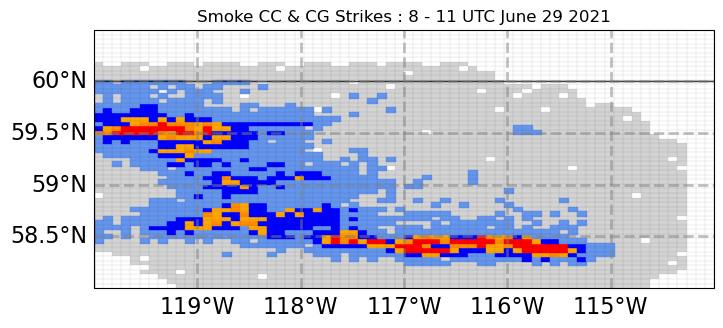

In [74]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_smoke, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_smoke, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_smoke)


# Make figure larger
plt.xlim([-120, -114])
plt.ylim([58, 60.5])

latlines = np.unique(smoke_grid_corners_df["max_lat"])
lonlines = np.unique(smoke_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -119, -118, -117, -116, -115])
gl.ylocator = mticker.FixedLocator([58.5, 59, 59.5, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Smoke CC & CG Strikes : 8 - 11 UTC June 29 2021")

plt.show()

## CC, CG, CC:CG, % +CG

In [75]:
# polygons for lightning density 
bt_min_lat = np.min(bt_smoke.min_lat)
bt_max_lat = np.max(bt_smoke.max_lat)
bt_min_lon = np.min(bt_smoke.min_lon)
bt_max_lon = np.max(bt_smoke.max_lon)

grid_smoke_split_cloud
grid_smoke_split_ground

grid_select = grid_smoke_split_cloud.loc[(grid_smoke_split_cloud.min_lat >= bt_min_lat) & (grid_smoke_split_cloud.max_lat <= bt_max_lat) &
                              (grid_smoke_split_cloud.min_lon >= bt_min_lon) & (grid_smoke_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_cloud = []
color_lt_smoke_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_smoke_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_smoke_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_smoke_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_smoke_cloud.append("darkorange")
    if (x > 140): 
        color_lt_smoke_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_smoke_split_ground.loc[(grid_smoke_split_ground.min_lat >= bt_min_lat) & (grid_smoke_split_ground.max_lat <= bt_max_lat) &
                              (grid_smoke_split_ground.min_lon >= bt_min_lon) & (grid_smoke_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_ground = []
color_lt_smoke_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_smoke_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_smoke_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_smoke_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_smoke_ground.append("darkorange")
    if (x > 140): 
        color_lt_smoke_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_smoke_split_cccg.loc[(grid_smoke_split_cccg.min_lat >= bt_min_lat) & (grid_smoke_split_cccg.max_lat <= bt_max_lat) &
                              (grid_smoke_split_cccg.min_lon >= bt_min_lon) & (grid_smoke_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_cccg = []
color_lt_smoke_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_smoke_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_smoke_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_smoke_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_smoke_cccg.append("darkorange")
    if (x > 12): 
        color_lt_smoke_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_smoke_percpos.loc[(grid_smoke_percpos.min_lat >= bt_min_lat) & (grid_smoke_percpos.max_lat <= bt_max_lat) &
                              (grid_smoke_percpos.min_lon >= bt_min_lon) & (grid_smoke_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_smoke_percpos = []
color_lt_smoke_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_smoke_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_smoke_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_smoke_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_smoke_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_smoke_percpos.append("darkorange")
    if (x > 50): 
        color_lt_smoke_percpos.append("red")

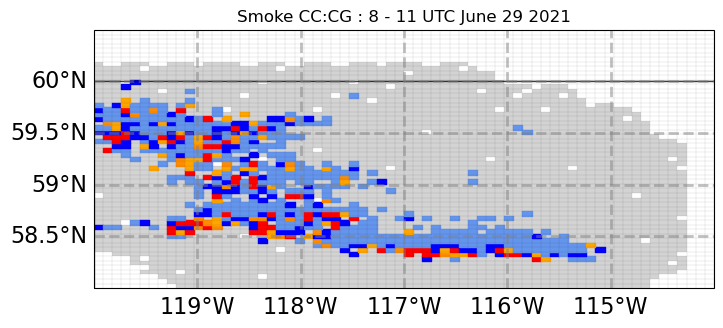

In [76]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_smoke, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_smoke_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_smoke_cccg)


# Make figure larger
plt.xlim([-120, -114])
plt.ylim([58, 60.5])

latlines = np.unique(smoke_grid_corners_df["max_lat"])
lonlines = np.unique(smoke_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -119, -118, -117, -116, -115])
gl.ylocator = mticker.FixedLocator([58.5, 59, 59.5, 60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Smoke CC:CG : 8 - 11 UTC June 29 2021")

plt.show()

## boxplot

In [77]:
smoke_cloud_max = []
for i in range(0, 4): 
    smoke_cloud_max.append(np.max(smoke_cloud_log_density_array[i]))

smoke_ground_max = []
for j in range(0, 4): 
    smoke_ground_max.append(np.max(smoke_ground_log_density_array[j]))

smoke_ground_max

[3.9935631571640644,
 3.3042503021551894,
 3.1230511871066704,
 3.3348465196380426]

[Text(0, 0, '08:00'),
 Text(2, 0, '09:00'),
 Text(4, 0, '10:00'),
 Text(6, 0, '11:00'),
 Text(1, 0, ''),
 Text(3, 0, ''),
 Text(5, 0, ''),
 Text(7, 0, '')]

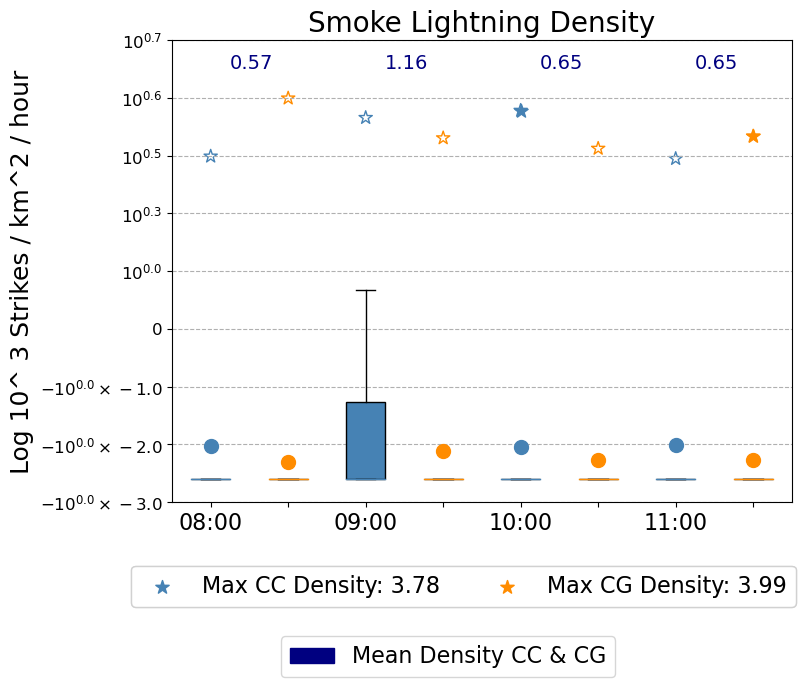

In [78]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


#ax = plt.subplot2grid(shape = (3,4), loc = (0,0), colspan=2)
ax.set_title('Smoke Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^ 3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-3, 5)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(smoke_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6]) 


box4_2 = ax.boxplot(smoke_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7]) 

ax.scatter(np.arange(0, 8, 2), smoke_cloud_max, s = 100, marker = "*",  facecolors='none', edgecolors='steelblue') 
ax.scatter(4, smoke_cloud_max[2], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(smoke_cloud_max))) 

ax.scatter(np.arange(1, 9, 2), smoke_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(7, smoke_ground_max[3], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(smoke_ground_max))) 


x = np.arange(0.25, 7.25, 2)
for i in range(0, 4, 1):
    ax.annotate("{:.2f}".format(np.mean(smoke_total_density_array[i])), (x[i], 4.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -0.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)

plt.gca().yaxis.grid(True, linestyle='--')

labels = ["08:00", "09:00", "10:00","11:00", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 minute analysis

### max denisty per 10 minute intervals

#### bt per 10 mins

In [79]:
## group the bt data to get area each 10 minutes
grouped_smoke_int_bt = bt_smoke.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_smoke_int_bt = grouped_smoke_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_smoke_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_smoke_int_bt["bt_area_km2"] = grouped_smoke_int_bt["bt_area_km2"] * 25
grid_smoke_int_bt = grouped_smoke_int_bt

grid_smoke_int_bt



min_lat    max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0      58.000000  58.043796 -119.205882 -119.117647     8      35           25
1      58.000000  58.043796 -119.117647 -119.029412     8      35           25
2      58.000000  58.043796 -119.029412 -118.941176     8      35           25
3      58.000000  58.043796 -118.941176 -118.852941     8      35           25
4      58.000000  58.043796 -118.852941 -118.764706     8      35           25
...          ...        ...         ...         ...   ...     ...          ...
25826  60.145985  60.189781 -116.911765 -116.823529    11      25           25
25827  60.145985  60.189781 -116.911765 -116.823529    11      35           25
25828  60.145985  60.189781 -116.647059 -116.558824    11      35           25
25829  60.145985  60.189781 -116.558824 -116.470588    11      35           25
25830  60.145985  60.189781 -116.470588 -116.382353    11      35           25

[25831 rows x 7 columns]

#### process data

In [80]:
"""hours = [8, 9, 10, 11]
mins = range(0, 60, 10)

grid_smoke_int_conc  = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        time_bt = grid_smoke_int_bt.loc[(grid_smoke_int_bt.hour == hours[i]) & (grid_smoke_int_bt.minute >= mins[j]) & (grid_smoke_int_bt.minute <= mins[j] + 9)]
        time_lt = grid_smoke_int.loc[(grid_smoke_int.hour == hours[i]) & (grid_smoke_int.minute >= mins[j]) & (grid_smoke_int.minute <= mins[j] + 9)]
        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']], on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')

        if len(grid_smoke_int_conc) == 0: 
            grid_smoke_int_conc = time_df
        else: 
            grid_smoke_int_conc = pd.concat([grid_smoke_int_conc, time_df], axis =0)


grid_smoke_int_conc['lt_count'] = np.nan_to_num(grid_smoke_int_conc.lt_count)

# ------------------------------------------

smoke_int_cloud_density_array = []
smoke_int_ground_density_array = []
smoke_total_density_array = []

smoke_int_cloud_max = []
smoke_int_ground_max = []

smoke_int_cloud_log_density_array = []
smoke_int_ground_log_density_array = []
smoke_total_log_density_array = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        
        strikes_smoke_int = grid_smoke_int_conc.loc[(grid_smoke_int_conc.hour == hours[i]) 
                                                      & (grid_smoke_int_conc.minute >= mins[j])
                                                      & (grid_smoke_int_conc.minute <= mins[j] + 9)]        
        cloud_count = strikes_smoke_int[(strikes_smoke_int["C or G"] != "G")]["lt_count"]
        ground_count = strikes_smoke_int[(strikes_smoke_int["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_smoke["bt_area_km2"])
        
        smoke_int_cloud_density = list(cloud_count/area * 10000)
        smoke_int_cloud_density = np.nan_to_num(smoke_int_cloud_density)
        smoke_int_cloud_density_array.append(smoke_int_cloud_density)
        if len(smoke_int_cloud_density)> 0:
            smoke_int_cloud_max.append(np.max(smoke_int_cloud_density))
        else: 
            smoke_int_cloud_max.append(0)
            
        smoke_int_ground_density = list(ground_count/area * 10000)
        smoke_int_ground_density = np.nan_to_num(smoke_int_ground_density)
        smoke_int_ground_density_array.append(smoke_int_ground_density)  
        if len(smoke_int_ground_density)> 0:
            smoke_int_ground_max.append(np.max(smoke_int_ground_density))
        else: 
            smoke_int_ground_max.append(0)
"""

'hours = [8, 9, 10, 11]\nmins = range(0, 60, 10)\n\ngrid_smoke_int_conc  = []\n\nfor i in range(len(hours)): \n    for j in range(len(mins)): \n        time_bt = grid_smoke_int_bt.loc[(grid_smoke_int_bt.hour == hours[i]) & (grid_smoke_int_bt.minute >= mins[j]) & (grid_smoke_int_bt.minute <= mins[j] + 9)]\n        time_lt = grid_smoke_int.loc[(grid_smoke_int.hour == hours[i]) & (grid_smoke_int.minute >= mins[j]) & (grid_smoke_int.minute <= mins[j] + 9)]\n        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", \'min_lat\', \'max_lat\', \'min_lon\', \'max_lon\']], on=["hour", \'min_lat\', \'max_lat\', \'min_lon\', \'max_lon\'], how=\'left\')\n\n        if len(grid_smoke_int_conc) == 0: \n            grid_smoke_int_conc = time_df\n        else: \n            grid_smoke_int_conc = pd.concat([grid_smoke_int_conc, time_df], axis =0)\n\n\ngrid_smoke_int_conc[\'lt_count\'] = np.nan_to_num(grid_smoke_int_conc.lt_count)\n\n# ------------------------------------------\n\nsmoke_i

#### plot

In [81]:
"""fig, ax = plt.subplots(figsize = (6, 4))
x1 = range(0, len(smoke_int_cloud_max))
plt.plot(x1, smoke_int_cloud_max, label = "CC")

x2 = range(0, len(smoke_int_ground_max))
plt.plot(x2, smoke_int_ground_max, label = "CG")
plt.legend()

plt.gca().yaxis.grid(True, linestyle='--')
ax.set_xlabel("10 minute interval")
plt.title("Smoke Max Density 23 - 2 UTC")
"""

'fig, ax = plt.subplots(figsize = (6, 4))\nx1 = range(0, len(smoke_int_cloud_max))\nplt.plot(x1, smoke_int_cloud_max, label = "CC")\n\nx2 = range(0, len(smoke_int_ground_max))\nplt.plot(x2, smoke_int_ground_max, label = "CG")\nplt.legend()\n\nplt.gca().yaxis.grid(True, linestyle=\'--\')\nax.set_xlabel("10 minute interval")\nplt.title("Smoke Max Density 23 - 2 UTC")\n'

## 10 minute intervals 

In [82]:
# grid_smoke_int = pd.read_csv("/data2/edworak/data/smoke_lightning_bt.csv", sep='\t')

hours1 = [8, 9, 10, 11]
mins1 = range(0, 60, 10)

smoke_cloud_density_array = []
smoke_ground_density_array = []
smoke_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_smoke_split = grid_smoke_int_split.loc[(grid_smoke_int_split.hour == hours1[i]) & (grid_smoke_int_split.minute >= mins1[j]) & (grid_smoke_int_split.minute <= mins1[j] + 9)]        
        strikes_smoke = grid_smoke_int.loc[(grid_smoke_int.hour == hours1[i]) & (grid_smoke_int.minute >= mins1[j]) & (grid_smoke_int.minute <= mins1[j] + 9)]        
        bt_smoke = grid_smoke_int_bt.loc[(grid_smoke_int_bt.hour == hours1[i]) & (grid_smoke_int_bt.minute >= mins1[j]) & (grid_smoke_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_smoke_split) >= 1: 
            #smoke_cloud_array.append(np.array(strikes_smoke[(strikes_smoke["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_smoke_split[(strikes_smoke_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_smoke["bt_area_km2"])

            smoke_cloud_density = list((cloud_count/area) * 10000)
            smoke_cloud_density = np.nan_to_num(smoke_cloud_density)
            smoke_cloud_density_array.append(np.array(smoke_cloud_density))

            smoke_ground_density = list((ground_count/area) * 10000)
            smoke_ground_density = np.nan_to_num(smoke_ground_density)
            smoke_ground_density_array.append(np.array(smoke_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_smoke["lt_count"]

            smoke_total_density = list(total_count/area * 10000)
            smoke_total_density = np.nan_to_num(smoke_total_density)
            smoke_total_density_array.append(np.array(smoke_total_density))

# if np.any(smoke_cloud_density_array > 100):
#     smoke_cloud_density_array = [i for i in smoke_cloud_density_array if i < 100]
smoke_cloud_density_flat = [item for sublist in smoke_cloud_density_array for item in sublist]

# smoke_ground_density_array = smoke_ground_density_array[smoke_ground_density_array < 100]
smoke_ground_density_flat = [item for sublist in smoke_ground_density_array for item in sublist]

# smoke_total_density_array = smoke_total_density_array[smoke_total_density_array < 100]
smoke_total_density_flat = [item for sublist in smoke_total_density_array for item in sublist]




In [83]:
type(smoke_cloud_density_array)

list

# Clean Case 1 : June 8 21 UTC (159) - 9 2 UTC 2019 (160)
- 21 - 23 UTC : -118:-115, 52.5 : 54
- 0 - 2 UTC: -117 : -115, 51.5: 53.5

In [84]:
correct_clean1 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean1_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean1["lt_count"] = np.zeros((1593))
np.unique(correct_clean1.hour)



array([ 0,  1,  2, 21, 22, 23])

In [85]:
lat_vals = range(50, 61)
lon_vals = range(-125, -114)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [86]:
# Define the latitude and longitude values for your clean1_grid (assuming evenly spaced)
latitude_values = np.linspace(50, 60, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-125, -115, num=len(ds_out_lon_flat)) 

# Calculate the clean1_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean1_grid corners
clean1_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean1_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean1_grid cell's corners to the list
        clean1_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean1_grid_corners list now contains the corner coordinates of each clean1_grid cell
# Each element of the list is a list of four tuples representing the corners
clean1_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean1_grid_corners_df = clean1_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean1_grid_corners_df = clean1_grid_corners_df.drop_duplicates(keep='first') 
clean1_grid_corners_df

min_lat    max_lat     min_lon     max_lon
0      50.000000  50.043668 -125.000000 -124.925373
1      50.000000  50.043668 -124.925373 -124.850746
2      50.000000  50.043668 -124.850746 -124.776119
3      50.000000  50.043668 -124.776119 -124.701493
4      50.000000  50.043668 -124.701493 -124.626866
...          ...        ...         ...         ...
30681  59.956332  60.000000 -115.373134 -115.298507
30682  59.956332  60.000000 -115.298507 -115.223881
30683  59.956332  60.000000 -115.223881 -115.149254
30684  59.956332  60.000000 -115.149254 -115.074627
30685  59.956332  60.000000 -115.074627 -115.000000

[30686 rows x 4 columns]

In [87]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean1)): 
    # print(i)
    findlat = correct_clean1.lat[i]
    findlon = correct_clean1.lon[i]

    findcorners = clean1_grid_corners_df.loc[(clean1_grid_corners_df.min_lat <= findlat) & (clean1_grid_corners_df.max_lat >= findlat) & 
                                     (clean1_grid_corners_df.min_lon <= findlon) & (clean1_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean1["min_lat"] = min_lat_array
correct_clean1["max_lat"] = max_lat_array
correct_clean1["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean1["min_lon"] = min_lon_array
correct_clean1["max_lon"] = max_lon_array
correct_clean1["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean1



year  month  day  hour  minute     second      lat       lon  \
0     2019      6    8    22      35  14.468115  53.0279 -116.9259   
1     2019      6    8    22      50   1.178123  52.9624 -116.6760   
2     2019      6    8    23      30   0.889591  52.7460 -116.1410   
3     2019      6    8    22      40   2.058415  53.0206 -116.7752   
4     2019      6    8    23       0   1.700166  52.9440 -116.5576   
...    ...    ...  ...   ...     ...        ...      ...       ...   
1588  2019      6    9     0       8  57.724226  52.4747 -115.9812   
1589  2019      6    9     0       8  57.899713  52.4740 -115.9850   
1590  2019      6    9     0       9  44.747839  52.4496 -115.9428   
1591  2019      6    9     0       9  44.760435  52.4533 -115.9410   
1592  2019      6    9     0       9  45.063343  52.4532 -115.9389   

      peak current C or G  ...       tlat        tlon  distance(km)  lt_count  \
0            -49.6      G  ...  53.048259 -116.919935         1.221       0.0   
1              6.8      C  ...  52.980495 -116.675100         0.909       0.0   
2            -56.1      G  ...  52.745068 -116.138635         0.267       0.0   
3              4.0      C  ...  53.016615 -116.760792         1.614       0.0   
4              8.7      C  ...  52.956963 -116.543504         1.695       0.0   
...            ...    ...  ...        ...         ...           ...       ...   
1588         -11.4      C  ...  52.475745 -115.982353         0.138       0.0   
1589         -12.1      G  ...  52.475745 -115.982353         0.306       0.0   
1590         -21.5      G  ...  52.446195 -115.926155         1.858       0.0   
1591          -8.5      G  ...  52.446195 -115.926155         1.686       0.0   
1592          -7.3      C  ...  52.446195 -115.926155         1.458       0.0   

        min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  
0     53.013100  53.056769  53.034934 -116.940299 -116.865672 -116.902985  
1     52.925764  52.969432  52.947598 -116.716418 -116.641791 -116.679104  
2     52.707424  52.751092  52.729258 -116.194030 -116.119403 -116.156716  
3     53.013100  53.056769  53.034934 -116.791045 -116.716418 -116.753731  
4     52.925764  52.969432  52.947598 -116.567164 -116.492537 -116.529851  
...         ...        ...        ...         ...         ...         ...  
1588  52.445415  52.489083  52.467249 -116.044776 -115.970149 -116.007463  
1589  52.445415  52.489083  52.467249 -116.044776 -115.970149 -116.007463  
1590  52.445415  52.489083  52.467249 -115.970149 -115.895522 -115.932836  
1591  52.445415  52.489083  52.467249 -115.970149 -115.895522 -115.932836  
1592  52.445415  52.489083  52.467249 -115.970149 -115.895522 -115.932836  

[1593 rows x 21 columns]

In [88]:
correct_clean1.columns

Index(['year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon',
       'peak current', 'C or G', 'CMI_C14', 'tlat', 'tlon', 'distance(km)',
       'lt_count', 'min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon',
       'cent_lon'],
      dtype='object')

In [89]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean1_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_split = grid_clean1_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean1_split = grid_clean1_split.T.drop_duplicates().T
grid_clean1_split.lt_count = pd.to_numeric(grid_clean1_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean1_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_split_all = grid_clean1_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean1_split_all = grid_clean1_split_all.T.drop_duplicates().T
grid_clean1_split_all.lt_count = pd.to_numeric(grid_clean1_split_all.lt_count)
grid_clean1_split_cloud = grid_clean1_split_all.loc[grid_clean1_split_all["C or G"] == "C"]
grid_clean1_split_ground = grid_clean1_split_all.loc[grid_clean1_split_all["C or G"] == "G"]


grid_clean1_split_cccg = pd.merge(grid_clean1_split_cloud, grid_clean1_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean1_split_cccg.loc[(grid_clean1_split_cccg.lt_count_y >= 0)]
grid_clean1_split_cccg["CC:CG"] = grid_clean1_split_cccg.lt_count_x / grid_clean1_split_cccg.lt_count_y
grid_clean1_split_cccg = grid_clean1_split_cccg.loc[grid_clean1_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean1_ground = correct_clean1.loc[correct_clean1["C or G"] != "C"]
grouped_lt = correct_clean1_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean1_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean1_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_percpos = grid_clean1_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean1_percpos = grid_clean1_percpos.T.drop_duplicates().T
grid_clean1_percpos.lt_count = pd.to_numeric(grid_clean1_percpos.lt_count)
grid_clean1_percpos_pos = grid_clean1_percpos.loc[grid_clean1_percpos["peak current"] > 0]

grid_clean1_percpos = pd.merge(grid_clean1_split_ground, grid_clean1_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean1_percpos.lt_count_y = np.nan_to_num(grid_clean1_percpos.lt_count_y)
grid_clean1_percpos["perc_pos"] = (grid_clean1_percpos.lt_count_y / grid_clean1_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean1 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1 = grid_clean1[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean1 = grid_clean1.T.drop_duplicates().T
grid_clean1.lt_count = pd.to_numeric(grid_clean1.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean1_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_all = grid_clean1_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean1_all = grid_clean1_all.T.drop_duplicates().T
grid_clean1_all.lt_count = pd.to_numeric(grid_clean1_all.lt_count)
grid_clean1_all


min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  \
0    51.615721  51.659389  51.637555 -115.373134 -115.298507 -115.335821   
1    51.615721  51.659389  51.637555 -115.298507 -115.223881 -115.261194   
2    51.615721  51.659389  51.637555 -115.223881 -115.149254 -115.186567   
3    51.659389  51.703057  51.681223 -115.447761 -115.373134 -115.410448   
4    51.659389  51.703057  51.681223 -115.298507 -115.223881 -115.261194   
..         ...        ...        ...         ...         ...         ...   
269  53.537118  53.580786  53.558952 -117.835821 -117.761194 -117.798507   
270  53.537118  53.580786  53.558952 -117.761194 -117.686567 -117.723881   
271  53.537118  53.580786  53.558952 -117.686567 -117.611940 -117.649254   
272  53.580786  53.624454  53.602620 -117.910448 -117.835821 -117.873134   
273  53.580786  53.624454  53.602620 -117.835821 -117.761194 -117.798507   

       CMI_C14  lt_count  
0   -55.163727       1.0  
1   -52.709840       1.0  
2   -52.709840       1.0  
3   -54.804610       1.0  
4   -54.804610       2.0  
..         ...       ...  
269 -52.590134       2.0  
270 -51.931778       9.0  
271 -50.734770       1.0  
272 -51.452972       3.0  
273 -50.914307       1.0  

[274 rows x 8 columns]

In [90]:
# --------------------------------------------------------------

# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean1_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_int = grid_clean1_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean1_int = grid_clean1_int.T.drop_duplicates().T
grid_clean1_int.lt_count = pd.to_numeric(grid_clean1_int.lt_count)


# --------------------------------------------------------------

## 10 minute int_splitervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean1.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean1_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean1_int_split = grid_clean1_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean1_int_split = grid_clean1_int_split.T.drop_duplicates().T
grid_clean1_int_split.lt_count = pd.to_numeric(grid_clean1_int_split.lt_count)

grid_clean1_int_split


hour minute    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0      2     19  51.615721  51.659389  51.637555 -115.373134 -115.298507   
1      2     19  51.615721  51.659389  51.637555 -115.298507 -115.223881   
2      2     19  51.615721  51.659389  51.637555 -115.223881 -115.149254   
3      2     12  51.659389  51.703057  51.681223 -115.447761 -115.373134   
4      2     16  51.659389  51.703057  51.681223 -115.298507 -115.223881   
..   ...    ...        ...        ...        ...         ...         ...   
914   21     19  53.537118  53.580786  53.558952 -117.761194 -117.686567   
915   21     14  53.537118  53.580786  53.558952 -117.686567  -117.61194   
916   21      1  53.580786  53.624454   53.60262 -117.910448 -117.835821   
917   21      1  53.580786  53.624454   53.60262 -117.910448 -117.835821   
918   21      5  53.580786  53.624454   53.60262 -117.835821 -117.761194   

       cent_lon C or G    CMI_C14  lt_count  
0   -115.335821      C -55.163727         1  
1   -115.261194      C  -52.70984         1  
2   -115.186567      C  -52.70984         1  
3   -115.410448      C  -54.80461         1  
4   -115.261194      C  -54.80461         2  
..          ...    ...        ...       ...  
914 -117.723881      C  -50.73477         2  
915 -117.649254      G  -50.73477         1  
916 -117.873134      C -51.452972         1  
917 -117.873134      G -51.452972         2  
918 -117.798507      G -50.914307         1  

[919 rows x 11 columns]

### brightness temp

In [91]:
bt_clean1 = pd.read_csv("/data2/edworak/data/correct_bt_clean1.nc")
bt_clean1 = bt_clean1.loc[(bt_clean1.tlat >= 50) & (bt_clean1.tlat <= 58) 
                          & (bt_clean1.tlon >= -125) & (bt_clean1.tlon <= -115)]
bt_clean1 = bt_clean1.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean1)): 
    findlat = bt_clean1.tlat[i]
    findlon = bt_clean1.tlon[i]

    findcorners = clean1_grid_corners_df.loc[(clean1_grid_corners_df.min_lat <= findlat) & (clean1_grid_corners_df.max_lat >= findlat) & 
                                     (clean1_grid_corners_df.min_lon <= findlon) & (clean1_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean1["min_lat"] = min_lat_array_flat
bt_clean1["max_lat"] = max_lat_array_flat
bt_clean1["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean1["min_lon"] = min_lon_array_flat
bt_clean1["max_lon"] = max_lon_array_flat
bt_clean1["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean1


index  Unnamed: 0  year  month  day  hour  minute       tlat  \
0          0           0  2019      6    8    18      55  54.594214   
1          1           1  2019      6    8    18      55  54.596305   
2          2           2  2019      6    8    18      55  54.598357   
3          3           3  2019      6    8    18      55  54.384408   
4          4           4  2019      6    8    18      55  54.349030   
...      ...         ...   ...    ...  ...   ...     ...        ...   
78834  79415       79415  2019      6    9     5      55  50.830090   
78835  79416       79416  2019      6    9     5      55  50.832188   
78836  79417       79417  2019      6    9     5      55  50.833673   
78837  79418       79418  2019      6    9     5      55  50.835030   
78838  79419       79419  2019      6    9     5      55  50.787686   

             tlon    CMI_C14    min_lat    max_lat   cent_lat     min_lon  \
0     -118.252263 -50.196106  54.585153  54.628821  54.606987 -118.283582   
1     -118.214673 -50.974167  54.585153  54.628821  54.606987 -118.283582   
2     -118.177093 -50.495360  54.585153  54.628821  54.606987 -118.208955   
3     -118.398244 -50.016556  54.366812  54.410480  54.388646 -118.432836   
4     -118.272454 -50.255950  54.323144  54.366812  54.344978 -118.283582   
...           ...        ...        ...        ...        ...         ...   
78834 -118.234291 -50.854460  50.829694  50.873362  50.851528 -118.283582   
78835 -118.200071 -50.255950  50.829694  50.873362  50.851528 -118.208955   
78836 -118.166291 -50.136260  50.829694  50.873362  50.851528 -118.208955   
78837 -118.132575 -50.136260  50.829694  50.873362  50.851528 -118.134328   
78838 -118.353531 -50.196106  50.786026  50.829694  50.807860 -118.358209   

          max_lon    cent_lon  
0     -118.208955 -118.246269  
1     -118.208955 -118.246269  
2     -118.134328 -118.171642  
3     -118.358209 -118.395522  
4     -118.208955 -118.246269  
...           ...         ...  
78834 -118.208955 -118.246269  
78835 -118.134328 -118.171642  
78836 -118.134328 -118.171642  
78837 -118.059701 -118.097015  
78838 -118.283582 -118.320896  

[78839 rows x 16 columns]

In [92]:
np.unique(bt_clean1.hour)

array([ 0,  1,  2,  3,  4,  5, 18, 19, 20, 21, 22, 23])

In [93]:
## group the bt data to get area at each hour
bt_clean1 = bt_clean1.loc[(bt_clean1.hour >= 21) | (bt_clean1.hour <= 2)]
grouped_clean1_bt = bt_clean1.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean1_bt = grouped_clean1_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean1_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean1_bt["bt_area_km2"] = grouped_clean1_bt["bt_area_km2"] * 25
grid_clean1_bt = grouped_clean1_bt

grid_clean1_bt

min_lat    max_lat     min_lon     max_lon  hour  bt_area_km2
0      50.000000  50.043668 -120.373134 -120.298507     0           25
1      50.000000  50.043668 -119.626866 -119.552239    23           25
2      50.000000  50.043668 -119.552239 -119.477612    21           25
3      50.000000  50.043668 -119.552239 -119.477612    23           25
4      50.000000  50.043668 -119.477612 -119.402985    21           25
...          ...        ...         ...         ...   ...          ...
11551  56.550218  56.593886 -122.910448 -122.835821     1           25
11552  56.593886  56.637555 -123.059701 -122.985075     1           25
11553  56.593886  56.637555 -122.985075 -122.910448     1           25
11554  56.681223  56.724891 -123.134328 -123.059701     0           25
11555  56.681223  56.724891 -123.059701 -122.985075     0           25

[11556 rows x 6 columns]

In [94]:
bt_clean1 = bt_clean1.loc[(bt_clean1.hour >= 21) | (bt_clean1.hour <= 2)]
grouped_clean1_int_bt = bt_clean1.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean1_int_bt = grouped_clean1_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean1_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean1_int_bt["bt_area_km2"] = 25
grid_clean1_int_bt = grouped_clean1_int_bt

grid_clean1_int_bt



min_lat    max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0      50.000000  50.043668 -120.373134 -120.298507     0      35           25
1      50.000000  50.043668 -119.626866 -119.552239    23      15           25
2      50.000000  50.043668 -119.552239 -119.477612    21      55           25
3      50.000000  50.043668 -119.552239 -119.477612    23      25           25
4      50.000000  50.043668 -119.477612 -119.402985    21      45           25
...          ...        ...         ...         ...   ...     ...          ...
30093  56.593886  56.637555 -122.985075 -122.910448     1       5           25
30094  56.593886  56.637555 -122.985075 -122.910448     1      15           25
30095  56.593886  56.637555 -122.985075 -122.910448     1      25           25
30096  56.681223  56.724891 -123.134328 -123.059701     0      55           25
30097  56.681223  56.724891 -123.059701 -122.985075     0      55           25

[30098 rows x 7 columns]

### combine datasets

In [95]:
grid_clean1_conc = pd.merge(grid_clean1_bt, grid_clean1[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean1_conc['lt_count'] = np.nan_to_num(grid_clean1_conc.lt_count)

grid_clean1_split_conc = pd.merge(grid_clean1_bt, grid_clean1_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean1_split_conc['lt_count'] = np.nan_to_num(grid_clean1_split_conc.lt_count)
grid_clean1_split_conc

min_lat    max_lat     min_lon     max_lon hour  bt_area_km2  \
0           50.0  50.043668 -120.373134 -120.298507    0           25   
1           50.0  50.043668 -119.626866 -119.552239   23           25   
2           50.0  50.043668 -119.552239 -119.477612   21           25   
3           50.0  50.043668 -119.552239 -119.477612   23           25   
4           50.0  50.043668 -119.477612 -119.402985   21           25   
...          ...        ...         ...         ...  ...          ...   
11668  56.550218  56.593886 -122.910448 -122.835821    1           25   
11669  56.593886  56.637555 -123.059701 -122.985075    1           25   
11670  56.593886  56.637555 -122.985075 -122.910448    1           25   
11671  56.681223  56.724891 -123.134328 -123.059701    0           25   
11672  56.681223  56.724891 -123.059701 -122.985075    0           25   

       lt_count C or G  
0           0.0    NaN  
1           0.0    NaN  
2           0.0    NaN  
3           0.0    NaN  
4           0.0    NaN  
...         ...    ...  
11668       0.0    NaN  
11669       0.0    NaN  
11670       0.0    NaN  
11671       0.0    NaN  
11672       0.0    NaN  

[11673 rows x 8 columns]

### map

In [96]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean1_select = bt_clean1
bt_clean1_select = bt_clean1_select.reset_index()

patches_bt_clean1 = []

for i in range(len(bt_clean1_select)):
    y = np.array([[bt_clean1_select.min_lon[i], bt_clean1_select.min_lat[i]], [bt_clean1_select.max_lon[i], bt_clean1_select.min_lat[i]], 
                  [bt_clean1_select.max_lon[i], bt_clean1_select.max_lat[i]], [bt_clean1_select.min_lon[i], bt_clean1_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean1.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 

bt_min_lat = np.min(bt_clean1.min_lat)
bt_max_lat = np.max(bt_clean1.max_lat)
bt_min_lon = np.min(bt_clean1.min_lon)
bt_max_lon = np.max(bt_clean1.max_lon)

grid_select = grid_clean1_all.loc[(grid_clean1_all.min_lat >= bt_min_lat) & (grid_clean1_all.max_lat <= bt_max_lat) &
                              (grid_clean1_all.min_lon >= bt_min_lon) & (grid_clean1_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1 = []
color_lt_clean1 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean1.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean1.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean1.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean1.append("darkorange")
    if (x > 140): 
        color_lt_clean1.append("red")

    
    

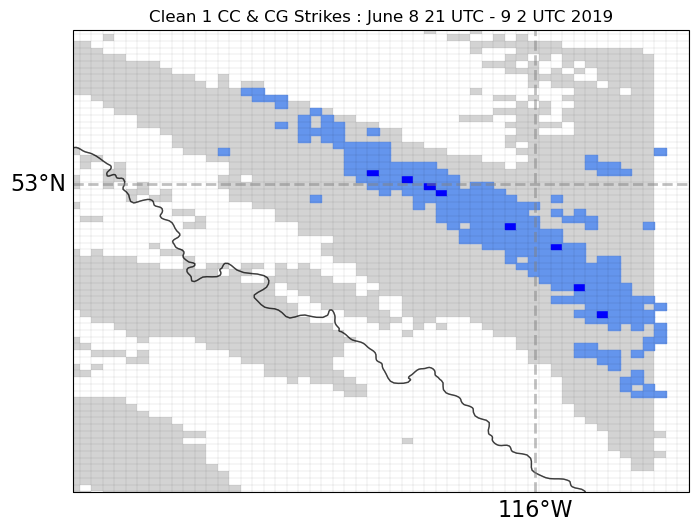

In [97]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean1, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean1, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean1)


# Make figure larger

plt.xlim([-119, -115])
plt.ylim([51, 54])

latlines = np.unique(clean1_grid_corners_df["max_lat"])
lonlines = np.unique(clean1_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -121,  -116])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 1 CC & CG Strikes : June 8 21 UTC - 9 2 UTC 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [98]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean1.min_lat)
bt_max_lat = np.max(bt_clean1.max_lat)
bt_min_lon = np.min(bt_clean1.min_lon)
bt_max_lon = np.max(bt_clean1.max_lon)

grid_clean1_split_cloud
grid_clean1_split_ground

grid_select = grid_clean1_split_cloud.loc[(grid_clean1_split_cloud.min_lat >= bt_min_lat) & (grid_clean1_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean1_split_cloud.min_lon >= bt_min_lon) & (grid_clean1_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_cloud = []
color_lt_clean1_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean1_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean1_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean1_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean1_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean1_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean1_split_ground.loc[(grid_clean1_split_ground.min_lat >= bt_min_lat) & (grid_clean1_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean1_split_ground.min_lon >= bt_min_lon) & (grid_clean1_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_ground = []
color_lt_clean1_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean1_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean1_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean1_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean1_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean1_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean1_split_cccg.loc[(grid_clean1_split_cccg.min_lat >= bt_min_lat) & (grid_clean1_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean1_split_cccg.min_lon >= bt_min_lon) & (grid_clean1_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_cccg = []
color_lt_clean1_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean1_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean1_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean1_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean1_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean1_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean1_percpos.loc[(grid_clean1_percpos.min_lat >= bt_min_lat) & (grid_clean1_percpos.max_lat <= bt_max_lat) &
                              (grid_clean1_percpos.min_lon >= bt_min_lon) & (grid_clean1_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean1_percpos = []
color_lt_clean1_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean1_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean1_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean1_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean1_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean1_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean1_percpos.append("red")

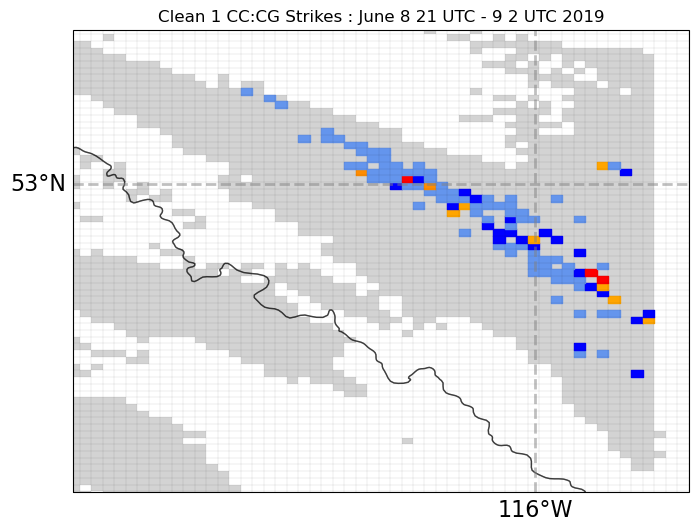

In [99]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean1, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean1_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean1_cccg)


# Make figure larger

plt.xlim([-119, -115])
plt.ylim([51, 54])

latlines = np.unique(clean1_grid_corners_df["max_lat"])
lonlines = np.unique(clean1_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -121,  -116])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 1 CC:CG Strikes : June 8 21 UTC - 9 2 UTC 2019")

plt.show()

## process data

In [100]:
hours = [21, 22, 23, 0, 1, 2]


clean1_cloud_density_array = []
clean1_ground_density_array = []
clean1_total_density_array = []

clean1_cloud_log_density_array = []
clean1_ground_log_density_array = []
clean1_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean1_split = grid_clean1_split_conc.loc[(grid_clean1_split_conc.hour == hours[i])]
        strikes_clean1 = grid_clean1_conc.loc[(grid_clean1_conc.hour == hours[i])]

        cloud_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean1["bt_area_km2"])
        
        clean1_cloud_density = list(cloud_count/area * 10000)
        clean1_cloud_density = np.nan_to_num(clean1_cloud_density)
        clean1_cloud_density_array.append(clean1_cloud_density)
        cloud_log = np.log(clean1_cloud_density + 7.654037504783774e-06)
        clean1_cloud_log_density_array.append(cloud_log)
        
        
        clean1_ground_density = list(ground_count/area * 10000)
        clean1_ground_density = np.nan_to_num(clean1_ground_density)
        clean1_ground_density_array.append(clean1_ground_density)  
        ground_log = np.log(clean1_ground_density + 7.654037504783774e-06)
        clean1_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean1["lt_count"]
        
        clean1_total_density = list(total_count/area * 10000)
        clean1_total_density = np.nan_to_num(clean1_total_density)
        clean1_total_density_array.append(clean1_total_density)
        total_log = np.log(clean1_total_density + 7.654037504783774e-06)
        clean1_total_log_density_array.append(total_log)
        
        
clean1_cloud_density_flat = [item for sublist in clean1_cloud_density_array for item in sublist]
clean1_ground_density_flat = [item for sublist in clean1_ground_density_array for item in sublist]
clean1_total_density_flat = [item for sublist in clean1_total_density_array for item in sublist]



In [101]:
clean1_cloud_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean1_cloud_density_array[i] if x != 0]) > 0: 
        clean1_cloud_halfmin.append(np.min([x for x in clean1_cloud_density_array[i] if x != 0]) / 2)

clean1_ground_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean1_ground_density_array[i] if x != 0]) > 0: 
        clean1_ground_halfmin.append(np.min([x for x in clean1_ground_density_array[i] if x != 0]) / 2)

clean1_total_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean1_total_density_array[i] if x != 0]) > 0: 
        clean1_total_halfmin.append(np.min([x for x in clean1_total_density_array[i] if x != 0]) / 2)

clean1_cloud_totmin = np.min(clean1_cloud_halfmin)
clean1_ground_totmin = np.min(clean1_ground_halfmin)
clean1_total_totmin = np.min(clean1_total_halfmin)

clean1_cloud_totmin, clean1_ground_totmin, clean1_total_totmin

(0.07654037504783774, 0.07654037504783774, 0.07654037504783774)

In [102]:
clean1_cloud_log_density_array

[array([-11.78027727, -11.78027727, -11.78027727, ..., -11.78027727,
        -11.78027727, -11.78027727]),
 array([-11.78027727, -11.78027727, -11.78027727, ..., -11.78027727,
        -11.78027727, -11.78027727]),
 array([-11.78027727, -11.78027727, -11.78027727, ..., -11.78027727,
        -11.78027727, -11.78027727]),
 array([-11.78027727, -11.78027727, -11.78027727, ..., -11.78027727,
        -11.78027727, -11.78027727]),
 array([-11.78027727, -11.78027727, -11.78027727, ..., -11.78027727,
        -11.78027727, -11.78027727]),
 array([-11.78027727, -11.78027727, -11.78027727, ..., -11.78027727,
        -11.78027727, -11.78027727])]

### boxplot

In [103]:
clean1_cloud_max = []
for i in range(0, 6): 
    clean1_cloud_max.append(np.max(clean1_cloud_log_density_array[i]))

clean1_ground_max = []
for j in range(0, 6): 
    clean1_ground_max.append(np.max(clean1_ground_log_density_array[j]))

clean1_cloud_max, clean1_ground_max

([1.2596638820173083,
  1.3221485815734297,
  0.895802128822268,
  1.4091878351236056,
  1.3114744204047208,
  0.39027384204009763],
 [0.3152056860438723,
  0.8521461764920707,
  0.7622711826248219,
  0.949656596694652,
  -0.5603164146257339,
  -0.9960049768011889])

[Text(0, 0, '21:00\n6/8'),
 Text(2, 0, '22:00'),
 Text(4, 0, '23:00'),
 Text(6, 0, '00:00\n6/9'),
 Text(8, 0, '01:00'),
 Text(10, 0, '02:00'),
 Text(1, 0, ''),
 Text(3, 0, ''),
 Text(5, 0, ''),
 Text(7, 0, ''),
 Text(9, 0, ''),
 Text(11, 0, '')]

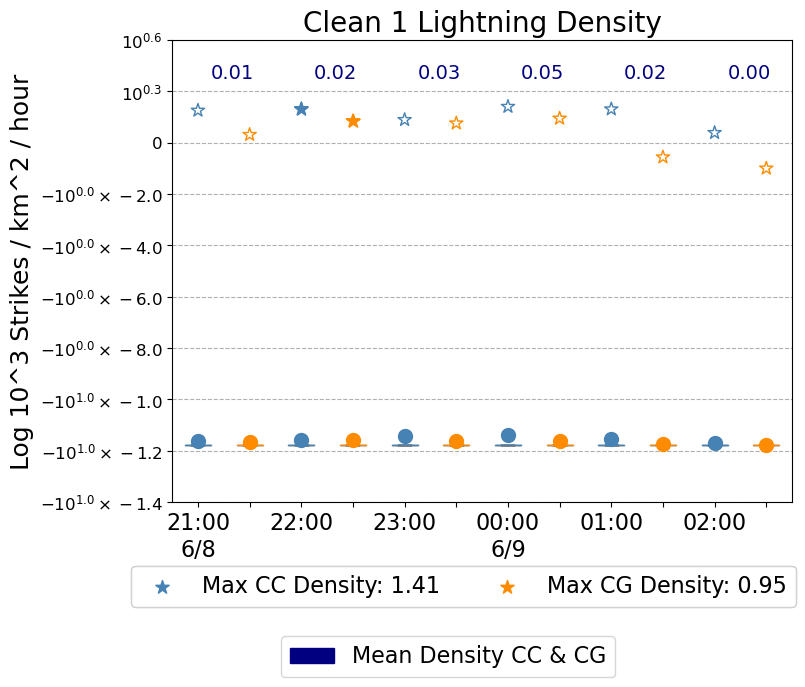

In [104]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 1 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-12.5, 3)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)

box4_1 = ax.boxplot(clean1_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10]) 


box4_2 = ax.boxplot(clean1_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11]) 

ax.scatter(np.arange(0, 12, 2), clean1_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(2, clean1_cloud_max[1], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean1_cloud_max))) 

ax.scatter(np.arange(1, 13, 2), clean1_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(3, clean1_ground_max[1], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean1_ground_max))) 

x = np.arange(0.25, 11.25, 2)
for i in range(0, 6, 1):
    ax.annotate("{:.2f}".format(np.mean(clean1_total_density_array[i])), (x[i], 2.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["21:00 6/8", "22:00", "23:00", "00:00 6/9", "01:00", "02:00", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 minute analysis

### max denisty per 10 minute intervals

#### bt per 10 mins

In [105]:
## group the bt data to get area each 10 minutes
grouped_clean1_int_bt = bt_clean1.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean1_int_bt = grouped_clean1_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean1_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean1_int_bt["bt_area_km2"] = grouped_clean1_int_bt["bt_area_km2"] * 25
grid_clean1_int_bt = grouped_clean1_int_bt

grid_clean1_int_bt



min_lat    max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0      50.000000  50.043668 -120.373134 -120.298507     0      35           25
1      50.000000  50.043668 -119.626866 -119.552239    23      15           25
2      50.000000  50.043668 -119.552239 -119.477612    21      55           25
3      50.000000  50.043668 -119.552239 -119.477612    23      25           25
4      50.000000  50.043668 -119.477612 -119.402985    21      45           25
...          ...        ...         ...         ...   ...     ...          ...
30093  56.593886  56.637555 -122.985075 -122.910448     1       5           25
30094  56.593886  56.637555 -122.985075 -122.910448     1      15           25
30095  56.593886  56.637555 -122.985075 -122.910448     1      25           25
30096  56.681223  56.724891 -123.134328 -123.059701     0      55           25
30097  56.681223  56.724891 -123.059701 -122.985075     0      55           25

[30098 rows x 7 columns]

#### process data

In [106]:
hours = [21, 22, 23, 0, 1, 2]
mins = range(0, 60, 10)

grid_clean1_int_split_conc  = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        time_bt = grid_clean1_int_bt.loc[(grid_clean1_int_bt.hour == hours[i]) & (grid_clean1_int_bt.minute >= mins[j]) & (grid_clean1_int_bt.minute <= mins[j] + 9)]
        time_lt = grid_clean1_int_split.loc[(grid_clean1_int_split.hour == hours[i]) & (grid_clean1_int_split.minute >= mins[j]) & (grid_clean1_int_split.minute <= mins[j] + 9)]
        time_df = pd.merge(time_bt, time_lt[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']], on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')

        if len(grid_clean1_int_split_conc) == 0: 
            grid_clean1_int_split_conc = time_df
        else: 
            grid_clean1_int_split_conc = pd.concat([grid_clean1_int_split_conc, time_df], axis =0)


grid_clean1_int_split_conc['lt_count'] = np.nan_to_num(grid_clean1_int_split_conc.lt_count)

# ------------------------------------------

clean1_int_cloud_density_array = []
clean1_int_ground_density_array = []
clean1_total_density_array = []

clean1_int_cloud_max = []
clean1_int_ground_max = []

clean1_int_cloud_log_density_array = []
clean1_int_ground_log_density_array = []
clean1_total_log_density_array = []

for i in range(len(hours)): 
    for j in range(len(mins)): 
        
        strikes_clean1_int = grid_clean1_int_split_conc.loc[(grid_clean1_int_split_conc.hour == hours[i]) 
                                                      & (grid_clean1_int_split_conc.minute >= mins[j])
                                                      & (grid_clean1_int_split_conc.minute <= mins[j] + 9)]        
        cloud_count = strikes_clean1_int[(strikes_clean1_int["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean1_int[(strikes_clean1_int["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean1_int["bt_area_km2"])
        
        clean1_int_cloud_density = list(cloud_count/area * 10000)
        clean1_int_cloud_density = np.nan_to_num(clean1_int_cloud_density)
        clean1_int_cloud_density_array.append(clean1_int_cloud_density)
        if len(clean1_int_cloud_density)> 0:
            clean1_int_cloud_max.append(np.max(clean1_int_cloud_density))
        else: 
            clean1_int_cloud_max.append(0)
            
        clean1_int_ground_density = list(ground_count/area * 10000)
        clean1_int_ground_density = np.nan_to_num(clean1_int_ground_density)
        clean1_int_ground_density_array.append(clean1_int_ground_density)  
        if len(clean1_int_ground_density)> 0:
            clean1_int_ground_max.append(np.max(clean1_int_ground_density))
        else: 
            clean1_int_ground_max.append(0)


#### plot

Text(0.5, 1.0, 'Clean 1 Max Density 21 - 2 UTC')

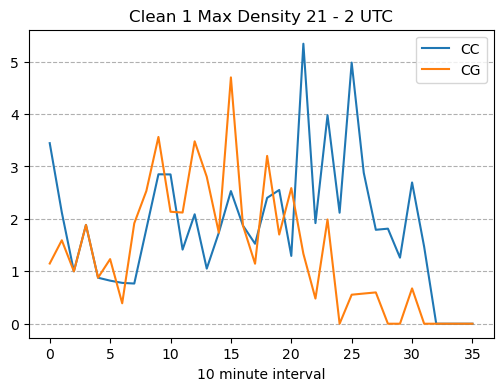

In [107]:
fig, ax = plt.subplots(figsize = (6, 4))
x1 = range(0, len(clean1_int_cloud_max))
plt.plot(x1, clean1_int_cloud_max, label = "CC")

x2 = range(0, len(clean1_int_ground_max))
plt.plot(x2, clean1_int_ground_max, label = "CG")
plt.legend()

plt.gca().yaxis.grid(True, linestyle='--')
ax.set_xlabel("10 minute interval")
plt.title("Clean 1 Max Density 21 - 2 UTC")


## 10 minute intervals

In [108]:
# grid_clean1_int = pd.read_csv("/data2/edworak/data/clean1_lightning_bt.csv", sep='\t')

hours1 = [21, 22, 23, 0, 1, 2]
mins1 = range(0, 60, 10)

clean1_cloud_density_array = []
clean1_ground_density_array = []
clean1_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean1_split = grid_clean1_int_split.loc[(grid_clean1_int_split.hour == hours1[i]) & (grid_clean1_int_split.minute >= mins1[j]) & (grid_clean1_int_split.minute <= mins1[j] + 9)]        
        strikes_clean1 = grid_clean1_int.loc[(grid_clean1_int.hour == hours1[i]) & (grid_clean1_int.minute >= mins1[j]) & (grid_clean1_int.minute <= mins1[j] + 9)]        
        bt_clean1 = grid_clean1_int_bt.loc[(grid_clean1_int_bt.hour == hours1[i]) & (grid_clean1_int_bt.minute >= mins1[j]) & (grid_clean1_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean1_split) >= 1: 
            #clean1_cloud_array.append(np.array(strikes_clean1[(strikes_clean1["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean1_split[(strikes_clean1_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean1['bt_area_km2']) 

            # strikes / 25 km^2 
            clean1_cloud_density = list((cloud_count/area) * 10000)
            clean1_cloud_density = np.nan_to_num(clean1_cloud_density)
            clean1_cloud_density_array.append(np.array(clean1_cloud_density))

            clean1_ground_density = list((ground_count/area) * 10000)
            clean1_ground_density = np.nan_to_num(clean1_ground_density)
            clean1_ground_density_array.append(np.array(clean1_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean1["lt_count"]

            clean1_total_density = list((total_count/area) * 10000)
            clean1_total_density = np.nan_to_num(clean1_total_density)
            clean1_total_density_array.append(np.array(clean1_total_density))

clean1_cloud_density_flat = [item for sublist in clean1_cloud_density_array for item in sublist]
clean1_ground_density_flat = [item for sublist in clean1_ground_density_array for item in sublist]
clean1_total_density_flat = [item for sublist in clean1_total_density_array for item in sublist]
clean1_cloud_density_array


[array([0.58055152, 1.16110305, 0.58055152, 1.16110305, 3.48330914,
        1.16110305, 2.3222061 , 2.3222061 , 2.3222061 , 0.58055152,
        0.58055152, 0.58055152]),
 array([0.53691275, 0.53691275, 2.14765101, 1.0738255 , 2.14765101,
        0.53691275, 0.53691275, 0.53691275, 0.53691275, 1.61073826,
        0.53691275, 1.0738255 ]),
 array([0.50125313, 0.50125313, 0.50125313, 0.50125313, 0.50125313,
        0.50125313, 1.00250627, 0.50125313]),
 array([0.47114252, 2.3557126 , 1.88457008, 0.47114252]),
 array([0.44052863, 0.88105727, 0.44052863, 0.44052863, 0.44052863]),
 array([0.83333333, 0.41666667, 0.83333333, 0.83333333, 0.41666667,
        0.41666667, 0.83333333, 0.41666667, 0.83333333, 0.41666667,
        0.41666667, 0.41666667]),
 array([0.78585462, 0.39292731, 0.78585462, 0.39292731, 0.39292731,
        0.39292731, 0.39292731, 0.39292731]),
 array([0.38910506, 0.77821012, 0.77821012, 0.38910506, 0.38910506,
        0.38910506, 0.38910506, 0.77821012, 0.38910506, 0.38910506

# Clean Case 2 : June 12 22 UTC - June 13 5 UTC (164)
#### 51 N : 54 N, -123 W : -115 W
- 23 - 1 UTC : -123:-120, 51:53
- 1 - 2 UTC : -121.8: -118.7, 51:53
- 2 - 5 UTC : -121: -116.5, 51:53.5


In [109]:
correct_clean2 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean2_new.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean2["lt_count"] = np.zeros((5891))
np.unique(correct_clean2.hour)

array([ 0,  1,  2,  3,  4,  5, 22, 23])

In [110]:
lat_vals = range(51, 60)
lon_vals = range(-123, -114)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [111]:
# Define the latitude and longitude values for your clean2_grid (assuming evenly spaced)
latitude_values = np.linspace(51, 59, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-123, -115, num=len(ds_out_lon_flat)) 

# Calculate the clean2_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean2_grid corners
clean2_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean2_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean2_grid cell's corners to the list
        clean2_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean2_grid_corners list now contains the corner coordinates of each clean2_grid cell
# Each element of the list is a list of four tuples representing the corners
clean2_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean2_grid_corners_df = clean2_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean2_grid_corners_df = clean2_grid_corners_df.drop_duplicates(keep='first') 
clean2_grid_corners_df

min_lat    max_lat     min_lon     max_lon
0      51.000000  51.043716 -123.000000 -122.925234
1      51.000000  51.043716 -122.925234 -122.850467
2      51.000000  51.043716 -122.850467 -122.775701
3      51.000000  51.043716 -122.775701 -122.700935
4      51.000000  51.043716 -122.700935 -122.626168
...          ...        ...         ...         ...
19576  58.956284  59.000000 -115.373832 -115.299065
19577  58.956284  59.000000 -115.299065 -115.224299
19578  58.956284  59.000000 -115.224299 -115.149533
19579  58.956284  59.000000 -115.149533 -115.074766
19580  58.956284  59.000000 -115.074766 -115.000000

[19581 rows x 4 columns]

In [112]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean2)): 
    # print(i)
    findlat = correct_clean2.lat[i]
    findlon = correct_clean2.lon[i]

    findcorners = clean2_grid_corners_df.loc[(clean2_grid_corners_df.min_lat <= findlat) & (clean2_grid_corners_df.max_lat >= findlat) & 
                                     (clean2_grid_corners_df.min_lon <= findlon) & (clean2_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean2["min_lat"] = min_lat_array
correct_clean2["max_lat"] = max_lat_array
correct_clean2["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean2["min_lon"] = min_lon_array
correct_clean2["max_lon"] = max_lon_array
correct_clean2["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean2

np.unique(correct_clean2.hour)

array([ 0,  1,  2,  3,  4,  5, 22, 23])

In [113]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean2_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_split = grid_clean2_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean2_split = grid_clean2_split.T.drop_duplicates().T
grid_clean2_split.lt_count = pd.to_numeric(grid_clean2_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean2_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_split_all = grid_clean2_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean2_split_all = grid_clean2_split_all.T.drop_duplicates().T
grid_clean2_split_all.lt_count = pd.to_numeric(grid_clean2_split_all.lt_count)
grid_clean2_split_cloud = grid_clean2_split_all.loc[grid_clean2_split_all["C or G"] == "C"]
grid_clean2_split_ground = grid_clean2_split_all.loc[grid_clean2_split_all["C or G"] == "G"]


grid_clean2_split_cccg = pd.merge(grid_clean2_split_cloud, grid_clean2_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean2_split_cccg.loc[(grid_clean2_split_cccg.lt_count_y >= 0)]
grid_clean2_split_cccg["CC:CG"] = grid_clean2_split_cccg.lt_count_x / grid_clean2_split_cccg.lt_count_y
grid_clean2_split_cccg = grid_clean2_split_cccg.loc[grid_clean2_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean2_ground = correct_clean2.loc[correct_clean2["C or G"] != "C"]
grouped_lt = correct_clean2_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean2_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean2_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_percpos = grid_clean2_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean2_percpos = grid_clean2_percpos.T.drop_duplicates().T
grid_clean2_percpos.lt_count = pd.to_numeric(grid_clean2_percpos.lt_count)
grid_clean2_percpos_pos = grid_clean2_percpos.loc[grid_clean2_percpos["peak current"] > 0]

grid_clean2_percpos = pd.merge(grid_clean2_split_ground, grid_clean2_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean2_percpos.lt_count_y = np.nan_to_num(grid_clean2_percpos.lt_count_y)
grid_clean2_percpos["perc_pos"] = (grid_clean2_percpos.lt_count_y / grid_clean2_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean2 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2 = grid_clean2[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean2 = grid_clean2.T.drop_duplicates().T
grid_clean2.lt_count = pd.to_numeric(grid_clean2.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean2_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_all = grid_clean2_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean2_all = grid_clean2_all.T.drop_duplicates().T
grid_clean2_all.lt_count = pd.to_numeric(grid_clean2_all.lt_count)
grid_clean2_all

# --------------------------------------------------------------

grid_clean2_percpos


min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  \
0    51.743169  51.786885  51.765027 -121.803738 -121.728972 -121.766355   
1    51.743169  51.786885  51.765027 -121.728972 -121.654206 -121.691589   
2    51.743169  51.786885  51.765027 -121.654206 -121.579439 -121.616822   
3    51.743169  51.786885  51.765027 -121.579439 -121.504673 -121.542056   
4    51.743169  51.786885  51.765027 -121.429907  -121.35514 -121.392523   
..         ...        ...        ...         ...         ...         ...   
466  53.448087  53.491803  53.469945 -119.560748 -119.485981 -119.523364   
467  53.448087  53.491803  53.469945 -119.485981 -119.411215 -119.448598   
468  53.448087  53.491803  53.469945 -119.485981 -119.411215 -119.448598   
469  53.491803  53.535519  53.513661  -119.71028 -119.635514 -119.672897   
470  53.491803  53.535519  53.513661 -119.560748 -119.485981 -119.523364   

    C or G  CMI_C14_x  lt_count_x  CMI_C14_y  lt_count_y    perc_pos  
0        G -58.694916           1        NaN         0.0    0.000000  
1        G -59.233566           3 -58.455505         1.0   33.333333  
2        G -59.832077           1        NaN         0.0    0.000000  
3        G  -58.99417           3        NaN         0.0    0.000000  
4        G -55.941772           1        NaN         0.0    0.000000  
..     ...        ...         ...        ...         ...         ...  
466      G -50.016556           2 -50.016556         1.0   50.000000  
467      G -51.213562           3 -51.213562         1.0   33.333333  
468      G -51.213562           3 -50.495360         1.0   33.333333  
469      G  -50.49536           1 -50.495360         1.0  100.000000  
470      G  -50.85446           1 -50.854460         1.0  100.000000  

[471 rows x 12 columns]

In [114]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean2_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_int_split = grid_clean2_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean2_int_split = grid_clean2_int_split.T.drop_duplicates().T
grid_clean2_int_split.lt_count = pd.to_numeric(grid_clean2_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean2.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean2_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean2_int = grid_clean2_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean2_int = grid_clean2_int.T.drop_duplicates().T
grid_clean2_int.lt_count = pd.to_numeric(grid_clean2_int.lt_count)

grid_clean2_int_split
grid_clean2_int_split

hour minute    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0       0      0  51.480874   51.52459  51.502732  -121.35514 -121.280374   
1       2     51  51.699454  51.743169  51.721311  -119.11215 -119.037383   
2       2     52  51.699454  51.743169  51.721311  -119.11215 -119.037383   
3       2     21  51.699454  51.743169  51.721311 -119.037383 -118.962617   
4       2     57  51.699454  51.743169  51.721311 -119.037383 -118.962617   
...   ...    ...        ...        ...        ...         ...         ...   
3338    4     40  53.448087  53.491803  53.469945 -119.485981 -119.411215   
3339    5      3  53.448087  53.491803  53.469945 -119.186916  -119.11215   
3340    4     24  53.491803  53.535519  53.513661  -119.71028 -119.635514   
3341    4     28  53.491803  53.535519  53.513661 -119.635514 -119.560748   
3342    4     31  53.491803  53.535519  53.513661 -119.560748 -119.485981   

        cent_lon C or G    CMI_C14  lt_count  
0    -121.317757      C  -50.67491         1  
1    -119.074766      C -50.196106         1  
2    -119.074766      C -51.333267         1  
3         -119.0      C -51.333267         1  
4         -119.0      C  -50.85446         1  
...          ...    ...        ...       ...  
3338 -119.448598      G -51.213562         1  
3339 -119.149533      C -51.333267         1  
3340 -119.672897      G  -50.49536         1  
3341 -119.598131      C  -50.61505         1  
3342 -119.523364      G  -50.85446         1  

[3343 rows x 11 columns]

### brightness temp

In [115]:
bt_clean2 = pd.read_csv("/data2/edworak/data/correct_bt_clean2.nc")
bt_clean2 = bt_clean2.loc[(bt_clean2.tlat >= 51) & (bt_clean2.tlat <= 54) 
                          & (bt_clean2.tlon >= -123) & (bt_clean2.tlon <= -115)]
bt_clean2 = bt_clean2.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean2)): 
    findlat = bt_clean2.tlat[i]
    findlon = bt_clean2.tlon[i]

    findcorners = clean2_grid_corners_df.loc[(clean2_grid_corners_df.min_lat <= findlat) & (clean2_grid_corners_df.max_lat >= findlat) & 
                                     (clean2_grid_corners_df.min_lon <= findlon) & (clean2_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean2["min_lat"] = min_lat_array_flat
bt_clean2["max_lat"] = max_lat_array_flat
bt_clean2["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean2["min_lon"] = min_lon_array_flat
bt_clean2["max_lon"] = max_lon_array_flat
bt_clean2["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean2


index  Unnamed: 0  year  month  day  hour  minute       tlat  \
0          0           0  2019      6   13     0      55  53.452966   
1          1           1  2019      6   13     1       5  53.570976   
2          2           2  2019      6   13     1      25  53.705127   
3          3           3  2019      6   13     1      15  53.702081   
4          4           4  2019      6   13     1      45  53.672590   
...      ...         ...   ...    ...  ...   ...     ...        ...   
50193  50200       50200  2019      6   13     1      45  51.762201   
50194  50201       50201  2019      6   13     1      55  51.758122   
50195  50202       50202  2019      6   13     1      55  51.764890   
50196  50203       50203  2019      6   13     1      45  51.763936   
50197  50204       50204  2019      6   13     1      45  51.765866   

             tlon    CMI_C14    min_lat    max_lat   cent_lat     min_lon  \
0     -122.675623 -50.615050  53.448087  53.491803  53.469945 -122.700935   
1     -122.562809 -50.615050  53.535519  53.579235  53.557377 -122.626168   
2     -122.307793 -50.555206  53.666667  53.710383  53.688525 -122.327103   
3     -122.378186 -50.016556  53.666667  53.710383  53.688525 -122.401869   
4     -122.147792 -50.255950  53.666667  53.710383  53.688525 -122.177570   
...           ...        ...        ...        ...        ...         ...   
50193 -118.859358 -50.674910  51.743169  51.786885  51.765027 -118.887850   
50194 -118.828832 -51.213562  51.743169  51.786885  51.765027 -118.887850   
50195 -118.690697 -50.495360  51.743169  51.786885  51.765027 -118.738318   
50196 -118.824808 -50.854460  51.743169  51.786885  51.765027 -118.887850   
50197 -118.790128 -50.555206  51.743169  51.786885  51.765027 -118.813084   

          max_lon    cent_lon  
0     -122.626168 -122.663551  
1     -122.551402 -122.588785  
2     -122.252336 -122.289720  
3     -122.327103 -122.364486  
4     -122.102804 -122.140187  
...           ...         ...  
50193 -118.813084 -118.850467  
50194 -118.813084 -118.850467  
50195 -118.663551 -118.700935  
50196 -118.813084 -118.850467  
50197 -118.738318 -118.775701  

[50198 rows x 16 columns]

In [116]:

np.unique(bt_clean2.hour)

array([ 0,  1,  2,  3,  4,  5,  6, 22, 23])

In [117]:
## group the bt data to get area at each hour
grouped_clean2_bt = bt_clean2.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean2_bt = grouped_clean2_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean2_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean2_bt["bt_area_km2"] = grouped_clean2_bt["bt_area_km2"] * 25
grid_clean2_bt = grouped_clean2_bt

grid_clean2_bt = grid_clean2_bt.loc[(grid_clean2_bt.hour != 6)]
grid_clean2_bt


min_lat    max_lat     min_lon     max_lon  hour  bt_area_km2
0     51.393443  51.437158 -122.401869 -122.327103    22           25
1     51.393443  51.437158 -122.327103 -122.252336    22           25
2     51.393443  51.437158 -122.252336 -122.177570    22           25
3     51.393443  51.437158 -122.177570 -122.102804    22           25
4     51.437158  51.480874 -122.476636 -122.401869    22           25
...         ...        ...         ...         ...   ...          ...
6767  53.666667  53.710383 -119.186916 -119.112150     5           25
6768  53.666667  53.710383 -119.112150 -119.037383     5           25
6769  53.666667  53.710383 -119.037383 -118.962617     5           25
6770  53.666667  53.710383 -118.962617 -118.887850     5           25
6772  53.666667  53.710383 -118.887850 -118.813084     5           25

[6615 rows x 6 columns]

In [118]:
## group the bt data to get area at each hour
grouped_clean2_int_bt = bt_clean2.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean2_int_bt = grouped_clean2_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean2_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean2_int_bt["bt_area_km2"] = 25
grid_clean2_int_bt = grouped_clean2_int_bt

grid_clean2_int_bt = grid_clean2_int_bt.loc[(grid_clean2_int_bt.hour != 6)]
grid_clean2_int_bt


min_lat    max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0      51.393443  51.437158 -122.401869 -122.327103    22      55           25
1      51.393443  51.437158 -122.327103 -122.252336    22      55           25
2      51.393443  51.437158 -122.252336 -122.177570    22      55           25
3      51.393443  51.437158 -122.177570 -122.102804    22      55           25
4      51.437158  51.480874 -122.476636 -122.401869    22      55           25
...          ...        ...         ...         ...   ...     ...          ...
22162  53.666667  53.710383 -119.112150 -119.037383     5      55           25
22163  53.666667  53.710383 -119.037383 -118.962617     5      45           25
22164  53.666667  53.710383 -119.037383 -118.962617     5      55           25
22165  53.666667  53.710383 -118.962617 -118.887850     5      55           25
22168  53.666667  53.710383 -118.887850 -118.813084     5      55           25

[21969 rows x 7 columns]

### combine datasets

In [119]:
grid_clean2_conc = pd.merge(grid_clean2_bt, grid_clean2[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean2_conc['lt_count'] = np.nan_to_num(grid_clean2_conc.lt_count)

grid_clean2_split_conc = pd.merge(grid_clean2_bt, grid_clean2_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean2_split_conc['lt_count'] = np.nan_to_num(grid_clean2_split_conc.lt_count)

np.unique(grid_clean2_conc.hour), np.unique(grid_clean2_split_conc.hour)


(array([ 0,  1,  2,  3,  4,  5, 22, 23]),
 array([0, 1, 2, 3, 4, 5, 22, 23], dtype=object))

### map

In [120]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean2_select = bt_clean2
bt_clean2_select = bt_clean2_select.reset_index()

patches_bt_clean2 = []

for i in range(len(bt_clean2_select)):
    y = np.array([[bt_clean2_select.min_lon[i], bt_clean2_select.min_lat[i]], [bt_clean2_select.max_lon[i], bt_clean2_select.min_lat[i]], 
                  [bt_clean2_select.max_lon[i], bt_clean2_select.max_lat[i]], [bt_clean2_select.min_lon[i], bt_clean2_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean2.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 

bt_min_lat = np.min(bt_clean2.min_lat)
bt_max_lat = np.max(bt_clean2.max_lat)
bt_min_lon = np.min(bt_clean2.min_lon)
bt_max_lon = np.max(bt_clean2.max_lon)

grid_select = grid_clean2_all.loc[(grid_clean2_all.min_lat >= bt_min_lat) & (grid_clean2_all.max_lat <= bt_max_lat) &
                              (grid_clean2_all.min_lon >= bt_min_lon) & (grid_clean2_all.max_lon <= bt_max_lon)]


grid_select = grid_select.reset_index()

patches_lt_clean2 = []
color_lt_clean2 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean2.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean2.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean2.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean2.append("darkorange")
    if (x > 140): 
        color_lt_clean2.append("red")

    
    

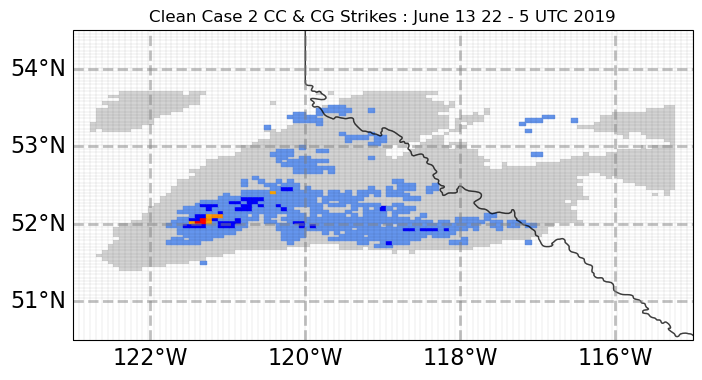

In [121]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean2, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean2, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean2)


# Make figure larger

plt.xlim([-123, -115])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean2_grid_corners_df["max_lat"])
lonlines = np.unique(clean2_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -122,  -120,  -118, -116])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 2 CC & CG Strikes : June 13 22 - 5 UTC 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [122]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean2.min_lat)
bt_max_lat = np.max(bt_clean2.max_lat)
bt_min_lon = np.min(bt_clean2.min_lon)
bt_max_lon = np.max(bt_clean2.max_lon)

grid_clean2_split_cloud
grid_clean2_split_ground

grid_select = grid_clean2_split_cloud.loc[(grid_clean2_split_cloud.min_lat >= bt_min_lat) & (grid_clean2_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean2_split_cloud.min_lon >= bt_min_lon) & (grid_clean2_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_cloud = []
color_lt_clean2_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean2_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean2_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean2_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean2_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean2_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean2_split_ground.loc[(grid_clean2_split_ground.min_lat >= bt_min_lat) & (grid_clean2_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean2_split_ground.min_lon >= bt_min_lon) & (grid_clean2_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_ground = []
color_lt_clean2_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean2_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean2_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean2_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean2_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean2_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean2_split_cccg.loc[(grid_clean2_split_cccg.min_lat >= bt_min_lat) & (grid_clean2_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean2_split_cccg.min_lon >= bt_min_lon) & (grid_clean2_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_cccg = []
color_lt_clean2_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean2_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean2_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean2_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean2_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean2_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean2_percpos.loc[(grid_clean2_percpos.min_lat >= bt_min_lat) & (grid_clean2_percpos.max_lat <= bt_max_lat) &
                              (grid_clean2_percpos.min_lon >= bt_min_lon) & (grid_clean2_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean2_percpos = []
color_lt_clean2_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean2_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean2_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean2_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean2_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean2_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean2_percpos.append("red")

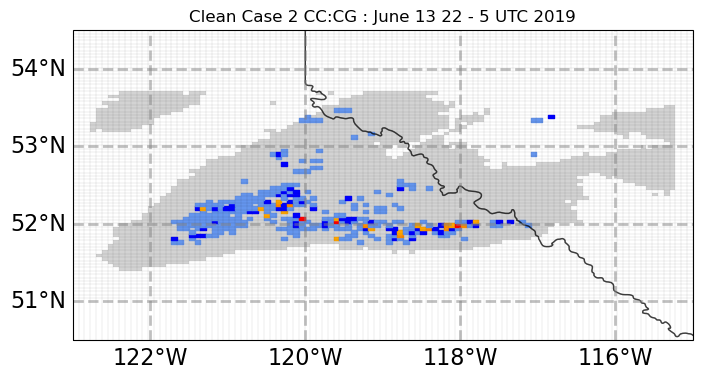

In [123]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean2, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean2_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean2_cccg)


# Make figure larger

plt.xlim([-123, -115])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean2_grid_corners_df["max_lat"])
lonlines = np.unique(clean2_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -122,  -120,  -118, -116])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 2 CC:CG : June 13 22 - 5 UTC 2019")

plt.show()

## process data

In [124]:
# (bt_clean2.tlat >= 51) & (bt_clean2.tlat <= 54) & (bt_clean2.tlon >= -123) & (bt_clean2.tlon <= -115)

#c = grid_clean2_split_conc.loc[(grid_clean2_split_conc.hour == 22) & ((grid_clean2_split_conc["C or G"] == "C") | (grid_clean2_split_conc["C or G"] == "NaN"))]["lt_count"]

c = grid_clean2_split_conc.loc[(grid_clean2_split_conc.hour == 22) & (grid_clean2_split_conc["C or G"] != "G")]["lt_count"]
a = np.sum(grid_clean2_split_conc[(grid_clean2_split_conc.hour == 22)]["bt_area_km2"])
#a = np.sum(a)
a

grid_clean2_split_conc["C or G"].values
a



2675

In [125]:
hours = [22, 23, 0, 1, 2, 3, 4, 5]


clean2_cloud_density_array = []
clean2_ground_density_array = []
clean2_total_density_array = []

clean2_cloud_log_density_array = []
clean2_ground_log_density_array = []
clean2_total_log_density_array = []

for i in range(len(hours)): 
        print(i)
        # ----------------
        # split strikes
        strikes_clean2_split = grid_clean2_split_conc.loc[(grid_clean2_split_conc.hour == hours[i])]
        
        strikes_clean2 = grid_clean2_conc.loc[(grid_clean2_conc.hour == hours[i])]

        cloud_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean2["bt_area_km2"])
        
        clean2_cloud_density = list(cloud_count/area * 10000)
        clean2_cloud_density = np.nan_to_num(clean2_cloud_density)
        clean2_cloud_density_array.append(clean2_cloud_density)
        cloud_log = np.log(clean2_cloud_density + 0.15735641227380015)
        clean2_cloud_log_density_array.append(cloud_log)
        
        
        clean2_ground_density = list(ground_count/area * 10000)
        clean2_ground_density = np.nan_to_num(clean2_ground_density)
        clean2_ground_density_array.append(clean2_ground_density)  
        ground_log = np.log(clean2_ground_density + 0.15735641227380015)
        clean2_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean2["lt_count"]
        
        clean2_total_density = list(total_count/area * 10000)
        clean2_total_density = np.nan_to_num(clean2_total_density)
        clean2_total_density_array.append(clean2_total_density)
        total_log = np.log(clean2_total_density + 0.15735641227380015)
        clean2_total_log_density_array.append(total_log)
        
        
clean2_cloud_density_flat = [item for sublist in clean2_cloud_density_array for item in sublist]
clean2_ground_density_flat = [item for sublist in clean2_ground_density_array for item in sublist]
clean2_total_density_flat = [item for sublist in clean2_total_density_array for item in sublist]



0
1
2
3
4
5
6
7


In [126]:
clean2_cloud_halfmin = []
for i in range(0, 8): 
    if len([x for x in clean2_cloud_density_array[i] if x != 0]) > 0: 
        clean2_cloud_halfmin.append(np.min([x for x in clean2_cloud_density_array[i] if x != 0]) / 2)

clean2_ground_halfmin = []
for i in range(0, 8): 
    if len([x for x in clean2_ground_density_array[i] if x != 0]) > 0: 
        clean2_ground_halfmin.append(np.min([x for x in clean2_ground_density_array[i] if x != 0]) / 2)

clean2_total_halfmin = []
for i in range(0, 8): 
    if len([x for x in clean2_total_density_array[i] if x != 0]) > 0: 
        clean2_total_halfmin.append(np.min([x for x in clean2_total_density_array[i] if x != 0]) / 2)

clean2_cloud_totmin = np.min(clean2_cloud_halfmin)
clean2_ground_totmin = np.min(clean2_ground_halfmin)
clean2_total_totmin = np.min(clean2_total_halfmin)

clean2_cloud_totmin, clean2_ground_totmin, clean2_total_totmin

(0.15735641227380015, 0.15735641227380015, 0.15735641227380015)

### boxplot

In [127]:
clean2_cloud_max = []
for i in range(0, 8): 
    clean2_cloud_max.append(np.max(clean2_cloud_log_density_array[i]))

clean2_ground_max = []
for j in range(0, 8): 
    clean2_ground_max.append(np.max(clean2_ground_log_density_array[j]))

clean2_cloud_max, clean2_ground_max

([2.0418079774064495,
  0.29587345561839673,
  3.9180672820700493,
  1.9982841429089917,
  1.9155769399780396,
  1.8143197414882288,
  0.833834142900999,
  2.208190256862019],
 [1.3688789183034142,
  -1.8492419046414175,
  4.190360087761053,
  2.1235543386885225,
  1.5687837854571804,
  0.9839714394147986,
  0.6650905025113157,
  0.6656382410511862])

[Text(0, 0, '22:00'),
 Text(2, 0, '23:00'),
 Text(4, 0, '00:00'),
 Text(6, 0, '01:00'),
 Text(8, 0, '02:00'),
 Text(10, 0, '03:00'),
 Text(12, 0, '04:00'),
 Text(14, 0, '05:00'),
 Text(1, 0, ''),
 Text(3, 0, ''),
 Text(5, 0, ''),
 Text(7, 0, ''),
 Text(9, 0, ''),
 Text(11, 0, ''),
 Text(13, 0, ''),
 Text(15, 0, '')]

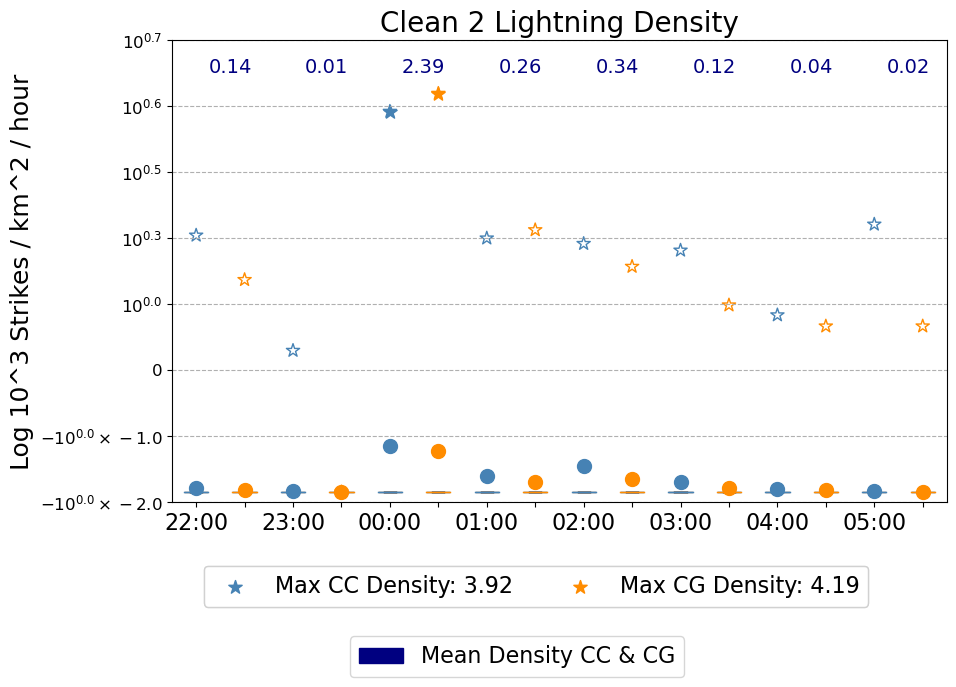

In [128]:
fig, ax = plt.subplots(figsize = (10,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 2 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-2, 5)
# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)

box4_1 = ax.boxplot(clean2_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10, 12, 14]) 


box4_2 = ax.boxplot(clean2_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11, 13, 15]) 

ax.scatter(np.arange(0, 16, 2), clean2_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(4, clean2_cloud_max[2], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean2_cloud_max))) 

ax.scatter(np.arange(1, 17, 2), clean2_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(5, clean2_ground_max[2], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean2_ground_max))) 

x = np.arange(0.25, 15.25, 2)
for i in range(0, 8, 1):
    ax.annotate("{:.2f}".format(np.mean(clean2_total_density_array[i])), (x[i], 4.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["22:00", "23:00", "00:00", "01:00", "02:00", "03:00", "04:00", "05:00", 
          "", "", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min intervals

In [129]:
# grid_clean2_int = pd.read_csv("/data2/edworak/data/clean2_lightning_bt.csv", sep='\t')

hours1 = [22, 23, 0, 1, 2, 3, 4, 5]
mins1 = range(0, 60, 10)

clean2_cloud_density_array = []
clean2_ground_density_array = []
clean2_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean2_split = grid_clean2_int_split.loc[(grid_clean2_int_split.hour == hours1[i]) & (grid_clean2_int_split.minute >= mins1[j]) & (grid_clean2_int_split.minute <= mins1[j] + 9)]        
        strikes_clean2 = grid_clean2_int.loc[(grid_clean2_int.hour == hours1[i]) & (grid_clean2_int.minute >= mins1[j]) & (grid_clean2_int.minute <= mins1[j] + 9)]        
        bt_clean2 = grid_clean2_int_bt.loc[(grid_clean2_int_bt.hour == hours1[i]) & (grid_clean2_int_bt.minute >= mins1[j]) & (grid_clean2_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean2_split) >= 1: 
            #clean2_cloud_array.append(np.array(strikes_clean2[(strikes_clean2["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean2_split[(strikes_clean2_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean2["bt_area_km2"])

            clean2_cloud_density = list(cloud_count/area * 10000)
            clean2_cloud_density = np.nan_to_num(clean2_cloud_density)
            clean2_cloud_density_array.append(np.array(clean2_cloud_density))

            clean2_ground_density = list(ground_count/area * 10000)
            clean2_ground_density = np.nan_to_num(clean2_ground_density)
            clean2_ground_density_array.append(np.array(clean2_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean2["lt_count"]

            clean2_total_density = list(total_count/area * 10000)
            clean2_total_density = np.nan_to_num(clean2_total_density)
            clean2_total_density_array.append(np.array(clean2_total_density))

clean2_cloud_density_flat = [item for sublist in clean2_cloud_density_array for item in sublist]
clean2_ground_density_flat = [item for sublist in clean2_ground_density_array for item in sublist]
clean2_total_density_flat = [item for sublist in clean2_total_density_array for item in sublist]
clean2_cloud_density_array


[array([7.54716981, 3.77358491, 3.77358491, 7.54716981, 3.77358491,
        3.77358491, 3.77358491, 3.77358491]),
 array([3.47826087, 3.47826087, 3.47826087, 3.47826087, 6.95652174]),
 array([2.91970803, 5.83941606]),
 array([5.36912752]),
 array([2.20994475, 2.20994475, 2.20994475]),
 array([1.94174757, 1.94174757, 1.94174757]),
 array([1.70212766, 1.70212766, 3.40425532, 1.70212766, 1.70212766,
        1.70212766]),
 array([1.44927536, 5.79710145, 2.89855072, 2.89855072, 1.44927536,
        2.89855072, 2.89855072, 1.44927536, 2.89855072, 1.44927536,
        1.44927536, 2.89855072, 1.44927536, 1.44927536, 2.89855072,
        1.44927536, 2.89855072, 1.44927536, 1.44927536, 1.44927536,
        1.44927536, 5.79710145, 1.44927536, 1.44927536, 2.89855072,
        1.44927536, 1.44927536, 4.34782609, 1.44927536, 2.89855072,
        1.44927536, 4.34782609, 4.34782609, 1.44927536, 1.44927536,
        1.44927536, 2.89855072, 1.44927536, 1.44927536, 2.89855072,
        7.24637681, 2.89855072, 1.

# Clean Case 3 :  22 UTC June 26 (177) - 4 UTC June 27 (178)
#### 56.2 : 58 N  , -124 : -121 W 


In [130]:
correct_clean3 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean3.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean3["lt_count"] = np.zeros((6036))
np.unique(correct_clean3.hour)

array([ 0,  1,  2,  3,  4, 22, 23])

In [131]:
lat_vals = range(56, 60)
lon_vals = range(-124, -120)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [132]:
# Define the latitude and longitude values for your clean3_grid (assuming evenly spaced)
latitude_values = np.linspace(56, 60, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-124, -120, num=len(ds_out_lon_flat)) 

# Calculate the clean3_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean3_grid corners
clean3_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean3_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean3_grid cell's corners to the list
        clean3_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean3_grid_corners list now contains the corner coordinates of each clean3_grid cell
# Each element of the list is a list of four tuples representing the corners
clean3_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean3_grid_corners_df = clean3_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean3_grid_corners_df = clean3_grid_corners_df.drop_duplicates(keep='first') 
clean3_grid_corners_df

min_lat    max_lat     min_lon     max_lon
0     56.000000  56.058824 -124.000000 -123.891892
1     56.000000  56.058824 -123.891892 -123.783784
2     56.000000  56.058824 -123.783784 -123.675676
3     56.000000  56.058824 -123.675676 -123.567568
4     56.000000  56.058824 -123.567568 -123.459459
...         ...        ...         ...         ...
2511  59.941176  60.000000 -120.540541 -120.432432
2512  59.941176  60.000000 -120.432432 -120.324324
2513  59.941176  60.000000 -120.324324 -120.216216
2514  59.941176  60.000000 -120.216216 -120.108108
2515  59.941176  60.000000 -120.108108 -120.000000

[2516 rows x 4 columns]

In [133]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean3)): 
    # print(i)
    findlat = correct_clean3.lat[i]
    findlon = correct_clean3.lon[i]

    findcorners = clean3_grid_corners_df.loc[(clean3_grid_corners_df.min_lat <= findlat) & (clean3_grid_corners_df.max_lat >= findlat) & 
                                     (clean3_grid_corners_df.min_lon <= findlon) & (clean3_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean3["min_lat"] = min_lat_array
correct_clean3["max_lat"] = max_lat_array
correct_clean3["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean3["min_lon"] = min_lon_array
correct_clean3["max_lon"] = max_lon_array
correct_clean3["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean3



year  month  day  hour  minute     second      lat       lon  \
0     2019      6   27     4      40   8.573169  56.3034 -122.0090   
1     2019      6   27     1       0   6.247735  57.1464 -122.5003   
2     2019      6   26    23      50   6.228158  57.5470 -122.3078   
3     2019      6   27     1      10   7.758740  57.2761 -122.7851   
4     2019      6   27     0       0   4.002557  57.4358 -121.9304   
...    ...    ...  ...   ...     ...        ...      ...       ...   
6031  2019      6   27     1      39  35.800777  57.2286 -122.7161   
6032  2019      6   27     1      39  49.310410  57.3504 -122.1211   
6033  2019      6   27     1      39  49.310907  57.3593 -122.0821   
6034  2019      6   27     1      39  49.311503  57.3591 -122.0970   
6035  2019      6   27     1      39  53.404651  57.2956 -122.8948   

      peak current C or G  ...       tlat        tlon  distance(km)  lt_count  \
0              5.2      C  ...  56.203061 -122.005912         5.924       0.0   
1              2.6      C  ...  57.125391 -122.490925         1.631       0.0   
2             14.9      C  ...  57.247478 -122.135201        26.147       0.0   
3              2.9      C  ...  57.257361 -122.774446         1.636       0.0   
4              7.5      C  ...  57.292351 -122.152865        26.144       0.0   
...            ...    ...  ...        ...         ...           ...       ...   
6031           3.3      C  ...  57.215442 -122.754374         4.329       0.0   
6032           5.3      C  ...  57.056114 -122.110061        17.440       0.0   
6033           5.5      C  ...  57.393969 -121.920714        18.061       0.0   
6034           9.5      G  ...  57.056114 -122.110061        17.964       0.0   
6035           8.9      C  ...  57.209912 -122.871154         5.803       0.0   

        min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  
0     56.294118  56.352941  56.323529 -122.054054 -121.945946 -122.000000  
1     57.117647  57.176471  57.147059 -122.594595 -122.486486 -122.540541  
2     57.529412  57.588235  57.558824 -122.378378 -122.270270 -122.324324  
3     57.235294  57.294118  57.264706 -122.810811 -122.702703 -122.756757  
4     57.411765  57.470588  57.441176 -121.945946 -121.837838 -121.891892  
...         ...        ...        ...         ...         ...         ...  
6031  57.176471  57.235294  57.205882 -122.810811 -122.702703 -122.756757  
6032  57.294118  57.352941  57.323529 -122.162162 -122.054054 -122.108108  
6033  57.352941  57.411765  57.382353 -122.162162 -122.054054 -122.108108  
6034  57.352941  57.411765  57.382353 -122.162162 -122.054054 -122.108108  
6035  57.294118  57.352941  57.323529 -122.918919 -122.810811 -122.864865  

[6036 rows x 21 columns]

In [134]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean3_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_split = grid_clean3_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean3_split = grid_clean3_split.T.drop_duplicates().T
grid_clean3_split.lt_count = pd.to_numeric(grid_clean3_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean3_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_split_all = grid_clean3_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean3_split_all = grid_clean3_split_all.T.drop_duplicates().T
grid_clean3_split_all.lt_count = pd.to_numeric(grid_clean3_split_all.lt_count)
grid_clean3_split_cloud = grid_clean3_split_all.loc[grid_clean3_split_all["C or G"] == "C"]
grid_clean3_split_ground = grid_clean3_split_all.loc[grid_clean3_split_all["C or G"] == "G"]


grid_clean3_split_cccg = pd.merge(grid_clean3_split_cloud, grid_clean3_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean3_split_cccg.loc[(grid_clean3_split_cccg.lt_count_y >= 0)]
grid_clean3_split_cccg["CC:CG"] = grid_clean3_split_cccg.lt_count_x / grid_clean3_split_cccg.lt_count_y
grid_clean3_split_cccg = grid_clean3_split_cccg.loc[grid_clean3_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean3_ground = correct_clean3.loc[correct_clean3["C or G"] != "C"]
grouped_lt = correct_clean3_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean3_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean3_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_percpos = grid_clean3_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean3_percpos = grid_clean3_percpos.T.drop_duplicates().T
grid_clean3_percpos.lt_count = pd.to_numeric(grid_clean3_percpos.lt_count)
grid_clean3_percpos_pos = grid_clean3_percpos.loc[grid_clean3_percpos["peak current"] > 0]

grid_clean3_percpos = pd.merge(grid_clean3_split_ground, grid_clean3_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean3_percpos.lt_count_y = np.nan_to_num(grid_clean3_percpos.lt_count_y)
grid_clean3_percpos["perc_pos"] = (grid_clean3_percpos.lt_count_y / grid_clean3_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean3 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3 = grid_clean3[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean3 = grid_clean3.T.drop_duplicates().T
grid_clean3.lt_count = pd.to_numeric(grid_clean3.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean3_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_all = grid_clean3_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean3_all = grid_clean3_all.T.drop_duplicates().T
grid_clean3_all.lt_count = pd.to_numeric(grid_clean3_all.lt_count)
grid_clean3_all

# --------------------------------------------------------------

grid_clean3_percpos


min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  \
0    56.176471  56.235294  56.205882 -122.162162 -122.054054 -122.108108   
1    56.176471  56.235294  56.205882 -121.189189 -121.081081 -121.135135   
2    56.176471  56.235294  56.205882 -121.189189 -121.081081 -121.135135   
3    56.176471  56.235294  56.205882 -121.189189 -121.081081 -121.135135   
4    56.176471  56.235294  56.205882 -121.081081 -120.972973 -121.027027   
..         ...        ...        ...         ...         ...         ...   
685  57.882353  57.941176  57.911765 -121.405405 -121.297297 -121.351351   
686  57.882353  57.941176  57.911765 -121.405405 -121.297297 -121.351351   
687  57.941176       58.0  57.970588 -121.513514 -121.405405 -121.459459   
688  57.941176       58.0  57.970588 -121.513514 -121.405405 -121.459459   
689  57.941176       58.0  57.970588 -121.405405 -121.297297 -121.351351   

    C or G  CMI_C14_x  lt_count_x  CMI_C14_y  lt_count_y    perc_pos  
0        G  -54.62506           1        NaN         0.0    0.000000  
1        G  -50.25595           3 -50.255950         1.0   33.333333  
2        G  -50.25595           3 -50.255950         1.0   33.333333  
3        G  -50.25595           3 -50.255950         1.0   33.333333  
4        G  -50.25595           1 -50.255950         1.0  100.000000  
..     ...        ...         ...        ...         ...         ...  
685      G -51.393127           7 -50.854460         1.0   14.285714  
686      G -51.393127           7 -50.255950         1.0   14.285714  
687      G -51.393127           5 -51.393127         1.0   20.000000  
688      G -51.393127           5 -51.393127         1.0   20.000000  
689      G  -52.29088           4        NaN         0.0    0.000000  

[690 rows x 12 columns]

In [135]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean3_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_int_split = grid_clean3_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean3_int_split = grid_clean3_int_split.T.drop_duplicates().T
grid_clean3_int_split.lt_count = pd.to_numeric(grid_clean3_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean3.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean3_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean3_int = grid_clean3_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean3_int = grid_clean3_int.T.drop_duplicates().T
grid_clean3_int.lt_count = pd.to_numeric(grid_clean3_int.lt_count)

grid_clean3_int_split
grid_clean3_int_split

hour minute    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0       4     40  56.176471  56.235294  56.205882 -122.162162 -122.054054   
1       4     46  56.176471  56.235294  56.205882 -122.054054 -121.945946   
2       2      4  56.176471  56.235294  56.205882 -121.189189 -121.081081   
3       2      6  56.176471  56.235294  56.205882 -121.189189 -121.081081   
4       2      1  56.176471  56.235294  56.205882 -121.081081 -120.972973   
...   ...    ...        ...        ...        ...         ...         ...   
3279    0     17  57.941176       58.0  57.970588 -121.405405 -121.297297   
3280    0     21  57.941176       58.0  57.970588 -121.405405 -121.297297   
3281    0     37  57.941176       58.0  57.970588 -121.405405 -121.297297   
3282   23     17  57.941176       58.0  57.970588 -121.405405 -121.297297   
3283   23     17  57.941176       58.0  57.970588 -121.405405 -121.297297   

        cent_lon C or G    CMI_C14  lt_count  
0    -122.108108      G  -54.62506         1  
1         -122.0      C    -53.847         1  
2    -121.135135      G  -50.25595         1  
3    -121.135135      G  -50.25595         2  
4    -121.027027      G  -50.25595         1  
...          ...    ...        ...       ...  
3279 -121.351351      C -51.393127         1  
3280 -121.351351      C  -50.25595         1  
3281 -121.351351      G  -50.85446         1  
3282 -121.351351      C  -52.29088         5  
3283 -121.351351      G  -52.29088         3  

[3284 rows x 11 columns]

### brightness temp

In [136]:
bt_clean3 = pd.read_csv("/data2/edworak/data/correct_bt_clean3.nc")
bt_clean3 = bt_clean3.loc[(bt_clean3.tlat >= 56.2) & (bt_clean3.tlat <= 60) 
                          & (bt_clean3.tlon >= -124) & (bt_clean3.tlon <= -121)]
bt_clean3 = bt_clean3.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean3)): 
    findlat = bt_clean3.tlat[i]
    findlon = bt_clean3.tlon[i]

    findcorners = clean3_grid_corners_df.loc[(clean3_grid_corners_df.min_lat <= findlat) & (clean3_grid_corners_df.max_lat >= findlat) & 
                                     (clean3_grid_corners_df.min_lon <= findlon) & (clean3_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean3["min_lat"] = min_lat_array_flat
bt_clean3["max_lat"] = max_lat_array_flat
bt_clean3["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean3["min_lon"] = min_lon_array_flat
bt_clean3["max_lon"] = max_lon_array_flat
bt_clean3["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean3


index  Unnamed: 0  year  month  day  hour  minute       tlat  \
0          2           2  2019      6   26    23      25  57.604744   
1          5           5  2019      6   27     0      35  57.327174   
2          6           6  2019      6   26    23      45  57.294479   
3          7           7  2019      6   27     1      45  57.342979   
4          8           8  2019      6   27     1      35  57.532035   
...      ...         ...   ...    ...  ...   ...     ...        ...   
11519  12487       12487  2019      6   27     2      35  56.241712   
11520  12491       12491  2019      6   27     2      45  56.233773   
11521  12492       12492  2019      6   27     2      35  56.243185   
11522  12496       12496  2019      6   27     2      45  56.235105   
11523  12497       12497  2019      6   27     2      35  56.244897   

             tlon    CMI_C14    min_lat    max_lat   cent_lat     min_lon  \
0     -123.491133 -50.375656  57.588235  57.647059  57.617647 -123.567568   
1     -122.176525 -51.692383  57.294118  57.352941  57.323529 -122.270270   
2     -121.960917 -53.009094  57.294118  57.352941  57.323529 -122.054054   
3     -121.945244 -50.555206  57.294118  57.352941  57.323529 -121.945946   
4     -121.819350 -50.375656  57.529412  57.588235  57.558824 -121.837838   
...           ...        ...        ...        ...        ...         ...   
11519 -122.100296 -52.410583  56.235294  56.294118  56.264706 -122.162162   
11520 -122.252642 -54.924316  56.176471  56.235294  56.205882 -122.270270   
11521 -122.062486 -52.829530  56.235294  56.294118  56.264706 -122.162162   
11522 -122.214942 -53.847000  56.176471  56.235294  56.205882 -122.270270   
11523 -122.024526 -51.752228  56.235294  56.294118  56.264706 -122.054054   

          max_lon    cent_lon  
0     -123.459459 -123.513514  
1     -122.162162 -122.216216  
2     -121.945946 -122.000000  
3     -121.837838 -121.891892  
4     -121.729730 -121.783784  
...           ...         ...  
11519 -122.054054 -122.108108  
11520 -122.162162 -122.216216  
11521 -122.054054 -122.108108  
11522 -122.162162 -122.216216  
11523 -121.945946 -122.000000  

[11524 rows x 16 columns]

In [137]:
## group the bt data to get area at each hour
grouped_clean3_bt = bt_clean3.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean3_bt = grouped_clean3_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean3_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean3_bt["bt_area_km2"] = grouped_clean3_bt["bt_area_km2"] * 25
grid_clean3_bt = grouped_clean3_bt

grid_clean3_bt

min_lat    max_lat     min_lon     max_lon  hour  bt_area_km2
0     56.176471  56.235294 -123.891892 -123.783784     2           25
1     56.176471  56.235294 -123.891892 -123.783784     3           25
2     56.176471  56.235294 -123.783784 -123.675676     2           25
3     56.176471  56.235294 -123.783784 -123.675676     3           25
4     56.176471  56.235294 -123.675676 -123.567568     2           25
...         ...        ...         ...         ...   ...          ...
1130  57.588235  57.647059 -121.729730 -121.621622     0           25
1131  57.588235  57.647059 -121.729730 -121.621622     1           25
1132  57.588235  57.647059 -121.621622 -121.513514     0           25
1133  57.588235  57.647059 -121.621622 -121.513514     1           25
1134  57.588235  57.647059 -121.297297 -121.189189    22           25

[1135 rows x 6 columns]

In [138]:
## group the bt data to get area at each hour
grouped_clean3_int_bt = bt_clean3.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean3_int_bt = grouped_clean3_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean3_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute','bt_area_km2']
grouped_clean3_int_bt["bt_area_km2"] =  25
grid_clean3_int_bt = grouped_clean3_int_bt

grid_clean3_int_bt

min_lat    max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0     56.176471  56.235294 -123.891892 -123.783784     2      45           25
1     56.176471  56.235294 -123.891892 -123.783784     3      15           25
2     56.176471  56.235294 -123.783784 -123.675676     2      45           25
3     56.176471  56.235294 -123.783784 -123.675676     3      15           25
4     56.176471  56.235294 -123.675676 -123.567568     2      45           25
...         ...        ...         ...         ...   ...     ...          ...
3716  57.588235  57.647059 -121.729730 -121.621622     0      55           25
3717  57.588235  57.647059 -121.729730 -121.621622     1       5           25
3718  57.588235  57.647059 -121.621622 -121.513514     0      55           25
3719  57.588235  57.647059 -121.621622 -121.513514     1       5           25
3720  57.588235  57.647059 -121.297297 -121.189189    22      55           25

[3721 rows x 7 columns]

### combine datasets

In [139]:
grid_clean3_conc = pd.merge(grid_clean3_bt, grid_clean3[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean3_conc['lt_count'] = np.nan_to_num(grid_clean3_conc.lt_count)

grid_clean3_split_conc = pd.merge(grid_clean3_bt, grid_clean3_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean3_split_conc['lt_count'] = np.nan_to_num(grid_clean3_split_conc.lt_count)
grid_clean3_split_conc

min_lat    max_lat     min_lon     max_lon hour  bt_area_km2  \
0     56.176471  56.235294 -123.891892 -123.783784    2           25   
1     56.176471  56.235294 -123.891892 -123.783784    3           25   
2     56.176471  56.235294 -123.783784 -123.675676    2           25   
3     56.176471  56.235294 -123.783784 -123.675676    3           25   
4     56.176471  56.235294 -123.675676 -123.567568    2           25   
...         ...        ...         ...         ...  ...          ...   
1223  57.588235  57.647059  -121.72973 -121.621622    1           25   
1224  57.588235  57.647059 -121.621622 -121.513514    0           25   
1225  57.588235  57.647059 -121.621622 -121.513514    1           25   
1226  57.588235  57.647059 -121.621622 -121.513514    1           25   
1227  57.588235  57.647059 -121.297297 -121.189189   22           25   

      lt_count C or G  
0          0.0    NaN  
1          0.0    NaN  
2          0.0    NaN  
3          0.0    NaN  
4          0.0    NaN  
...        ...    ...  
1223       3.0      G  
1224       0.0    NaN  
1225      14.0      C  
1226       8.0      G  
1227       0.0    NaN  

[1228 rows x 8 columns]

### map

In [140]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean3_select = bt_clean3
bt_clean3_select = bt_clean3_select.reset_index()

patches_bt_clean3 = []

for i in range(len(bt_clean3_select)):
    y = np.array([[bt_clean3_select.min_lon[i], bt_clean3_select.min_lat[i]], [bt_clean3_select.max_lon[i], bt_clean3_select.min_lat[i]], 
                  [bt_clean3_select.max_lon[i], bt_clean3_select.max_lat[i]], [bt_clean3_select.min_lon[i], bt_clean3_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean3.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 

bt_min_lat = np.min(bt_clean3.min_lat)
bt_max_lat = np.max(bt_clean3.max_lat)
bt_min_lon = np.min(bt_clean3.min_lon)
bt_max_lon = np.max(bt_clean3.max_lon)

grid_select = grid_clean3_all.loc[(grid_clean3_all.min_lat >= bt_min_lat) & (grid_clean3_all.max_lat <= bt_max_lat) &
                              (grid_clean3_all.min_lon >= bt_min_lon) & (grid_clean3_all.max_lon <= bt_max_lon)]


grid_select = grid_select.reset_index()

patches_lt_clean3 = []
color_lt_clean3 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3.append(polygon)
    
    x = grid_select.lt_count[i]
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean3.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean3.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean3.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean3.append("darkorange")
    if (x > 140): 
        color_lt_clean3.append("red")

    
    

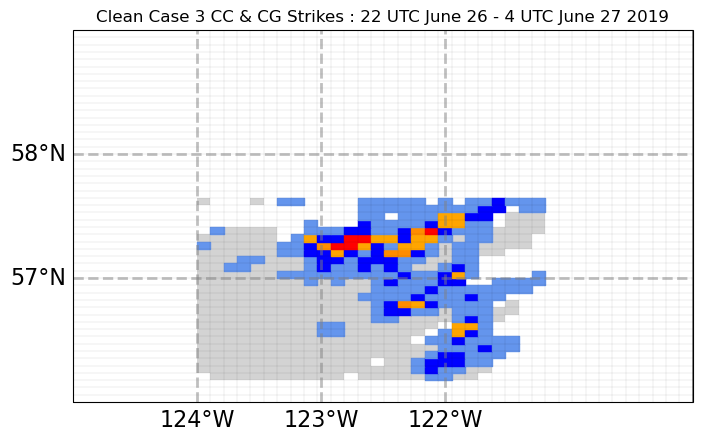

In [141]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean3, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean3, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean3)


# Make figure larger

plt.xlim([-125, -120])
plt.ylim([56, 59])

latlines = np.unique(clean3_grid_corners_df["max_lat"])
lonlines = np.unique(clean3_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -124,  -123,  -122])
gl.ylocator = mticker.FixedLocator([56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 3 CC & CG Strikes : 22 UTC June 26 - 4 UTC June 27 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [142]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean3.min_lat)
bt_max_lat = np.max(bt_clean3.max_lat)
bt_min_lon = np.min(bt_clean3.min_lon)
bt_max_lon = np.max(bt_clean3.max_lon)

grid_clean3_split_cloud
grid_clean3_split_ground

grid_select = grid_clean3_split_cloud.loc[(grid_clean3_split_cloud.min_lat >= bt_min_lat) & (grid_clean3_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean3_split_cloud.min_lon >= bt_min_lon) & (grid_clean3_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_cloud = []
color_lt_clean3_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean3_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean3_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean3_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean3_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean3_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean3_split_ground.loc[(grid_clean3_split_ground.min_lat >= bt_min_lat) & (grid_clean3_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean3_split_ground.min_lon >= bt_min_lon) & (grid_clean3_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_ground = []
color_lt_clean3_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean3_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean3_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean3_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean3_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean3_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean3_split_cccg.loc[(grid_clean3_split_cccg.min_lat >= bt_min_lat) & (grid_clean3_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean3_split_cccg.min_lon >= bt_min_lon) & (grid_clean3_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_cccg = []
color_lt_clean3_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean3_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean3_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean3_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean3_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean3_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean3_percpos.loc[(grid_clean3_percpos.min_lat >= bt_min_lat) & (grid_clean3_percpos.max_lat <= bt_max_lat) &
                              (grid_clean3_percpos.min_lon >= bt_min_lon) & (grid_clean3_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean3_percpos = []
color_lt_clean3_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean3_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean3_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean3_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean3_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean3_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean3_percpos.append("red")

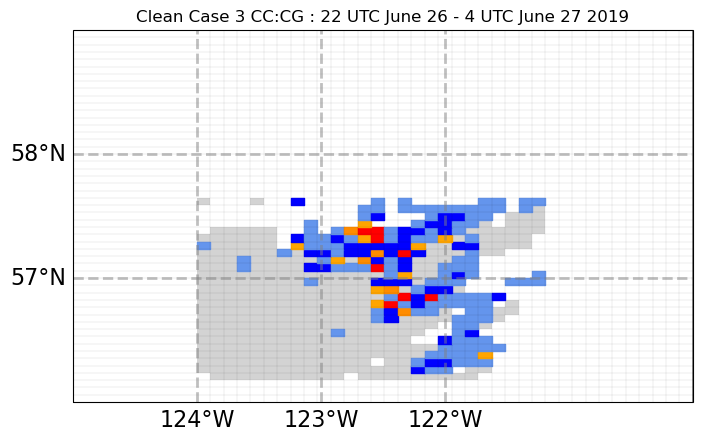

In [143]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean3, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean3_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean3_cccg)


# Make figure larger

plt.xlim([-125, -120])
plt.ylim([56, 59])

latlines = np.unique(clean3_grid_corners_df["max_lat"])
lonlines = np.unique(clean3_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -124,  -123,  -122])
gl.ylocator = mticker.FixedLocator([56, 57, 58, 59])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean Case 3 CC:CG : 22 UTC June 26 - 4 UTC June 27 2019")

plt.show()

## process data

In [144]:
hours = [22, 23, 0, 1, 2, 3, 4]


clean3_cloud_density_array = []
clean3_ground_density_array = []
clean3_total_density_array = []

clean3_cloud_log_density_array = []
clean3_ground_log_density_array = []
clean3_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean3_split = grid_clean3_split_conc.loc[(grid_clean3_split_conc.hour == hours[i])]
        strikes_clean3 = grid_clean3_conc.loc[(grid_clean3_conc.hour == hours[i])]

        cloud_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean3["bt_area_km2"])
        
        clean3_cloud_density = list(cloud_count/area * 10000)
        clean3_cloud_density = np.nan_to_num(clean3_cloud_density)
        clean3_cloud_density_array.append(clean3_cloud_density)
        cloud_log = np.log(clean3_cloud_density + 0.7067137809187279)
        clean3_cloud_log_density_array.append(cloud_log)
        
        
        clean3_ground_density = list(ground_count/area * 10000)
        clean3_ground_density = np.nan_to_num(clean3_ground_density)
        clean3_ground_density_array.append(clean3_ground_density)  
        ground_log = np.log(clean3_ground_density + 0.7067137809187279)
        clean3_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean3["lt_count"]
        
        clean3_total_density = list(total_count/area * 10000)
        clean3_total_density = np.nan_to_num(clean3_total_density)
        clean3_total_density_array.append(clean3_total_density)
        total_log = np.log(clean3_total_density + 0.7067137809187279)
        clean3_total_log_density_array.append(total_log)
        
        
clean3_cloud_density_flat = [item for sublist in clean3_cloud_density_array for item in sublist]
clean3_ground_density_flat = [item for sublist in clean3_ground_density_array for item in sublist]
clean3_total_density_flat = [item for sublist in clean3_total_density_array for item in sublist]



In [145]:
clean3_cloud_halfmin = []
for i in range(0, 7): 
    if len([x for x in clean3_cloud_density_array[i] if x != 0]) > 0: 
        clean3_cloud_halfmin.append(np.min([x for x in clean3_cloud_density_array[i] if x != 0]) / 2)

clean3_ground_halfmin = []
for i in range(0, 7): 
    if len([x for x in clean3_ground_density_array[i] if x != 0]) > 0: 
        clean3_ground_halfmin.append(np.min([x for x in clean3_ground_density_array[i] if x != 0]) / 2)

clean3_total_halfmin = []
for i in range(0, 7): 
    if len([x for x in clean3_total_density_array[i] if x != 0]) > 0: 
        clean3_total_halfmin.append(np.min([x for x in clean3_total_density_array[i] if x != 0]) / 2)

clean3_cloud_totmin = np.min(clean3_cloud_halfmin)
clean3_ground_totmin = np.min(clean3_ground_halfmin)
clean3_total_totmin = np.min(clean3_total_halfmin)

clean3_cloud_totmin, clean3_ground_totmin, clean3_total_totmin

(0.7067137809187279, 0.7067137809187279, 0.7067137809187279)

### boxplot

In [146]:
clean3_cloud_max = []
for i in range(0, 7): 
    clean3_cloud_max.append(np.max(clean3_cloud_log_density_array[i]))

clean3_ground_max = []
for j in range(0, 7): 
    clean3_ground_max.append(np.max(clean3_ground_log_density_array[j]))

clean3_ground_max

[2.626223026829404,
 3.1597140397019414,
 4.057846036564225,
 4.7208220513488035,
 3.4595329586751187,
 3.4581113499872838,
 4.914055263195707]

[Text(0, 0, '22:00'),
 Text(2, 0, '23:00'),
 Text(4, 0, '00:00'),
 Text(6, 0, '01:00'),
 Text(8, 0, '02:00'),
 Text(10, 0, '03:00'),
 Text(12, 0, '04:00'),
 Text(1, 0, ''),
 Text(3, 0, ''),
 Text(5, 0, ''),
 Text(7, 0, ''),
 Text(9, 0, ''),
 Text(11, 0, ''),
 Text(13, 0, '')]

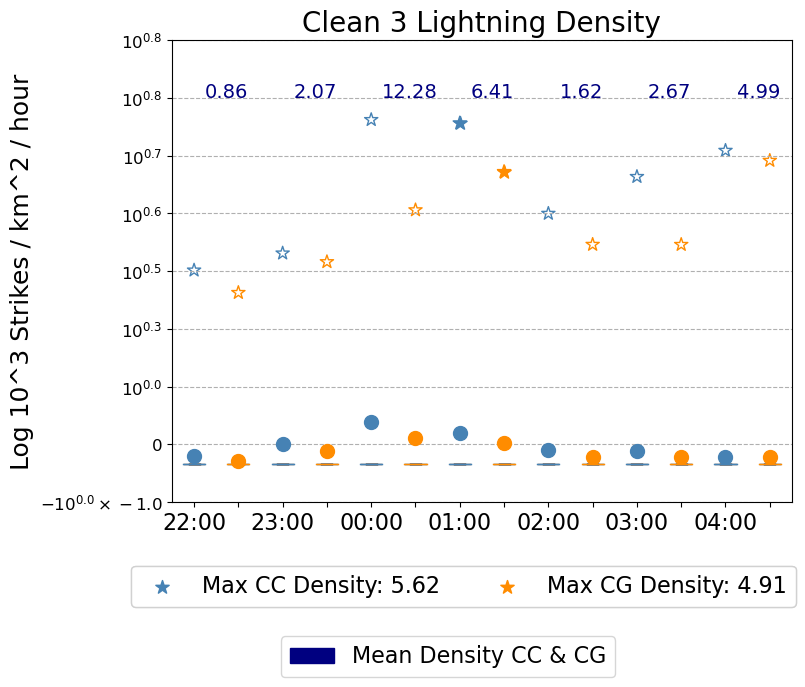

In [147]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 3 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-0.5, 6.5)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(clean3_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10, 12]) 


box4_2 = ax.boxplot(clean3_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11, 13]) 

ax.scatter(np.arange(0, 14, 2), clean3_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(6, clean3_cloud_max[3], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean3_cloud_max))) 

ax.scatter(np.arange(1, 15, 2), clean3_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(7, clean3_ground_max[3], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean3_ground_max))) 

x = np.arange(0.25, 13.25, 2)
for i in range(0, 7, 1):
    ax.annotate("{:.2f}".format(np.mean(clean3_total_density_array[i])), (x[i], 6),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["22:00", "23:00", "00:00", "01:00", "02:00", "03:00", "04:00", "", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min intervals

In [148]:


# grid_clean3_int = pd.read_csv("/data2/edworak/data/clean3_lightning_bt.csv", sep='\t')

hours1 = [22, 23, 0, 1, 2, 3]
mins1 = range(0, 60, 10)

clean3_cloud_density_array = []
clean3_ground_density_array = []
clean3_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean3_split = grid_clean3_int_split.loc[(grid_clean3_int_split.hour == hours1[i]) & (grid_clean3_int_split.minute >= mins1[j]) & (grid_clean3_int_split.minute <= mins1[j] + 9)]        
        strikes_clean3 = grid_clean3_int.loc[(grid_clean3_int.hour == hours1[i]) & (grid_clean3_int.minute >= mins1[j]) & (grid_clean3_int.minute <= mins1[j] + 9)]        
        bt_clean3 = grid_clean3_int_bt.loc[(grid_clean3_int_bt.hour == hours1[i]) & (grid_clean3_int_bt.minute >= mins1[j]) & (grid_clean3_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean3_split) >= 1: 
            #clean3_cloud_array.append(np.array(strikes_clean3[(strikes_clean3["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean3_split[(strikes_clean3_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean3['bt_area_km2'])

            clean3_cloud_density = list((cloud_count/area) * 10000)
            clean3_cloud_density = np.nan_to_num(clean3_cloud_density)
            clean3_cloud_density_array.append(np.array(clean3_cloud_density))

            clean3_ground_density = list((ground_count/area) * 10000)
            clean3_ground_density = np.nan_to_num(clean3_ground_density)
            clean3_ground_density_array.append(np.array(clean3_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean3["lt_count"]

            clean3_total_density = list((total_count/area )* 10000)
            clean3_total_density = np.nan_to_num(clean3_total_density)
            clean3_total_density_array.append(np.array(clean3_total_density))

clean3_cloud_density_flat = [item for sublist in clean3_cloud_density_array for item in sublist]
clean3_ground_density_flat = [item for sublist in clean3_ground_density_array for item in sublist]
clean3_total_density_flat = [item for sublist in clean3_total_density_array for item in sublist]
clean3_cloud_density_array


[array([26.2295082 ,  6.55737705, 26.2295082 ,  6.55737705, 13.1147541 ,
         6.55737705,  6.55737705,  6.55737705,  6.55737705,  6.55737705,
         6.55737705,  6.55737705,  6.55737705,  6.55737705,  6.55737705,
         6.55737705,  6.55737705, 13.1147541 ,  6.55737705,  6.55737705,
         6.55737705,  6.55737705,  6.55737705,  6.55737705,  6.55737705,
        13.1147541 ,  6.55737705, 19.67213115,  6.55737705,  6.55737705,
         6.55737705]),
 array([ 8.5106383 , 25.53191489,  8.5106383 ,  8.5106383 ,  8.5106383 ,
        42.55319149, 42.55319149,  8.5106383 ,  8.5106383 , 25.53191489,
         8.5106383 ,  8.5106383 ,  8.5106383 ,  8.5106383 ,  8.5106383 ,
         8.5106383 ,  8.5106383 , 17.0212766 ]),
 array([16.32653061,  8.16326531,  8.16326531, 24.48979592, 16.32653061,
         8.16326531,  8.16326531,  8.16326531, 16.32653061,  8.16326531,
         8.16326531,  8.16326531,  8.16326531, 24.48979592,  8.16326531,
         8.16326531,  8.16326531, 16.32653061,  8.16

# Clean Case 4 : 20 UTC June 27 (178) - 0 UTC June 28 (179)
#### 51 N : 55 N  , -125 W : -122.7 W 


In [149]:
correct_clean4 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean4.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean4["lt_count"] = np.zeros((1591))
np.unique(correct_clean4.hour)



array([ 0, 20, 21, 22, 23])

In [150]:
lat_vals = range(51, 56)
lon_vals = range(-125, -120)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [151]:
# Define the latitude and longitude values for your clean4_grid (assuming evenly spaced)
latitude_values = np.linspace(51, 55, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-125, -121, num=len(ds_out_lon_flat)) 

# Calculate the clean4_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean4_grid corners
clean4_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean4_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean4_grid cell's corners to the list
        clean4_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean4_grid_corners list now contains the corner coordinates of each clean4_grid cell
# Each element of the list is a list of four tuples representing the corners
clean4_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean4_grid_corners_df = clean4_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean4_grid_corners_df = clean4_grid_corners_df.drop_duplicates(keep='first') 
clean4_grid_corners_df

min_lat    max_lat     min_lon     max_lon
0     51.000000  51.043956 -125.000000 -124.928571
1     51.000000  51.043956 -124.928571 -124.857143
2     51.000000  51.043956 -124.857143 -124.785714
3     51.000000  51.043956 -124.785714 -124.714286
4     51.000000  51.043956 -124.714286 -124.642857
...         ...        ...         ...         ...
5091  54.956044  55.000000 -121.357143 -121.285714
5092  54.956044  55.000000 -121.285714 -121.214286
5093  54.956044  55.000000 -121.214286 -121.142857
5094  54.956044  55.000000 -121.142857 -121.071429
5095  54.956044  55.000000 -121.071429 -121.000000

[5096 rows x 4 columns]

In [152]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean4)): 
    # print(i)
    findlat = correct_clean4.lat[i]
    findlon = correct_clean4.lon[i]

    findcorners = clean4_grid_corners_df.loc[(clean4_grid_corners_df.min_lat <= findlat) & (clean4_grid_corners_df.max_lat >= findlat) & 
                                     (clean4_grid_corners_df.min_lon <= findlon) & (clean4_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean4["min_lat"] = min_lat_array
correct_clean4["max_lat"] = max_lat_array
correct_clean4["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean4["min_lon"] = min_lon_array
correct_clean4["max_lon"] = max_lon_array
correct_clean4["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean4



year  month  day  hour  minute     second      lat       lon  \
0     2019      6   27    22      15  27.820933  52.7611 -124.2212   
1     2019      6   27    21      40  10.809754  52.6532 -123.9421   
2     2019      6   28     0      15  39.986963  53.4829 -124.7427   
3     2019      6   27    23      30  45.996997  53.7411 -123.6676   
4     2019      6   27    23      40   8.534871  53.7351 -123.7335   
...    ...    ...  ...   ...     ...        ...      ...       ...   
1586  2019      6   28     0      38   8.525068  53.9218 -123.9140   
1587  2019      6   28     0      39  14.909820  53.5473 -124.7629   
1588  2019      6   28     0      39  14.911943  53.5450 -124.7454   
1589  2019      6   27    22      44  17.012596  52.7112 -124.8326   
1590  2019      6   28     0      39  32.694911  53.8526 -124.4818   

      peak current C or G  ...       tlat        tlon  distance(km)  lt_count  \
0              9.6      C  ...  52.771151 -124.222881         0.656       0.0   
1             -7.4      C  ...  52.662028 -123.926765         1.791       0.0   
2              4.6      C  ...  53.483316 -124.758657         1.775       0.0   
3              5.8      C  ...  53.694425 -123.706115         5.160       0.0   
4              5.1      C  ...  53.691572 -123.741656         2.837       0.0   
...            ...    ...  ...        ...         ...           ...       ...   
1586           2.7      C  ...  53.888143 -123.905783         2.279       0.0   
1587          10.7      C  ...  53.529630 -124.776356         1.869       0.0   
1588           3.8      C  ...  53.530935 -124.741966         0.970       0.0   
1589         -55.9      G  ...  52.706239 -124.838938         0.772       0.0   
1590           3.1      C  ...  53.744115 -124.465576         7.062       0.0   

        min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  
0     52.758242  52.802198  52.780220 -124.285714 -124.214286 -124.250000  
1     52.626374  52.670330  52.648352 -124.000000 -123.928571 -123.964286  
2     53.461538  53.505495  53.483516 -124.785714 -124.714286 -124.750000  
3     53.725275  53.769231  53.747253 -123.714286 -123.642857 -123.678571  
4     53.725275  53.769231  53.747253 -123.785714 -123.714286 -123.750000  
...         ...        ...        ...         ...         ...         ...  
1586  53.901099  53.945055  53.923077 -123.928571 -123.857143 -123.892857  
1587  53.505495  53.549451  53.527473 -124.785714 -124.714286 -124.750000  
1588  53.505495  53.549451  53.527473 -124.785714 -124.714286 -124.750000  
1589  52.670330  52.714286  52.692308 -124.857143 -124.785714 -124.821429  
1590  53.813187  53.857143  53.835165 -124.500000 -124.428571 -124.464286  

[1591 rows x 21 columns]

In [153]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean4_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_split = grid_clean4_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean4_split = grid_clean4_split.T.drop_duplicates().T
grid_clean4_split.lt_count = pd.to_numeric(grid_clean4_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean4_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_split_all = grid_clean4_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean4_split_all = grid_clean4_split_all.T.drop_duplicates().T
grid_clean4_split_all.lt_count = pd.to_numeric(grid_clean4_split_all.lt_count)
grid_clean4_split_cloud = grid_clean4_split_all.loc[grid_clean4_split_all["C or G"] == "C"]
grid_clean4_split_ground = grid_clean4_split_all.loc[grid_clean4_split_all["C or G"] == "G"]


grid_clean4_split_cccg = pd.merge(grid_clean4_split_cloud, grid_clean4_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean4_split_cccg.loc[(grid_clean4_split_cccg.lt_count_y >= 0)]
grid_clean4_split_cccg["CC:CG"] = grid_clean4_split_cccg.lt_count_x / grid_clean4_split_cccg.lt_count_y
grid_clean4_split_cccg = grid_clean4_split_cccg.loc[grid_clean4_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean4_ground = correct_clean4.loc[correct_clean4["C or G"] != "C"]
grouped_lt = correct_clean4_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean4_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean4_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_percpos = grid_clean4_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean4_percpos = grid_clean4_percpos.T.drop_duplicates().T
grid_clean4_percpos.lt_count = pd.to_numeric(grid_clean4_percpos.lt_count)
grid_clean4_percpos_pos = grid_clean4_percpos.loc[grid_clean4_percpos["peak current"] > 0]

grid_clean4_percpos = pd.merge(grid_clean4_split_ground, grid_clean4_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean4_percpos.lt_count_y = np.nan_to_num(grid_clean4_percpos.lt_count_y)
grid_clean4_percpos["perc_pos"] = (grid_clean4_percpos.lt_count_y / grid_clean4_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean4 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4 = grid_clean4[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean4 = grid_clean4.T.drop_duplicates().T
grid_clean4.lt_count = pd.to_numeric(grid_clean4.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean4_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_all = grid_clean4_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean4_all = grid_clean4_all.T.drop_duplicates().T
grid_clean4_all.lt_count = pd.to_numeric(grid_clean4_all.lt_count)
grid_clean4_all

# --------------------------------------------------------------
grid_clean4_percpos


min_lat    max_lat   cent_lat     min_lon     max_lon    cent_lon  \
0    51.395604   51.43956  51.417582 -124.214286 -124.142857 -124.178571   
1    51.615385  51.659341  51.637363 -123.642857 -123.571429 -123.607143   
2    51.703297  51.747253  51.725275 -124.928571 -124.857143 -124.892857   
3    51.703297  51.747253  51.725275 -124.928571 -124.857143 -124.892857   
4    51.747253  51.791209  51.769231 -124.928571 -124.857143 -124.892857   
..         ...        ...        ...         ...         ...         ...   
184  53.901099  53.945055  53.923077 -124.571429      -124.5 -124.535714   
185  54.208791  54.252747  54.230769 -123.857143 -123.785714 -123.821429   
186  54.208791  54.252747  54.230769 -123.785714 -123.714286     -123.75   
187  54.956044       55.0  54.978022 -121.071429      -121.0 -121.035714   
188  54.956044       55.0  54.978022 -121.071429      -121.0 -121.035714   

    C or G  CMI_C14_x  lt_count_x  CMI_C14_y  lt_count_y  perc_pos  
0        G  -50.73477           1 -50.734770         1.0     100.0  
1        G  -50.31581           1 -50.315810         1.0     100.0  
2        G -55.462982           2 -55.462982         1.0      50.0  
3        G -55.462982           2 -55.343260         1.0      50.0  
4        G -56.360733           1 -56.360733         1.0     100.0  
..     ...        ...         ...        ...         ...       ...  
184      G -51.273422           1        NaN         0.0       0.0  
185      G -52.649994           1        NaN         0.0       0.0  
186      G -52.649994           1        NaN         0.0       0.0  
187      G  -50.67491           2 -50.674910         1.0      50.0  
188      G  -50.67491           2 -50.674910         1.0      50.0  

[189 rows x 12 columns]

In [154]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean4_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_int_split = grid_clean4_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean4_int_split = grid_clean4_int_split.T.drop_duplicates().T
grid_clean4_int_split.lt_count = pd.to_numeric(grid_clean4_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean4.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean4_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean4_int = grid_clean4_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean4_int = grid_clean4_int.T.drop_duplicates().T
grid_clean4_int.lt_count = pd.to_numeric(grid_clean4_int.lt_count)

grid_clean4_int_split
grid_clean4_int_split

hour minute    min_lat    max_lat   cent_lat     min_lon     max_lon  \
0     21     32  51.351648  51.395604  51.373626 -124.142857 -124.071429   
1     21     40  51.395604   51.43956  51.417582 -124.642857 -124.571429   
2     21     43  51.395604   51.43956  51.417582 -124.642857 -124.571429   
3     21     25  51.395604   51.43956  51.417582 -124.214286 -124.142857   
4     21     30  51.395604   51.43956  51.417582 -124.214286 -124.142857   
..   ...    ...        ...        ...        ...         ...         ...   
935    0     43  54.208791  54.252747  54.230769 -123.785714 -123.714286   
936    0     43  54.208791  54.252747  54.230769 -123.785714 -123.714286   
937    0     43  54.252747  54.296703  54.274725 -123.857143 -123.785714   
938    0     29  54.956044       55.0  54.978022 -121.142857 -121.071429   
939    0     29  54.956044       55.0  54.978022 -121.071429      -121.0   

       cent_lon C or G    CMI_C14  lt_count  
0   -124.107143      C  -50.67491         1  
1   -124.607143      C -51.333267         2  
2   -124.607143      C -51.333267         1  
3   -124.178571      G  -50.73477         1  
4   -124.178571      C  -50.85446         1  
..          ...    ...        ...       ...  
935     -123.75      C -52.649994         3  
936     -123.75      G -52.649994         1  
937 -123.821429      C -52.649994         1  
938 -121.107143      C  -50.67491         1  
939 -121.035714      G  -50.67491         2  

[940 rows x 11 columns]

### brightness temp

In [155]:
bt_clean4 = pd.read_csv("/data2/edworak/data/correct_bt_clean4.nc")
bt_clean4 = bt_clean4.loc[(bt_clean4.tlat >= 51) & (bt_clean4.tlat <= 55) 
                          & (bt_clean4.tlon >= -125) & (bt_clean4.tlon <= -122.7)]
bt_clean4 = bt_clean4.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean4)): 
    findlat = bt_clean4.tlat[i]
    findlon = bt_clean4.tlon[i]

    findcorners = clean4_grid_corners_df.loc[(clean4_grid_corners_df.min_lat <= findlat) & (clean4_grid_corners_df.max_lat >= findlat) & 
                                     (clean4_grid_corners_df.min_lon <= findlon) & (clean4_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean4["min_lat"] = min_lat_array_flat
bt_clean4["max_lat"] = max_lat_array_flat
bt_clean4["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean4["min_lon"] = min_lon_array_flat
bt_clean4["max_lon"] = max_lon_array_flat
bt_clean4["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean4


index  Unnamed: 0  year  month  day  hour  minute       tlat  \
0          6           6  2019      6   27    23      55  53.818486   
1         12          12  2019      6   27    23      45  53.691441   
2         13          13  2019      6   27    23      35  53.694425   
3         21          21  2019      6   27    22       5  53.529746   
4         22          22  2019      6   27    22      15  53.568229   
...      ...         ...   ...    ...  ...   ...     ...        ...   
17502  23130       23130  2019      6   28     0      55  52.745069   
17503  23131       23131  2019      6   28     0      55  52.345651   
17504  23132       23132  2019      6   28     0      55  52.266794   
17505  23133       23133  2019      6   28     0      55  52.227631   
17506  23134       23134  2019      6   28     0      55  52.189336   

             tlon    CMI_C14    min_lat    max_lat   cent_lat     min_lon  \
0     -123.592419 -50.375656  53.813187  53.857143  53.835165 -123.642857   
1     -124.858637 -52.649994  53.681319  53.725275  53.703297 -124.928571   
2     -123.706115 -50.255950  53.681319  53.725275  53.703297 -123.714286   
3     -122.852033 -50.734770  53.505495  53.549451  53.527473 -122.857143   
4     -122.934426 -50.734770  53.549451  53.593407  53.571429 -123.000000   
...           ...        ...        ...        ...        ...         ...   
17502 -124.561684 -50.674910  52.714286  52.758242  52.736264 -124.571429   
17503 -123.841878 -50.375656  52.318681  52.362637  52.340659 -123.857143   
17504 -123.868928 -50.375656  52.230769  52.274725  52.252747 -123.928571   
17505 -123.882268 -50.136260  52.186813  52.230769  52.208791 -123.928571   
17506 -123.862408 -50.136260  52.186813  52.230769  52.208791 -123.928571   

          max_lon    cent_lon  
0     -123.571429 -123.607143  
1     -124.857143 -124.892857  
2     -123.642857 -123.678571  
3     -122.785714 -122.821429  
4     -122.928571 -122.964286  
...           ...         ...  
17502 -124.500000 -124.535714  
17503 -123.785714 -123.821429  
17504 -123.857143 -123.892857  
17505 -123.857143 -123.892857  
17506 -123.857143 -123.892857  

[17507 rows x 16 columns]

In [156]:
## group the bt data to get area at each hour
grouped_clean4_bt = bt_clean4.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean4_bt = grouped_clean4_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean4_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean4_bt["bt_area_km2"] = grouped_clean4_bt["bt_area_km2"] * 25
grid_clean4_bt = grouped_clean4_bt

grid_clean4_bt

min_lat    max_lat     min_lon     max_lon  hour  bt_area_km2
0     51.000000  51.043956 -124.928571 -124.857143    21           25
1     51.000000  51.043956 -124.928571 -124.857143    22           25
2     51.000000  51.043956 -124.857143 -124.785714    21           25
3     51.000000  51.043956 -124.857143 -124.785714    22           25
4     51.000000  51.043956 -124.785714 -124.714286    21           25
...         ...        ...         ...         ...   ...          ...
2830  54.120879  54.164835 -124.071429 -124.000000     0           25
2831  54.120879  54.164835 -124.000000 -123.928571     0           25
2832  54.120879  54.164835 -123.928571 -123.857143     0           25
2833  54.120879  54.164835 -123.857143 -123.785714     0           25
2834  54.164835  54.208791 -123.928571 -123.857143     0           25

[2835 rows x 6 columns]

In [157]:
## group the bt data to get area at each hour
grouped_clean4_int_bt = bt_clean4.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean4_int_bt = grouped_clean4_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean4_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean4_int_bt["bt_area_km2"] = 25
grid_clean4_int_bt = grouped_clean4_int_bt

grid_clean4_int_bt

min_lat    max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0     51.000000  51.043956 -124.928571 -124.857143    21      15           25
1     51.000000  51.043956 -124.928571 -124.857143    22      45           25
2     51.000000  51.043956 -124.857143 -124.785714    21      15           25
3     51.000000  51.043956 -124.857143 -124.785714    22      45           25
4     51.000000  51.043956 -124.785714 -124.714286    21      15           25
...         ...        ...         ...         ...   ...     ...          ...
8199  54.120879  54.164835 -123.928571 -123.857143     0      45           25
8200  54.120879  54.164835 -123.928571 -123.857143     0      55           25
8201  54.120879  54.164835 -123.857143 -123.785714     0      45           25
8202  54.120879  54.164835 -123.857143 -123.785714     0      55           25
8203  54.164835  54.208791 -123.928571 -123.857143     0      55           25

[8204 rows x 7 columns]

### combine datasets

In [158]:
grid_clean4_conc = pd.merge(grid_clean4_bt, grid_clean4[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean4_conc['lt_count'] = np.nan_to_num(grid_clean4_conc.lt_count)

grid_clean4_split_conc = pd.merge(grid_clean4_bt, grid_clean4_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean4_split_conc['lt_count'] = np.nan_to_num(grid_clean4_split_conc.lt_count)
grid_clean4_split_conc

min_lat    max_lat     min_lon     max_lon hour  bt_area_km2  \
0          51.0  51.043956 -124.928571 -124.857143   21           25   
1          51.0  51.043956 -124.928571 -124.857143   22           25   
2          51.0  51.043956 -124.857143 -124.785714   21           25   
3          51.0  51.043956 -124.857143 -124.785714   22           25   
4          51.0  51.043956 -124.785714 -124.714286   21           25   
...         ...        ...         ...         ...  ...          ...   
2928  54.120879  54.164835 -124.071429      -124.0    0           25   
2929  54.120879  54.164835      -124.0 -123.928571    0           25   
2930  54.120879  54.164835 -123.928571 -123.857143    0           25   
2931  54.120879  54.164835 -123.857143 -123.785714    0           25   
2932  54.164835  54.208791 -123.928571 -123.857143    0           25   

      lt_count C or G  
0          0.0    NaN  
1          0.0    NaN  
2          0.0    NaN  
3          0.0    NaN  
4          0.0    NaN  
...        ...    ...  
2928       0.0    NaN  
2929       0.0    NaN  
2930       0.0    NaN  
2931       0.0    NaN  
2932       0.0    NaN  

[2933 rows x 8 columns]

### map

In [159]:
# polygons for brightness temp 

bt_clean4_select = bt_clean4
bt_clean4_select = bt_clean4_select.reset_index()

patches_bt_clean4 = []

for i in range(len(bt_clean4_select)):
    y = np.array([[bt_clean4_select.min_lon[i], bt_clean4_select.min_lat[i]], [bt_clean4_select.max_lon[i], bt_clean4_select.min_lat[i]], 
                  [bt_clean4_select.max_lon[i], bt_clean4_select.max_lat[i]], [bt_clean4_select.min_lon[i], bt_clean4_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean4.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
#grid_select = grid_clean4.loc[(grid_clean4.hour == 0)]

bt_min_lat = np.min(bt_clean4.min_lat)
bt_max_lat = np.max(bt_clean4.max_lat)
bt_min_lon = np.min(bt_clean4.min_lon)
bt_max_lon = np.max(bt_clean4.max_lon)

grid_select = grid_clean4_all.loc[(grid_clean4_all.min_lat >= bt_min_lat) & (grid_clean4_all.max_lat <= bt_max_lat) &
                              (grid_clean4_all.min_lon >= bt_min_lon) & (grid_clean4_all.max_lon <= bt_max_lon)]



grid_select = grid_select.reset_index()

patches_lt_clean4 = []
color_lt_clean4 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean4.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean4.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean4.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean4.append("darkorange")
    if (x > 140): 
        color_lt_clean4.append("red")

    
    

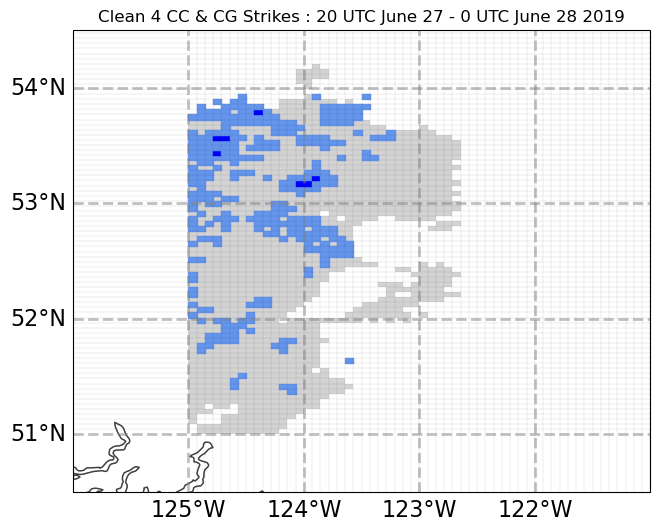

In [160]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean4, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean4, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean4)


# Make figure larger

plt.xlim([-126, -121])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean4_grid_corners_df["max_lat"])
lonlines = np.unique(clean4_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -124,  -123, -122])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 4 CC & CG Strikes : 20 UTC June 27 - 0 UTC June 28 2019")

plt.show()

## CC, CG, CC:CG, %+CG

In [161]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean4.min_lat)
bt_max_lat = np.max(bt_clean4.max_lat)
bt_min_lon = np.min(bt_clean4.min_lon)
bt_max_lon = np.max(bt_clean4.max_lon)

grid_clean4_split_cloud
grid_clean4_split_ground

grid_select = grid_clean4_split_cloud.loc[(grid_clean4_split_cloud.min_lat >= bt_min_lat) & (grid_clean4_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean4_split_cloud.min_lon >= bt_min_lon) & (grid_clean4_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_cloud = []
color_lt_clean4_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean4_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean4_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean4_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean4_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean4_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean4_split_ground.loc[(grid_clean4_split_ground.min_lat >= bt_min_lat) & (grid_clean4_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean4_split_ground.min_lon >= bt_min_lon) & (grid_clean4_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_ground = []
color_lt_clean4_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean4_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean4_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean4_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean4_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean4_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean4_split_cccg.loc[(grid_clean4_split_cccg.min_lat >= bt_min_lat) & (grid_clean4_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean4_split_cccg.min_lon >= bt_min_lon) & (grid_clean4_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_cccg = []
color_lt_clean4_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean4_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean4_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean4_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean4_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean4_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean4_percpos.loc[(grid_clean4_percpos.min_lat >= bt_min_lat) & (grid_clean4_percpos.max_lat <= bt_max_lat) &
                              (grid_clean4_percpos.min_lon >= bt_min_lon) & (grid_clean4_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean4_percpos = []
color_lt_clean4_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean4_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean4_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean4_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean4_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean4_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean4_percpos.append("red")

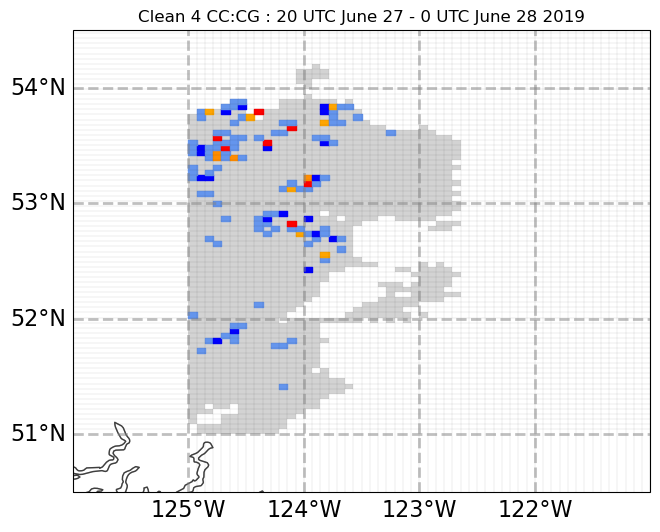

In [162]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean4, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean4_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean4_cccg)


# Make figure larger

plt.xlim([-126, -121])
plt.ylim([50.5, 54.5])

latlines = np.unique(clean4_grid_corners_df["max_lat"])
lonlines = np.unique(clean4_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -125,  -124,  -123, -122])
gl.ylocator = mticker.FixedLocator([ 51, 52, 53, 54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 4 CC:CG : 20 UTC June 27 - 0 UTC June 28 2019")

plt.show()

## process data

In [163]:
hours = [20, 21, 22, 23, 0]


clean4_cloud_density_array = []
clean4_ground_density_array = []
clean4_total_density_array = []

clean4_cloud_log_density_array = []
clean4_ground_log_density_array = []
clean4_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean4_split = grid_clean4_split_conc.loc[(grid_clean4_split_conc.hour == hours[i])]
        strikes_clean4 = grid_clean4_conc.loc[(grid_clean4_conc.hour == hours[i])]

        cloud_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean4["bt_area_km2"])
        
        clean4_cloud_density = list(cloud_count/area * 10000)
        clean4_cloud_density = np.nan_to_num(clean4_cloud_density)
        clean4_cloud_density_array.append(clean4_cloud_density)
        cloud_log = np.log(clean4_cloud_density + 0.2808988764044944)
        clean4_cloud_log_density_array.append(cloud_log)
        
        
        clean4_ground_density = list(ground_count/area * 10000)
        clean4_ground_density = np.nan_to_num(clean4_ground_density)
        clean4_ground_density_array.append(clean4_ground_density)  
        ground_log = np.log(clean4_ground_density + 0.2808988764044944)
        clean4_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean4["lt_count"]
        
        clean4_total_density = list(total_count/area * 10000)
        clean4_total_density = np.nan_to_num(clean4_total_density)
        clean4_total_density_array.append(clean4_total_density)
        total_log = np.log(clean4_total_density + 0.2808988764044944)
        clean4_total_log_density_array.append(total_log)
        
        
clean4_cloud_density_flat = [item for sublist in clean4_cloud_density_array for item in sublist]
clean4_ground_density_flat = [item for sublist in clean4_ground_density_array for item in sublist]
clean4_total_density_flat = [item for sublist in clean4_total_density_array for item in sublist]



In [164]:
clean4_cloud_halfmin = []
for i in range(0, 5): 
    if len([x for x in clean4_cloud_density_array[i] if x != 0]) > 0: 
        clean4_cloud_halfmin.append(np.min([x for x in clean4_cloud_density_array[i] if x != 0]) / 2)

clean4_ground_halfmin = []
for i in range(0, 5): 
    if len([x for x in clean4_ground_density_array[i] if x != 0]) > 0: 
        clean4_ground_halfmin.append(np.min([x for x in clean4_ground_density_array[i] if x != 0]) / 2)

clean4_total_halfmin = []
for i in range(0, 5): 
    if len([x for x in clean4_total_density_array[i] if x != 0]) > 0: 
        clean4_total_halfmin.append(np.min([x for x in clean4_total_density_array[i] if x != 0]) / 2)

clean4_cloud_totmin = np.min(clean4_cloud_halfmin)
clean4_ground_totmin = np.min(clean4_ground_halfmin)
clean4_total_totmin = np.min(clean4_total_halfmin)

clean4_cloud_totmin, clean4_ground_totmin, clean4_total_totmin

(0.2808988764044944, 0.2808988764044944, 0.2808988764044944)

### boxplot

In [165]:
clean4_cloud_max = []
for i in range(0, 5): 
    clean4_cloud_max.append(np.max(clean4_cloud_log_density_array[i]))

clean4_ground_max = []
for j in range(0, 5): 
    clean4_ground_max.append(np.max(clean4_ground_log_density_array[j]))

clean4_ground_max

[0.6864527256368339,
 1.9491152800042615,
 2.2394034108269647,
 1.6691828737593593,
 1.8507433837052754]

[Text(0, 0, '20:00'),
 Text(2, 0, '21:00'),
 Text(4, 0, '22:00'),
 Text(6, 0, '23:00'),
 Text(8, 0, '00:00'),
 Text(1, 0, ''),
 Text(3, 0, ''),
 Text(5, 0, ''),
 Text(7, 0, ''),
 Text(9, 0, '')]

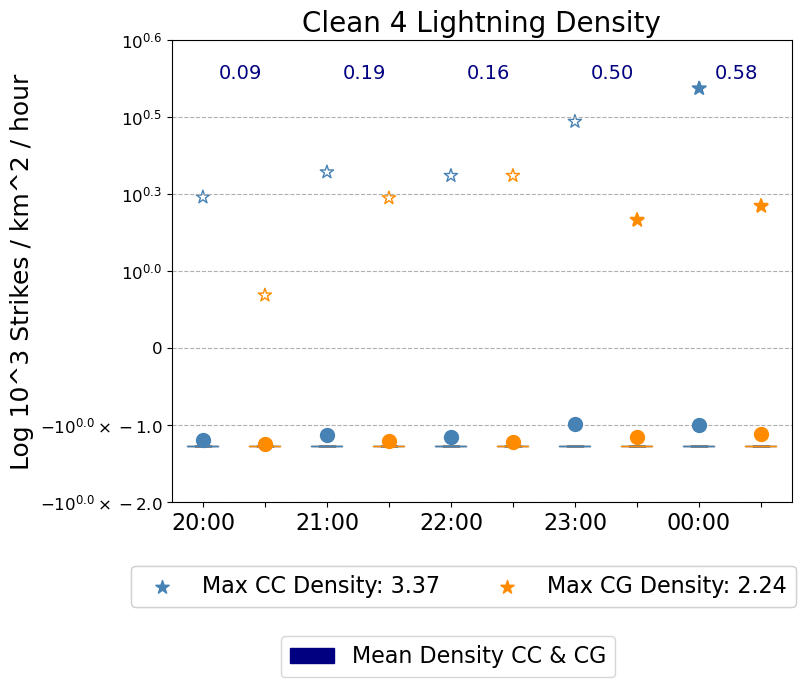

In [166]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 4 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)

plt.ylim(-1.5, 4)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)


box4_1 = ax.boxplot(clean4_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8]) 


box4_2 = ax.boxplot(clean4_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9]) 

ax.scatter(np.arange(0, 10, 2), clean4_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(8, clean4_cloud_max[4], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean4_cloud_max))) 

ax.scatter(np.arange(1, 11, 2), clean4_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(7, clean4_ground_max[3], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean4_ground_max))) 
ax.scatter(9, clean4_ground_max[4], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange')

x = np.arange(0.25, 9.25, 2)
for i in range(0, 5, 1):
    ax.annotate("{:.2f}".format(np.mean(clean4_total_density_array[i])), (x[i], 3.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["20:00", "21:00", "22:00", "23:00", "00:00", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min interval

In [167]:


# grid_clean4_int = pd.read_csv("/data2/edworak/data/clean4_lightning_bt.csv", sep='\t')

hours1 = [20, 21, 22, 23, 0]
mins1 = range(0, 60, 10)

clean4_cloud_density_array = []
clean4_ground_density_array = []
clean4_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean4_split = grid_clean4_int_split.loc[(grid_clean4_int_split.hour == hours1[i]) & (grid_clean4_int_split.minute >= mins1[j]) & (grid_clean4_int_split.minute <= mins1[j] + 9)]        
        strikes_clean4 = grid_clean4_int.loc[(grid_clean4_int.hour == hours1[i]) & (grid_clean4_int.minute >= mins1[j]) & (grid_clean4_int.minute <= mins1[j] + 9)]        
        bt_clean4 = grid_clean4_int_bt.loc[(grid_clean4_int_bt.hour == hours1[i]) & (grid_clean4_int_bt.minute >= mins1[j]) & (grid_clean4_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean4_split) >= 1: 
            #clean4_cloud_array.append(np.array(strikes_clean4[(strikes_clean4["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean4_split[(strikes_clean4_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean4["bt_area_km2"])

            clean4_cloud_density = list(cloud_count/area * 10000)
            clean4_cloud_density = np.nan_to_num(clean4_cloud_density)
            clean4_cloud_density_array.append(np.array(clean4_cloud_density))

            clean4_ground_density = list(ground_count/area * 10000)
            clean4_ground_density = np.nan_to_num(clean4_ground_density)
            clean4_ground_density_array.append(np.array(clean4_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean4["lt_count"]

            clean4_total_density = list(total_count/area * 10000)
            clean4_total_density = np.nan_to_num(clean4_total_density)
            clean4_total_density_array.append(np.array(clean4_total_density))

clean4_cloud_density_flat = [item for sublist in clean4_cloud_density_array for item in sublist]
clean4_ground_density_flat = [item for sublist in clean4_ground_density_array for item in sublist]
clean4_total_density_flat = [item for sublist in clean4_total_density_array for item in sublist]
clean4_cloud_density_array



[array([3.41151386, 0.85287846, 0.85287846, 0.85287846, 0.85287846,
        0.85287846, 0.85287846, 0.85287846, 0.85287846, 2.55863539,
        0.85287846, 0.85287846, 1.70575693, 6.82302772, 0.85287846,
        0.85287846, 0.85287846, 0.85287846, 0.85287846, 0.85287846,
        0.85287846, 0.85287846, 0.85287846, 0.85287846, 0.85287846,
        1.70575693, 1.70575693, 2.55863539, 0.85287846, 0.85287846,
        0.85287846, 0.85287846, 0.85287846, 3.41151386, 1.70575693]),
 array([0.82644628, 0.82644628, 1.65289256, 1.65289256, 0.82644628,
        0.82644628, 0.82644628, 0.82644628, 0.82644628, 0.82644628,
        0.82644628, 1.65289256, 2.47933884, 0.82644628, 0.82644628,
        0.82644628, 1.65289256, 0.82644628, 0.82644628, 1.65289256,
        0.82644628, 0.82644628, 0.82644628, 0.82644628, 0.82644628,
        0.82644628, 0.82644628, 0.82644628, 3.30578512, 0.82644628,
        0.82644628, 0.82644628, 0.82644628, 1.65289256, 0.82644628,
        0.82644628, 0.82644628, 0.82644628, 0.

# Clean Case 5 : 18 UTC June 15 (166) - 23 UTC June 15 (166) 2021
#### 53 N : 60 N, -117 W : -110 W

In [168]:
correct_clean5 = pd.read_csv("/data2/edworak/data/lightning_bt_plx_clean5.nc", usecols = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
correct_clean5["lt_count"] = np.zeros((25239))
np.unique(correct_clean5.hour)



array([18, 19, 20, 21, 22, 23])

In [169]:
lat_vals = range(53, 61)
lon_vals = range(-117, -109)

resolution_lon = np.abs([1 / (111.32 * np.cos(np.deg2rad(lat))) for lat in lat_vals])

ds_out_lat = []
ds_out_lon = []

for i in range(0, len(lon_vals)-1):
    ds_lat = np.arange(lat_vals[i], lat_vals[i+1], 5 * 0.00899820035)
    ds_out_lat.append(ds_lat)
    ds_lon = np.arange(lon_vals[i], lon_vals[i+1], 5 * resolution_lon[i])
    ds_out_lon.append(ds_lon)

ds_out_lon_flat = [item for sublist in ds_out_lon for item in sublist]
ds_out_lat_flat = [item for sublist in ds_out_lat for item in sublist]


### grid corners

In [170]:
# Define the latitude and longitude values for your clean5_grid (assuming evenly spaced)
latitude_values = np.linspace(53, 60, num=len(ds_out_lat_flat))  
longitude_values = np.linspace(-117, -110, num=len(ds_out_lon_flat)) 

# Calculate the clean5_grid cell size in degrees
lat_step = latitude_values[1] - latitude_values[0]
lon_step = longitude_values[1] - longitude_values[0]

# Initialize lists to store clean5_grid corners
clean5_grid_corners = []
min_lat = []
max_lat = []
min_lon = []
max_lon = []

# Iterate through latitude values
for i in range(len(latitude_values) - 1):
    for j in range(len(longitude_values) - 1):
        # Calculate the corners of the clean5_grid cell
        lat1 = latitude_values[i]
        lat2 = latitude_values[i + 1]
        lon1 = longitude_values[j]
        lon2 = longitude_values[j + 1]
        
        # Append the clean5_grid cell's corners to the list
        clean5_grid_corners.append([(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)])
        min_lat.append(lat1)
        max_lat.append(lat2)
        min_lon.append(lon1)
        max_lon.append(lon2)
# The clean5_grid_corners list now contains the corner coordinates of each clean5_grid cell
# Each element of the list is a list of four tuples representing the corners
clean5_grid_corners_df = pd.DataFrame([min_lat, max_lat, min_lon, max_lon]).T
clean5_grid_corners_df = clean5_grid_corners_df.set_axis(['min_lat', 'max_lat', "min_lon", "max_lon"], axis=1)
clean5_grid_corners_df = clean5_grid_corners_df.drop_duplicates(keep='first') 
clean5_grid_corners_df

min_lat   max_lat     min_lon     max_lon
0      53.00000  53.04375 -117.000000 -116.922222
1      53.00000  53.04375 -116.922222 -116.844444
2      53.00000  53.04375 -116.844444 -116.766667
3      53.00000  53.04375 -116.766667 -116.688889
4      53.00000  53.04375 -116.688889 -116.611111
...         ...       ...         ...         ...
14395  59.95625  60.00000 -110.388889 -110.311111
14396  59.95625  60.00000 -110.311111 -110.233333
14397  59.95625  60.00000 -110.233333 -110.155556
14398  59.95625  60.00000 -110.155556 -110.077778
14399  59.95625  60.00000 -110.077778 -110.000000

[14400 rows x 4 columns]

In [171]:

min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(correct_clean5)): 
    # print(i)
    findlat = correct_clean5.lat[i]
    findlon = correct_clean5.lon[i]

    findcorners = clean5_grid_corners_df.loc[(clean5_grid_corners_df.min_lat <= findlat) & (clean5_grid_corners_df.max_lat >= findlat) & 
                                     (clean5_grid_corners_df.min_lon <= findlon) & (clean5_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values[0])
    max_lat_array.append(findcorners.max_lat.values[0])
    min_lon_array.append(findcorners.min_lon.values[0])
    max_lon_array.append(findcorners.max_lon.values[0])
    

correct_clean5["min_lat"] = min_lat_array
correct_clean5["max_lat"] = max_lat_array
correct_clean5["cent_lat"] = np.add(min_lat_array, max_lat_array) / 2

correct_clean5["min_lon"] = min_lon_array
correct_clean5["max_lon"] = max_lon_array
correct_clean5["cent_lon"] = np.add(min_lon_array, max_lon_array) / 2


correct_clean5



year  month  day  hour  minute     second      lat       lon  \
0      2021      6   15    21      55   1.112943  58.2470 -113.3299   
1      2021      6   15    21      30   1.129019  58.0625 -113.4030   
2      2021      6   15    21       0   0.742416  57.9104 -113.5325   
3      2021      6   15    23       0   0.612641  58.9507 -114.0581   
4      2021      6   15    20      30   0.877531  57.7775 -113.4118   
...     ...    ...  ...   ...     ...        ...      ...       ...   
25234  2021      6   15    22      54  34.000000  58.6480 -116.6660   
25235  2021      6   15    22      54  35.000000  59.1910 -115.5510   
25236  2021      6   15    22      54  39.000000  59.2580 -115.4780   
25237  2021      6   15    22      54  46.000000  58.7920 -115.8400   
25238  2021      6   15    22      54  50.000000  58.8850 -115.5410   

       peak current C or G  ...       tlat        tlon  distance(km)  \
0               5.7      C  ...  58.263847 -113.340982         1.982   
1              10.1      G  ...  58.065236 -113.415133         0.776   
2              -7.3      C  ...  57.917131 -113.531218         0.752   
3             -18.4      G  ...  58.934521 -114.045339         1.942   
4               5.5      G  ...  57.785582 -113.421276         1.060   
...             ...    ...  ...        ...         ...           ...   
25234          18.0      C  ...  58.721055 -116.683493         8.186   
25235           9.3      C  ...  59.188900 -115.535730         0.901   
25236           7.8      C  ...  59.242825 -115.495375         1.955   
25237         -20.1      G  ...  58.776016 -115.824421         1.991   
25238         -11.0      G  ...  58.884877 -115.548325         0.421   

       lt_count   min_lat   max_lat   cent_lat     min_lon     max_lon  \
0           0.0  58.20625  58.25000  58.228125 -113.344444 -113.266667   
1           0.0  58.03125  58.07500  58.053125 -113.422222 -113.344444   
2           0.0  57.90000  57.94375  57.921875 -113.577778 -113.500000   
3           0.0  58.95000  58.99375  58.971875 -114.122222 -114.044444   
4           0.0  57.76875  57.81250  57.790625 -113.422222 -113.344444   
...         ...       ...       ...        ...         ...         ...   
25234       0.0  58.64375  58.68750  58.665625 -116.688889 -116.611111   
25235       0.0  59.16875  59.21250  59.190625 -115.600000 -115.522222   
25236       0.0  59.25625  59.30000  59.278125 -115.522222 -115.444444   
25237       0.0  58.77500  58.81875  58.796875 -115.911111 -115.833333   
25238       0.0  58.86250  58.90625  58.884375 -115.600000 -115.522222   

         cent_lon  
0     -113.305556  
1     -113.383333  
2     -113.538889  
3     -114.083333  
4     -113.383333  
...           ...  
25234 -116.650000  
25235 -115.561111  
25236 -115.483333  
25237 -115.872222  
25238 -115.561111  

[25239 rows x 21 columns]

In [172]:
# CC AND CG SEPERATION, BASED ON HOURS 

# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean5_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_split = grid_clean5_split[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean5_split = grid_clean5_split.T.drop_duplicates().T
grid_clean5_split.lt_count = pd.to_numeric(grid_clean5_split.lt_count)

# --------------------------------------------------------------

# STRIKES FOR WHOLE TIME, CC AND CG SPLIT, CC:CG RATIO
# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'C or G'])['CMI_C14'].min().reset_index()

grid_clean5_split_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_split_all = grid_clean5_split_all[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean5_split_all = grid_clean5_split_all.T.drop_duplicates().T
grid_clean5_split_all.lt_count = pd.to_numeric(grid_clean5_split_all.lt_count)
grid_clean5_split_cloud = grid_clean5_split_all.loc[grid_clean5_split_all["C or G"] == "C"]
grid_clean5_split_ground = grid_clean5_split_all.loc[grid_clean5_split_all["C or G"] == "G"]


grid_clean5_split_cccg = pd.merge(grid_clean5_split_cloud, grid_clean5_split_ground[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'C or G', 'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')

grid_clean5_split_cccg.loc[(grid_clean5_split_cccg.lt_count_y >= 0)]
grid_clean5_split_cccg["CC:CG"] = grid_clean5_split_cccg.lt_count_x / grid_clean5_split_cccg.lt_count_y
grid_clean5_split_cccg = grid_clean5_split_cccg.loc[grid_clean5_split_cccg["CC:CG"] >= 0]

# --------------------------------------------------------------

# PECRCENT POSITIVE CG STRIKES
correct_clean5_ground = correct_clean5.loc[correct_clean5["C or G"] != "C"]
grouped_lt = correct_clean5_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'peak current'])["lt_count"].count().reset_index()
grouped_bt = correct_clean5_ground.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',  'peak current'])['CMI_C14'].min().reset_index()

grid_clean5_percpos = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_percpos = grid_clean5_percpos[['min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'peak current', 'CMI_C14','lt_count']]
grid_clean5_percpos = grid_clean5_percpos.T.drop_duplicates().T
grid_clean5_percpos.lt_count = pd.to_numeric(grid_clean5_percpos.lt_count)
grid_clean5_percpos_pos = grid_clean5_percpos.loc[grid_clean5_percpos["peak current"] > 0]

grid_clean5_percpos = pd.merge(grid_clean5_split_ground, grid_clean5_percpos_pos[['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon',
       'CMI_C14', 'lt_count']],on=['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'], how='left')


grid_clean5_percpos.lt_count_y = np.nan_to_num(grid_clean5_percpos.lt_count_y)
grid_clean5_percpos["perc_pos"] = (grid_clean5_percpos.lt_count_y / grid_clean5_percpos.lt_count_x) * 100


# --------------------------------------------------------------

## keep all lightning as total count 

grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])["lt_count"].count().reset_index()
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour'])['CMI_C14'].min().reset_index()

grid_clean5 = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5 = grid_clean5[['hour', 
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'CMI_C14','lt_count']]
grid_clean5 = grid_clean5.T.drop_duplicates().T
grid_clean5.lt_count = pd.to_numeric(grid_clean5.lt_count)

# --------------------------------------------------------------

## all hours in one dataframe

grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])["lt_count"].count().reset_index()
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon'])['CMI_C14'].min().reset_index()

grid_clean5_all = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_all = grid_clean5_all[['min_lat', 'max_lat', 'cent_lat', 
                                   'min_lon', 'max_lon', 'cent_lon', 
                                   'CMI_C14','lt_count']]
grid_clean5_all = grid_clean5_all.T.drop_duplicates().T
grid_clean5_all.lt_count = pd.to_numeric(grid_clean5_all.lt_count)
grid_clean5_all

# --------------------------------------------------------------

## 10 minute intervals, C and G split 


grid_clean5_percpos


min_lat   max_lat   cent_lat     min_lon     max_lon    cent_lon  \
0      53.0875  53.13125  53.109375 -114.822222 -114.744444 -114.783333   
1     53.13125    53.175  53.153125 -114.277778      -114.2 -114.238889   
2      53.2625  53.30625  53.284375 -114.822222 -114.744444 -114.783333   
3     53.30625     53.35  53.328125      -114.2 -114.122222 -114.161111   
4     53.39375   53.4375  53.415625 -113.966667 -113.888889 -113.927778   
...        ...       ...        ...         ...         ...         ...   
6337  59.95625      60.0  59.978125 -115.522222 -115.444444 -115.483333   
6338  59.95625      60.0  59.978125 -115.133333 -115.055556 -115.094444   
6339  59.95625      60.0  59.978125 -115.055556 -114.977778 -115.016667   
6340  59.95625      60.0  59.978125 -114.977778      -114.9 -114.938889   
6341  59.95625      60.0  59.978125      -114.9 -114.822222 -114.861111   

     C or G  CMI_C14_x  lt_count_x  CMI_C14_y  lt_count_y  perc_pos  
0         G -50.016556           4        NaN         0.0       0.0  
1         G -56.899384           2        NaN         0.0       0.0  
2         G  -50.61505           1        NaN         0.0       0.0  
3         G -58.275955           1 -58.275955         1.0     100.0  
4         G -57.497894           1 -57.497894         1.0     100.0  
...     ...        ...         ...        ...         ...       ...  
6337      G -54.325806           1 -54.325806         1.0     100.0  
6338      G  -57.55774           1        NaN         0.0       0.0  
6339      G -56.420593           2        NaN         0.0       0.0  
6340      G -57.497894           2 -57.138794         1.0      50.0  
6341      G -57.737305           1        NaN         0.0       0.0  

[6342 rows x 12 columns]

In [173]:
# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute', 'C or G'])['CMI_C14'].min().reset_index()

grid_clean5_int_split = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_int_split = grid_clean5_int_split[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                           'C or G', 'CMI_C14','lt_count']]
grid_clean5_int_split = grid_clean5_int_split.T.drop_duplicates().T
grid_clean5_int_split.lt_count = pd.to_numeric(grid_clean5_int_split.lt_count)

# --------------------------------------------------------------

## 10 minute intervals, C and G split 

# count number of lightning strikes 
grouped_lt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])["lt_count"].count().reset_index()

# get minimum BT value 
grouped_bt = correct_clean5.groupby(['min_lat', 'max_lat', 'cent_lat', 'min_lon', 'max_lon', 'cent_lon', 'hour', 'minute'])['CMI_C14'].min().reset_index()

grid_clean5_int = pd.concat([grouped_lt, grouped_bt], axis=1)
grid_clean5_int = grid_clean5_int[['hour', 'minute',
                           'min_lat', 'max_lat', 'cent_lat', 
                           'min_lon', 'max_lon', 'cent_lon', 
                            'CMI_C14','lt_count']]
grid_clean5_int = grid_clean5_int.T.drop_duplicates().T
grid_clean5_int.lt_count = pd.to_numeric(grid_clean5_int.lt_count)

grid_clean5_int_split
grid_clean5_int_split

hour minute   min_lat   max_lat   cent_lat     min_lon     max_lon  \
0       18     39   53.0875  53.13125  53.109375 -114.822222 -114.744444   
1       18     40   53.0875  53.13125  53.109375 -114.822222 -114.744444   
2       18     40   53.0875  53.13125  53.109375 -114.822222 -114.744444   
3       18      2  53.13125    53.175  53.153125 -114.277778      -114.2   
4       18     45    53.175  53.21875  53.196875      -114.9 -114.822222   
...    ...    ...       ...       ...        ...         ...         ...   
12542   23     28  59.95625      60.0  59.978125 -115.055556 -114.977778   
12543   23     30  59.95625      60.0  59.978125 -115.055556 -114.977778   
12544   23     27  59.95625      60.0  59.978125 -114.977778      -114.9   
12545   23     38  59.95625      60.0  59.978125 -114.977778      -114.9   
12546   23     43  59.95625      60.0  59.978125      -114.9 -114.822222   

         cent_lon C or G    CMI_C14  lt_count  
0     -114.783333      G -50.016556         2  
1     -114.783333      C -50.016556         1  
2     -114.783333      G -50.016556         2  
3     -114.238889      G -56.899384         2  
4     -114.861111      C -50.555206         1  
...           ...    ...        ...       ...  
12542 -115.016667      G -56.420593         1  
12543 -115.016667      G -56.420593         1  
12544 -114.938889      G -57.138794         1  
12545 -114.938889      G -57.497894         1  
12546 -114.861111      G -57.737305         1  

[12547 rows x 11 columns]

### brightness temp

In [174]:
bt_clean5 = pd.read_csv("/data2/edworak/data/correct_bt_clean5.nc")
bt_clean5 = bt_clean5.loc[(bt_clean5.tlat >= 53) & (bt_clean5.tlat <= 61) 
                          & (bt_clean5.tlon >= -117) & (bt_clean5.tlon <= -109)]
bt_clean5 = bt_clean5.reset_index()


min_lat_array = []
max_lat_array = []
min_lon_array = []
max_lon_array = []


for i in range(0, len(bt_clean5)): 
    findlat = bt_clean5.tlat[i]
    findlon = bt_clean5.tlon[i]

    findcorners = clean5_grid_corners_df.loc[(clean5_grid_corners_df.min_lat <= findlat) & (clean5_grid_corners_df.max_lat >= findlat) & 
                                     (clean5_grid_corners_df.min_lon <= findlon) & (clean5_grid_corners_df.max_lon >= findlon)]
    min_lat_array.append(findcorners.min_lat.values)
    max_lat_array.append(findcorners.max_lat.values)
    min_lon_array.append(findcorners.min_lon.values)
    max_lon_array.append(findcorners.max_lon.values)
    
min_lat_array_flat = [item for sublist in min_lat_array for item in sublist]
max_lat_array_flat = [item for sublist in max_lat_array for item in sublist]

min_lon_array_flat = [item for sublist in min_lon_array for item in sublist]
max_lon_array_flat = [item for sublist in max_lon_array for item in sublist]


bt_clean5["min_lat"] = min_lat_array_flat
bt_clean5["max_lat"] = max_lat_array_flat
bt_clean5["cent_lat"] = np.add(min_lat_array_flat, max_lat_array_flat) / 2

bt_clean5["min_lon"] = min_lon_array_flat
bt_clean5["max_lon"] = max_lon_array_flat
bt_clean5["cent_lon"] = np.add(min_lon_array_flat, max_lon_array_flat) / 2


bt_clean5


index  Unnamed: 0  year  month  day  hour  minute       tlat  \
0            8           8  2021      6   15    23      15  59.546471   
1            9           9  2021      6   15    21      15  59.548866   
2           10          10  2021      6   15    23       5  59.565162   
3           11          11  2021      6   15    22      25  59.582030   
4           12          12  2021      6   15    21      35  59.547137   
...        ...         ...   ...    ...  ...   ...     ...        ...   
269374  273174      273174  2021      6   15    20       5  54.565652   
269375  273175      273175  2021      6   15    20       5  54.568421   
269376  273176      273176  2021      6   15    20       5  54.571345   
269377  273177      273177  2021      6   15    20       5  54.572945   
269378  273178      273178  2021      6   15    20       5  54.575524   

              tlon    CMI_C14   min_lat   max_lat   cent_lat     min_lon  \
0      -116.922879 -52.051483  59.51875  59.56250  59.540625 -117.000000   
1      -116.963077 -50.854460  59.51875  59.56250  59.540625 -117.000000   
2      -116.652412 -51.752228  59.56250  59.60625  59.584375 -116.688889   
3      -116.434610 -50.734770  59.56250  59.60625  59.584375 -116.455556   
4      -116.159048 -50.914307  59.51875  59.56250  59.540625 -116.222222   
...            ...        ...       ...       ...        ...         ...   
269374 -113.650556 -52.111330  54.53125  54.57500  54.553125 -113.655556   
269375 -113.610646 -52.111330  54.53125  54.57500  54.553125 -113.655556   
269376 -113.570546 -51.692383  54.53125  54.57500  54.553125 -113.577778   
269377 -113.538719 -51.393127  54.53125  54.57500  54.553125 -113.577778   
269378 -113.498909 -50.615050  54.57500  54.61875  54.596875 -113.500000   

           max_lon    cent_lon  
0      -116.922222 -116.961111  
1      -116.922222 -116.961111  
2      -116.611111 -116.650000  
3      -116.377778 -116.416667  
4      -116.144444 -116.183333  
...            ...         ...  
269374 -113.577778 -113.616667  
269375 -113.577778 -113.616667  
269376 -113.500000 -113.538889  
269377 -113.500000 -113.538889  
269378 -113.422222 -113.461111  

[269379 rows x 16 columns]

In [175]:
## group the bt data to get area at each hour
grouped_clean5_bt = bt_clean5.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'], keep = "first").reset_index()
grouped_clean5_bt = grouped_clean5_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour'])['level_0'].count().reset_index()
grouped_clean5_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'bt_area_km2']
grouped_clean5_bt["bt_area_km2"] = grouped_clean5_bt["bt_area_km2"] * 25
grid_clean5_bt = grouped_clean5_bt

grid_clean5_bt

min_lat   max_lat     min_lon     max_lon  hour  bt_area_km2
0      53.0000  53.04375 -116.144444 -116.066667    18           25
1      53.0000  53.04375 -116.066667 -115.988889    18           25
2      53.0000  53.04375 -115.988889 -115.911111    18           25
3      53.0000  53.04375 -115.911111 -115.833333    18           25
4      53.0000  53.04375 -115.833333 -115.755556    18           25
...        ...       ...         ...         ...   ...          ...
35414  59.5625  59.60625 -110.855556 -110.777778    23           25
35415  59.5625  59.60625 -110.777778 -110.700000    22           25
35416  59.5625  59.60625 -110.777778 -110.700000    23           25
35417  59.5625  59.60625 -110.700000 -110.622222    22           25
35418  59.5625  59.60625 -110.700000 -110.622222    23           25

[35419 rows x 6 columns]

In [176]:
## group the bt data to get area at each hour
grouped_clean5_int_bt = bt_clean5.drop_duplicates(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'], keep = "first").reset_index()
grouped_clean5_int_bt = grouped_clean5_int_bt.groupby(['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute'])['level_0'].count().reset_index()
grouped_clean5_int_bt.columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon', 'hour', 'minute', 'bt_area_km2']
grouped_clean5_int_bt["bt_area_km2"] = 25
grid_clean5_int_bt = grouped_clean5_int_bt

grid_clean5_int_bt

min_lat   max_lat     min_lon     max_lon  hour  minute  bt_area_km2
0       53.0000  53.04375 -116.144444 -116.066667    18       5           25
1       53.0000  53.04375 -116.066667 -115.988889    18       5           25
2       53.0000  53.04375 -115.988889 -115.911111    18       5           25
3       53.0000  53.04375 -115.911111 -115.833333    18       5           25
4       53.0000  53.04375 -115.833333 -115.755556    18       5           25
...         ...       ...         ...         ...   ...     ...          ...
150203  59.5625  59.60625 -110.700000 -110.622222    23      15           25
150204  59.5625  59.60625 -110.700000 -110.622222    23      25           25
150205  59.5625  59.60625 -110.700000 -110.622222    23      35           25
150206  59.5625  59.60625 -110.700000 -110.622222    23      45           25
150207  59.5625  59.60625 -110.700000 -110.622222    23      55           25

[150208 rows x 7 columns]

### combine datasets

In [177]:
grid_clean5_conc = pd.merge(grid_clean5_bt, grid_clean5[["lt_count", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean5_conc['lt_count'] = np.nan_to_num(grid_clean5_conc.lt_count)

grid_clean5_split_conc = pd.merge(grid_clean5_bt, grid_clean5_split[["lt_count", "C or G", "hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon']],on=["hour", 'min_lat', 'max_lat', 'min_lon', 'max_lon'], how='left')
grid_clean5_split_conc['lt_count'] = np.nan_to_num(grid_clean5_split_conc.lt_count)
grid_clean5_split_conc

min_lat   max_lat     min_lon     max_lon hour  bt_area_km2  lt_count  \
0         53.0  53.04375 -116.144444 -116.066667   18           25       0.0   
1         53.0  53.04375 -116.066667 -115.988889   18           25       0.0   
2         53.0  53.04375 -115.988889 -115.911111   18           25       0.0   
3         53.0  53.04375 -115.911111 -115.833333   18           25       0.0   
4         53.0  53.04375 -115.833333 -115.755556   18           25       0.0   
...        ...       ...         ...         ...  ...          ...       ...   
36400  59.5625  59.60625 -110.855556 -110.777778   23           25       0.0   
36401  59.5625  59.60625 -110.777778      -110.7   22           25       0.0   
36402  59.5625  59.60625 -110.777778      -110.7   23           25       0.0   
36403  59.5625  59.60625      -110.7 -110.622222   22           25       0.0   
36404  59.5625  59.60625      -110.7 -110.622222   23           25       0.0   

      C or G  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
...      ...  
36400    NaN  
36401    NaN  
36402    NaN  
36403    NaN  
36404    NaN  

[36405 rows x 8 columns]

### map

In [178]:
min_lat = np.min(bt_clean5.min_lat)
max_lat = np.max(bt_clean5.max_lat)
min_lat = np.min(bt_clean5.min_lon)
max_lon = np.max(bt_clean5.max_lon)
max_lon

-110.31111111111112

In [179]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

# polygons for brightness temp 

bt_clean5_select = bt_clean5

bt_clean5_select = bt_clean5_select.reset_index()

patches_bt_clean5 = []

for i in range(len(bt_clean5_select)):
    y = np.array([[bt_clean5_select.min_lon[i], bt_clean5_select.min_lat[i]], [bt_clean5_select.max_lon[i], bt_clean5_select.min_lat[i]], 
                  [bt_clean5_select.max_lon[i], bt_clean5_select.max_lat[i]], [bt_clean5_select.min_lon[i], bt_clean5_select.max_lat[i]]])

    polygon = Polygon(y, closed = True)
    patches_bt_clean5.append(polygon)


# ------------------------------------------------------ 

# polygons for lightning density 
#grid_select = grid_clean5.loc[(grid_clean5.hour == 21)]
bt_min_lat = np.min(bt_clean5.min_lat)
bt_max_lat = np.max(bt_clean5.max_lat)
bt_min_lon = np.min(bt_clean5.min_lon)
bt_max_lon = np.max(bt_clean5.max_lon)

grid_select = grid_clean5_all.loc[(grid_clean5_all.min_lat >= bt_min_lat) & (grid_clean5_all.max_lat <= bt_max_lat) &
                              (grid_clean5_all.min_lon >= bt_min_lon) & (grid_clean5_all.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5 = []
color_lt_clean5 = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean5.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean5.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean5.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean5.append("darkorange")
    if (x > 140): 
        color_lt_clean5.append("red")

    
    

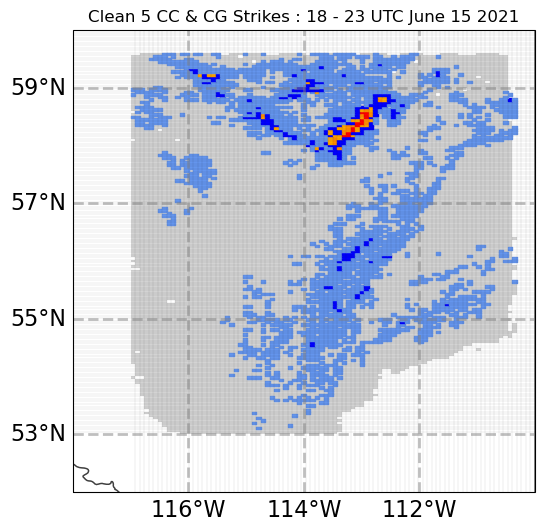

In [180]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean5, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean5, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean5)


# Make figure larger

plt.xlim([-118, -110])
plt.ylim([52, 60])

latlines = np.unique(clean5_grid_corners_df["max_lat"])
lonlines = np.unique(clean5_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -118, -116, -114, -112, -110])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57, 59, 61])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 5 CC & CG Strikes : 18 - 23 UTC June 15 2021")

plt.show()

## CC, CG, CC:CG, %+CG

In [181]:
# polygons for lightning density 
bt_min_lat = np.min(bt_clean5.min_lat)
bt_max_lat = np.max(bt_clean5.max_lat)
bt_min_lon = np.min(bt_clean5.min_lon)
bt_max_lon = np.max(bt_clean5.max_lon)

grid_clean5_split_cloud
grid_clean5_split_ground

grid_select = grid_clean5_split_cloud.loc[(grid_clean5_split_cloud.min_lat >= bt_min_lat) & (grid_clean5_split_cloud.max_lat <= bt_max_lat) &
                              (grid_clean5_split_cloud.min_lon >= bt_min_lon) & (grid_clean5_split_cloud.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_cloud = []
color_lt_clean5_cloud = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_cloud.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean5_cloud.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean5_cloud.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean5_cloud.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean5_cloud.append("darkorange")
    if (x > 140): 
        color_lt_clean5_cloud.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean5_split_ground.loc[(grid_clean5_split_ground.min_lat >= bt_min_lat) & (grid_clean5_split_ground.max_lat <= bt_max_lat) &
                              (grid_clean5_split_ground.min_lon >= bt_min_lon) & (grid_clean5_split_ground.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_ground = []
color_lt_clean5_ground = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_ground.append(polygon)
    
    x = grid_select.lt_count[i]
    if x <= 20: 
        color_lt_clean5_ground.append("cornflowerblue")
    if (x > 20) & (x <= 60): 
        color_lt_clean5_ground.append("blue")
    if (x > 60) & (x <= 100): 
        color_lt_clean5_ground.append("orange")   
    if (x > 100) & (x <= 140): 
        color_lt_clean5_ground.append("darkorange")
    if (x > 140): 
        color_lt_clean5_ground.append("red")
# ------------------------------------------------------ 

grid_select = grid_clean5_split_cccg.loc[(grid_clean5_split_cccg.min_lat >= bt_min_lat) & (grid_clean5_split_cccg.max_lat <= bt_max_lat) &
                              (grid_clean5_split_cccg.min_lon >= bt_min_lon) & (grid_clean5_split_cccg.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_cccg = []
color_lt_clean5_cccg = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_cccg.append(polygon)
    
    x = grid_select["CC:CG"][i]
    if x <= 3: 
        color_lt_clean5_cccg.append("cornflowerblue")
    if (x > 3) & (x <= 6): 
        color_lt_clean5_cccg.append("blue")
    if (x > 6) & (x <= 9): 
        color_lt_clean5_cccg.append("orange")   
    if (x > 9) & (x <= 12): 
        color_lt_clean5_cccg.append("darkorange")
    if (x > 12): 
        color_lt_clean5_cccg.append("red")

# ------------------------------------------------------ 

grid_select = grid_clean5_percpos.loc[(grid_clean5_percpos.min_lat >= bt_min_lat) & (grid_clean5_percpos.max_lat <= bt_max_lat) &
                              (grid_clean5_percpos.min_lon >= bt_min_lon) & (grid_clean5_percpos.max_lon <= bt_max_lon)]

grid_select = grid_select.reset_index()

patches_lt_clean5_percpos = []
color_lt_clean5_percpos = []

for i in range(len(grid_select)):
    z = np.array([[grid_select.min_lon[i], grid_select.min_lat[i]], [grid_select.max_lon[i], grid_select.min_lat[i]], 
                  [grid_select.max_lon[i], grid_select.max_lat[i]], [grid_select.min_lon[i], grid_select.max_lat[i]]])
    polygon = Polygon(z, closed = True)
    patches_lt_clean5_percpos.append(polygon)
    
    x = grid_select["perc_pos"][i]
    if x <= 5: 
        color_lt_clean5_percpos.append("cornflowerblue")
    if (x > 5) & (x <= 10): 
        color_lt_clean5_percpos.append("blue")
    if (x > 10) & (x <= 30): 
        color_lt_clean5_percpos.append("orange")   
    if (x > 30) & (x <= 50): 
        color_lt_clean5_percpos.append("darkorange")
    if (x > 50): 
        color_lt_clean5_percpos.append("red")

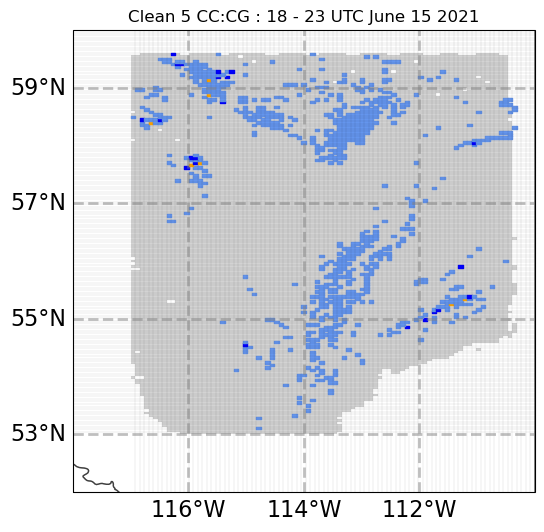

In [182]:
fig = plt.figure(figsize=(8,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# shading 
p_bt = PatchCollection(patches_bt_clean5, facecolor = "lightgrey", alpha=1)
ax.add_collection(p_bt)


p_lt = PatchCollection(patches_lt_clean5_cccg, alpha=1)
ax.add_collection(p_lt)
p_lt.set_color(color_lt_clean5_cccg)


# Make figure larger

plt.xlim([-118, -110])
plt.ylim([52, 60])

latlines = np.unique(clean5_grid_corners_df["max_lat"])
lonlines = np.unique(clean5_grid_corners_df["max_lon"])

for i in range(0, len(latlines)):
    plt.axhline(y=latlines[i],  linestyle='-', color = "black", linewidth = 0.05)

for i in range(0, len(lonlines)):
    plt.axvline(x=lonlines[i],  linestyle='-', color = "black", linewidth = 0.05)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='grey', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -118, -116, -114, -112, -110])
gl.ylocator = mticker.FixedLocator([ 51, 53, 55, 57, 59, 61])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'


plt.title("Clean 5 CC:CG : 18 - 23 UTC June 15 2021")

plt.show()

## process data

In [183]:
hours = [18, 19, 20, 21, 22, 23]


clean5_cloud_density_array = []
clean5_ground_density_array = []
clean5_total_density_array = []

clean5_cloud_log_density_array = []
clean5_ground_log_density_array = []
clean5_total_log_density_array = []

for i in range(len(hours)): 
        # ----------------
        # split strikes
        strikes_clean5_split = grid_clean5_split_conc.loc[(grid_clean5_split_conc.hour == hours[i])]
        strikes_clean5 = grid_clean5_conc.loc[(grid_clean5_conc.hour == hours[i])]

        cloud_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "G")]["lt_count"]
        ground_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "C")]["lt_count"]
        area = np.sum(strikes_clean5["bt_area_km2"])
        
        clean5_cloud_density = list(cloud_count/area * 10000)
        clean5_cloud_density = np.nan_to_num(clean5_cloud_density)
        clean5_cloud_density_array.append(clean5_cloud_density)
        cloud_log = np.log(clean5_cloud_density + 0.029282576866764273)
        clean5_cloud_log_density_array.append(cloud_log)
        
        
        clean5_ground_density = list(ground_count/area * 10000)
        clean5_ground_density = np.nan_to_num(clean5_ground_density)
        clean5_ground_density_array.append(clean5_ground_density)  
        ground_log = np.log(clean5_ground_density + 0.029282576866764273)
        clean5_ground_log_density_array.append(ground_log)
        
        # --------------- 
        # total strikes 
        
        total_count = strikes_clean5["lt_count"]
        
        clean5_total_density = list(total_count/area * 10000)
        clean5_total_density = np.nan_to_num(clean5_total_density)
        clean5_total_density_array.append(clean5_total_density)
        total_log = np.log(clean5_total_density + 0.029282576866764273)
        clean5_total_log_density_array.append(total_log)
        
        
clean5_cloud_density_flat = [item for sublist in clean5_cloud_density_array for item in sublist]
clean5_ground_density_flat = [item for sublist in clean5_ground_density_array for item in sublist]
clean5_total_density_flat = [item for sublist in clean5_total_density_array for item in sublist]



In [184]:
clean5_cloud_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean5_cloud_density_array[i] if x != 0]) > 0: 
        clean5_cloud_halfmin.append(np.min([x for x in clean5_cloud_density_array[i] if x != 0]) / 2)

clean5_ground_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean5_ground_density_array[i] if x != 0]) > 0: 
        clean5_ground_halfmin.append(np.min([x for x in clean5_ground_density_array[i] if x != 0]) / 2)

clean5_total_halfmin = []
for i in range(0, 6): 
    if len([x for x in clean5_total_density_array[i] if x != 0]) > 0: 
        clean5_total_halfmin.append(np.min([x for x in clean5_total_density_array[i] if x != 0]) / 2)

clean5_cloud_totmin = np.min(clean5_cloud_halfmin)
clean5_ground_totmin = np.min(clean5_ground_halfmin)
clean5_total_totmin = np.min(clean5_total_halfmin)

clean5_cloud_totmin, clean5_ground_totmin, clean5_total_totmin

(0.029282576866764273, 0.029282576866764273, 0.029282576866764273)

### boxplot

In [185]:
clean5_cloud_max = []
for i in range(0, 6): 
    clean5_cloud_max.append(np.max(clean5_cloud_log_density_array[i]))

clean5_ground_max = []
for j in range(0, 6): 
    clean5_ground_max.append(np.max(clean5_ground_log_density_array[j]))

clean5_cloud_max, clean5_ground_max

([-0.4540716263361082,
  -0.4076485532482695,
  -0.163466756030325,
  0.1480424962376978,
  0.23150648136430224,
  0.9013658023394171],
 [0.21574981737265364,
  0.5932642523862844,
  1.6225290084809798,
  2.274791580733165,
  2.8776952098995725,
  2.980285302968025])

[Text(0, 0, '18:00'),
 Text(2, 0, '19:00'),
 Text(4, 0, '20:00'),
 Text(6, 0, '21:00'),
 Text(8, 0, '22:00'),
 Text(10, 0, '23:00'),
 Text(1, 0, ''),
 Text(3, 0, ''),
 Text(5, 0, ''),
 Text(7, 0, ''),
 Text(9, 0, ''),
 Text(11, 0, '')]

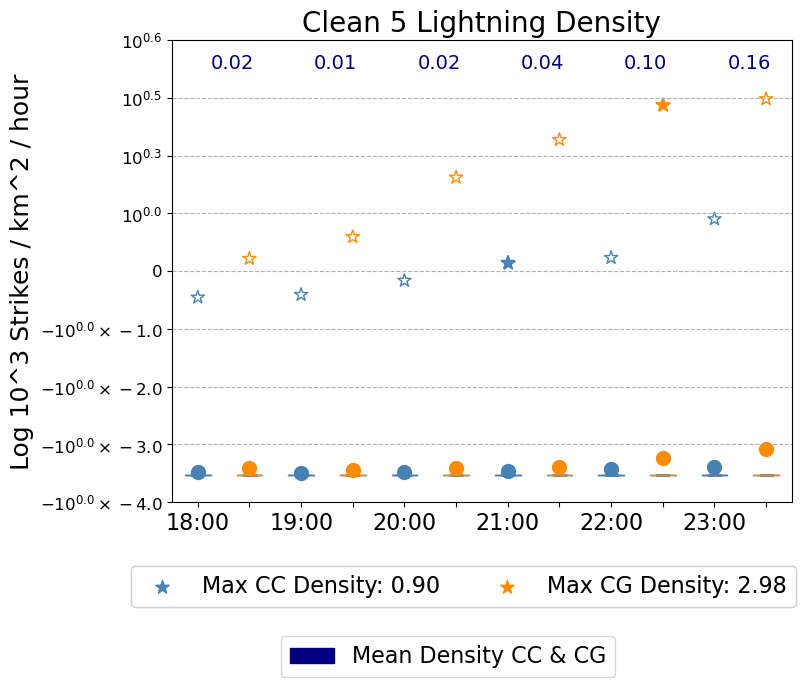

In [186]:
fig, ax = plt.subplots(figsize = (8,6))
degree_sign = u'\N{DEGREE SIGN}'


ax.set_title('Clean 5 Lightning Density', fontsize = 20)
ax.set_ylabel("Log 10^3 Strikes / km^2 / hour".format(degree_sign), color = "black", fontsize = 18)


plt.ylim(-4, 4)

# Modify y-axis tick labels to 10^x scientific notation for log scale (including negative values)
yticks = ax.get_yticks()
ytick_labels = []

for label in yticks:
    if label == 0:
        ytick_labels.append('0')
    elif label > 0:
        ytick_labels.append('$10^{{{:.1f}}}$'.format(np.log10(label)))
    else:
        exponent = np.floor(np.log10(-label))
        mantissa = label / (10**exponent)
        ytick_labels.append('$-10^{{{:.1f}}}\\times{:.1f}$'.format(exponent, mantissa))

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize = 12)



box4_1 = ax.boxplot(clean5_cloud_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"steelblue", "markeredgecolor":"steelblue",                                                                             
                  "markersize":"10"}, medianprops=dict(color='steelblue'), boxprops=dict(facecolor="steelblue"), 
                   positions = [0, 2, 4, 6, 8, 10]) 


box4_2 = ax.boxplot(clean5_ground_log_density_array, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"darkorange", "markeredgecolor":"darkorange",                                                                             
                  "markersize":"10"}, medianprops=dict(color='darkorange'), boxprops=dict(facecolor="darkorange"), 
                   positions = [1, 3, 5, 7, 9, 11]) 

ax.scatter(np.arange(0, 12, 2), clean5_cloud_max, s = 100, marker = "*", facecolors='none', edgecolors='steelblue') 
ax.scatter(6, clean5_cloud_max[3], s = 100, marker = "*", facecolors='steelblue', edgecolors='steelblue', label = "Max CC Density: {:.2f}".format(np.max(clean5_cloud_max))) 

ax.scatter(np.arange(1, 13, 2), clean5_ground_max, s = 100, marker = "*", facecolors='none', edgecolors='darkorange') 
ax.scatter(9, clean5_ground_max[4], s = 100, marker = "*", facecolors='darkorange', edgecolors='darkorange', label = "Max CG Density: {:.2f}".format(np.max(clean5_ground_max))) 

x = np.arange(0.25, 11.25, 2)
for i in range(0, 6, 1):
    ax.annotate("{:.2f}".format(np.mean(clean5_total_density_array[i])), (x[i], 3.5),  rotation=0, fontsize = 14, color = "navy")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
firstlegend = ax.legend(by_label.values(), by_label.keys(), fontsize = 16, loc='lower center', 
           bbox_to_anchor=(0.47, -.25), ncol = 2)
fig.add_artist(firstlegend)

meandensity = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Mean Density CC & CG"))

fig.legend(handles=[meandensity], loc='lower center', 
            bbox_to_anchor=(0.47, -0.2),
            ncol=1, fancybox=True, shadow=False, fontsize = 16, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')

labels = ["18:00", "19:00", "20:00", "21:00", "22:00", "23:00", "", "", "", "", "", ""]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 16)


## 10 min analysis

In [187]:



# grid_clean5_int = pd.read_csv("/data2/edworak/data/clean5_lightning_bt.csv", sep='\t')

hours1 = [18, 19, 20, 21, 22, 23] 
mins1 = range(0, 60, 10)

clean5_cloud_density_array = []
clean5_ground_density_array = []
clean5_total_density_array = []


for i in range(len(hours1)): 
    for j in range(len(mins1)): 

        strikes_clean5_split = grid_clean5_int_split.loc[(grid_clean5_int_split.hour == hours1[i]) & (grid_clean5_int_split.minute >= mins1[j]) & (grid_clean5_int_split.minute <= mins1[j] + 9)]        
        strikes_clean5 = grid_clean5_int.loc[(grid_clean5_int.hour == hours1[i]) & (grid_clean5_int.minute >= mins1[j]) & (grid_clean5_int.minute <= mins1[j] + 9)]        
        bt_clean5 = grid_clean5_int_bt.loc[(grid_clean5_int_bt.hour == hours1[i]) & (grid_clean5_int_bt.minute >= mins1[j]) & (grid_clean5_int_bt.minute <= mins1[j] + 9)]        

        # ----------------
        
        if len(strikes_clean5_split) >= 1: 
            #clean5_cloud_array.append(np.array(strikes_clean5[(strikes_clean5["C or G"] == "C")]["peak-current"]))

            # split strikes            
            cloud_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "G")]["lt_count"]
            ground_count = strikes_clean5_split[(strikes_clean5_split["C or G"] != "C")]["lt_count"]
            area = np.sum(bt_clean5['bt_area_km2'])

            clean5_cloud_density = list(cloud_count/area * 10000)
            clean5_cloud_density = np.nan_to_num(clean5_cloud_density)
            clean5_cloud_density_array.append(np.array(clean5_cloud_density))

            clean5_ground_density = list(ground_count/area * 10000)
            clean5_ground_density = np.nan_to_num(clean5_ground_density)
            clean5_ground_density_array.append(np.array(clean5_ground_density))

            # --------------- 
            # total strikes 

            total_count = strikes_clean5["lt_count"]

            clean5_total_density = list(total_count/area * 10000)
            clean5_total_density = np.nan_to_num(clean5_total_density)
            clean5_total_density_array.append(np.array(clean5_total_density))

clean5_cloud_density_flat = [item for sublist in clean5_cloud_density_array for item in sublist]
clean5_ground_density_flat = [item for sublist in clean5_ground_density_array for item in sublist]
clean5_total_density_flat = [item for sublist in clean5_total_density_array for item in sublist]
clean5_cloud_density_array


[array([0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.20283976, 0.10141988, 0.30425963, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.30425963, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.20283976, 0.10141988,
        0.20283976, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.20283976,
        0.10141988, 0.30425963, 0.10141988, 0.10141988, 0.10141988,
        0.10141988, 0.10141988, 0.10141988, 0.10141988, 0.10141988,
        0.40567951, 0.10141988, 0.10141988, 0.10

# Density Boxplots

In [188]:
np.mean(pyrocb_total_density_flat)

1.556677410440043

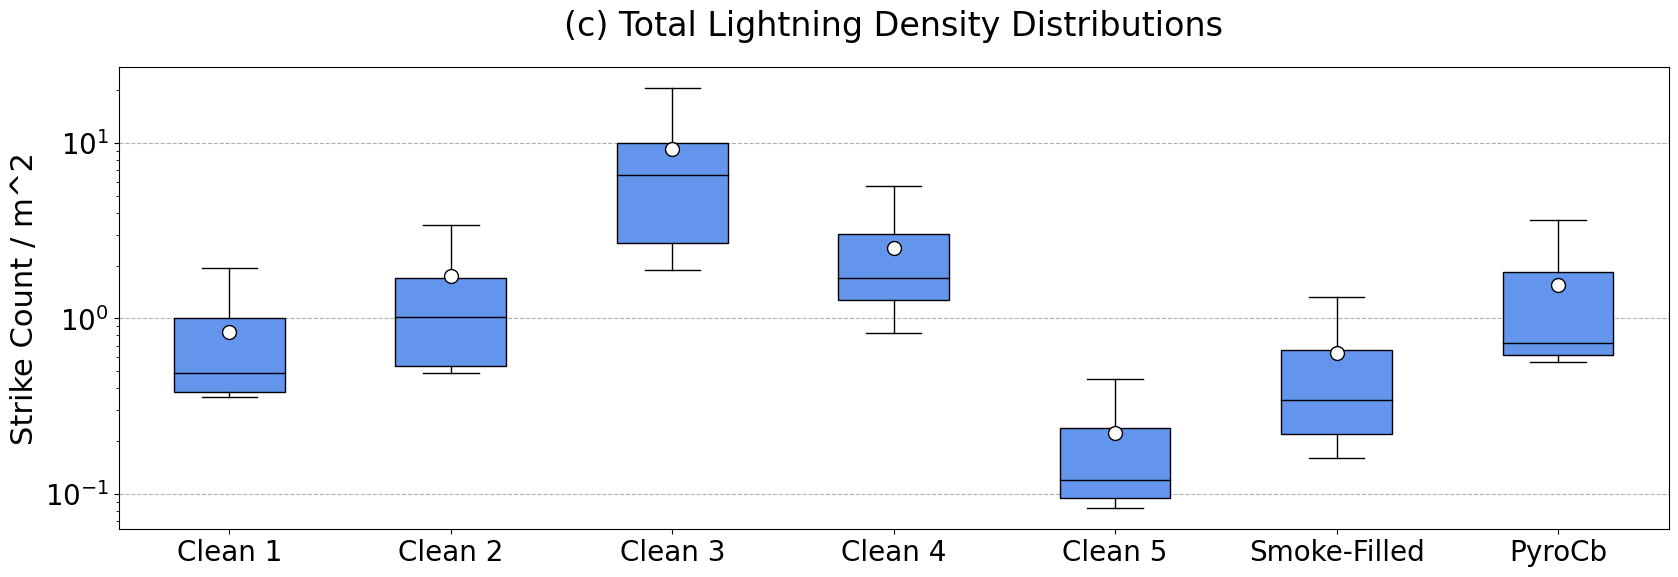

In [189]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Strike Count / m^2", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
# plt.ylim(0, 25)
plt.yscale("log")
arr_smoke = np.array(smoke_total_density_flat) 
arr_smoke = arr_smoke[arr_smoke < 100]
data = [clean1_total_density_flat, clean2_total_density_flat, clean3_total_density_flat, clean4_total_density_flat, 
        clean5_total_density_flat, arr_smoke, pyrocb_total_density_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

# x = np.arange(1, 8, 1)
# for i in range(0, 7, 1):
#     plt.annotate(len(data[i]), (x[i] - 0.07, 1000), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

# firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.05),
#             ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(c) Total Lightning Density Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.savefig("figure8c", bbox_inches = "tight", dpi = 900)
plt.show()



/home/elenadworak/anaconda3/envs/xesmf_env/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


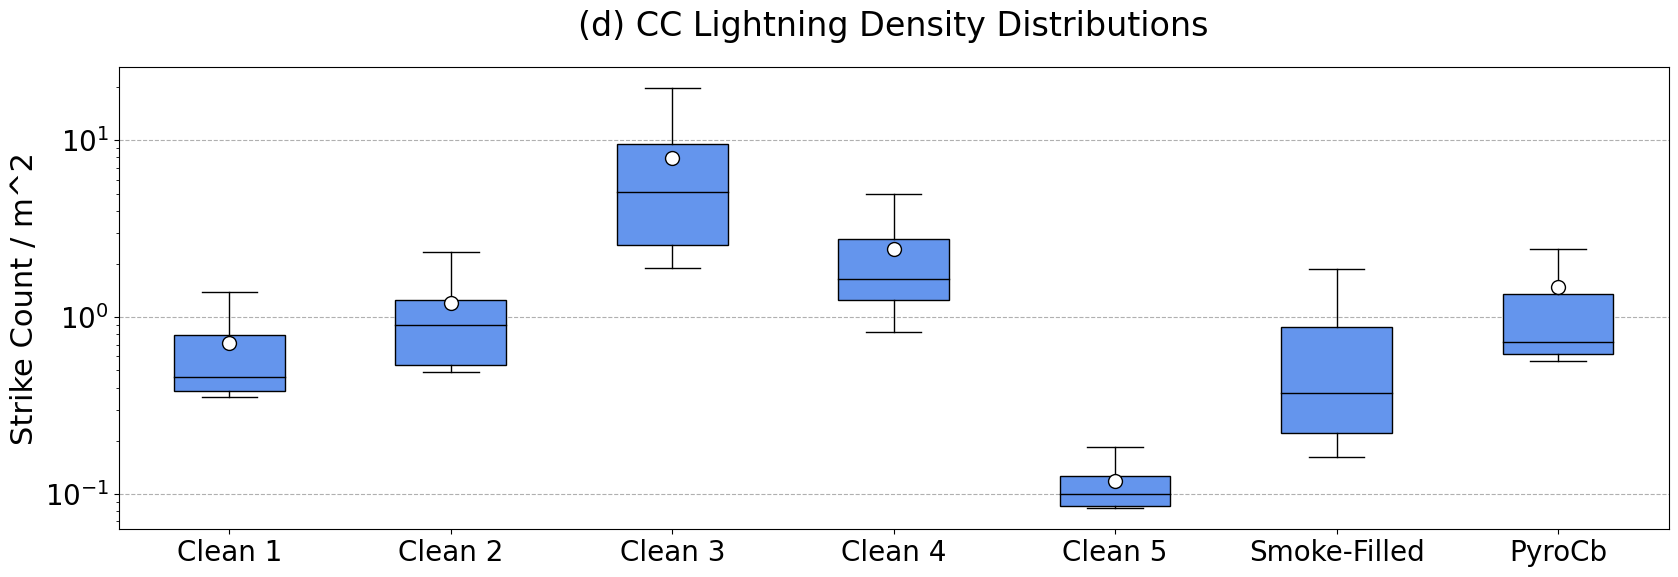

In [190]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Strike Count / m^2", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
plt.yscale("log")
# plt.ylim(0, 25)
data = [clean1_cloud_density_flat, clean2_cloud_density_flat, clean3_cloud_density_flat, clean4_cloud_density_flat, 
        clean5_cloud_density_flat, smoke_cloud_density_flat, pyrocb_cloud_density_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

# x = np.arange(1, 8, 1)
# for i in range(0, 7, 1):
#     plt.annotate(len(data[i]), (x[i] - 0.07, 1000), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

# firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.05),
#             ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(d) CC Lightning Density Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


/home/elenadworak/anaconda3/envs/xesmf_env/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


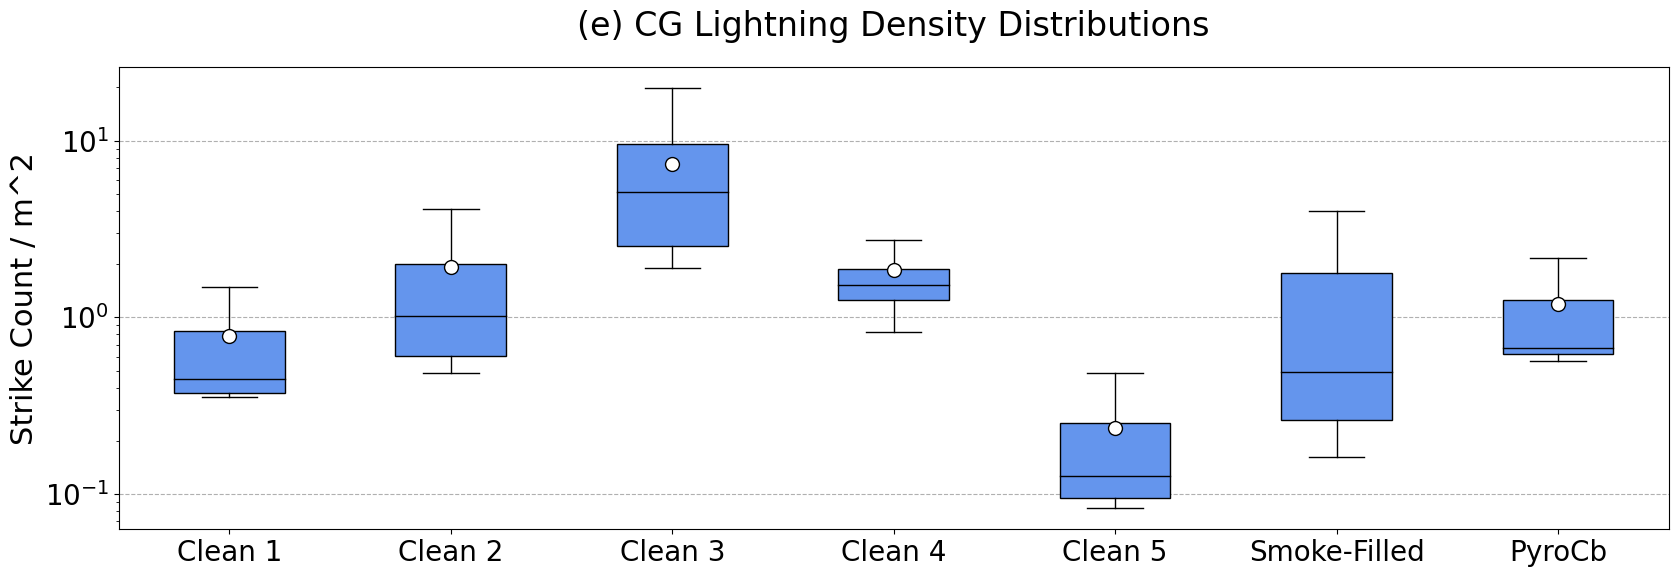

In [191]:
fig, ax = plt.subplots(figsize = (20,6))

ax.set_ylabel("Strike Count / m^2", color = "black", fontsize = 22)
plt.yticks(fontsize = 20, color = "black")
plt.yscale("log")
# plt.ylim(-100, 20)
data = [clean1_ground_density_flat, clean2_ground_density_flat, clean3_ground_density_flat, clean4_ground_density_flat, 
        clean5_ground_density_flat, smoke_ground_density_flat, pyrocb_ground_density_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), boxprops = dict(facecolor = "cornflowerblue"))
        
labels = ["Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5", "Smoke-Filled", "PyroCb"]  
ax.set_xticklabels(labels, fontsize = 20)

# x = np.arange(1, 8, 1)
# for i in range(0, 7, 1):
#     plt.annotate(len(data[i]), (x[i] - 0.07, 1000), rotation=90, fontsize = 18, color = "navy")

orangeline = mpatches.Patch(facecolor='darkorange', edgecolor = "darkorange", label=("PyroCb Third Quartile"))
timecount = mpatches.Patch(facecolor='navy', edgecolor = "navy", label=("Number of Time Intervals"))

# firstlegend = fig.legend(handles=[orangeline, timecount], loc='lower center', 
#             bbox_to_anchor=(0.5, -0.05),
#             ncol=2, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)


plt.gca().yaxis.grid(True, linestyle='--')
ax.set_title('(e) CG Lightning Density Distributions', fontsize = 24, y=1.05)

# plt.savefig("boxplot_posneg_parallax_allcases.png",bbox_inches = "tight", dpi = 800)
plt.show()


# FUCK THE MEGA PLOT

## total density

In [192]:
# colorbar 

# if x <= 20: "cornflowerblue"
# if (x > 20) & (x <= 60): "blue"
# if (x > 60) & (x <= 100): "orange"   
# if (x > 100) & (x <= 140): "darkorange"
# if (x > 140): "red"


colormap = LinearSegmentedColormap.from_list('custom', 
                                        [(0, "cornflowerblue"), 
                                        (0.2, "blue"), 
                                        (0.4, "orange"),
                                        (0.6, "darkorange"), 
                                        (1.0, 'red'),                                        
                                        ], N=5)
# 0-150 
# 30, 60, 90, 120, 150

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

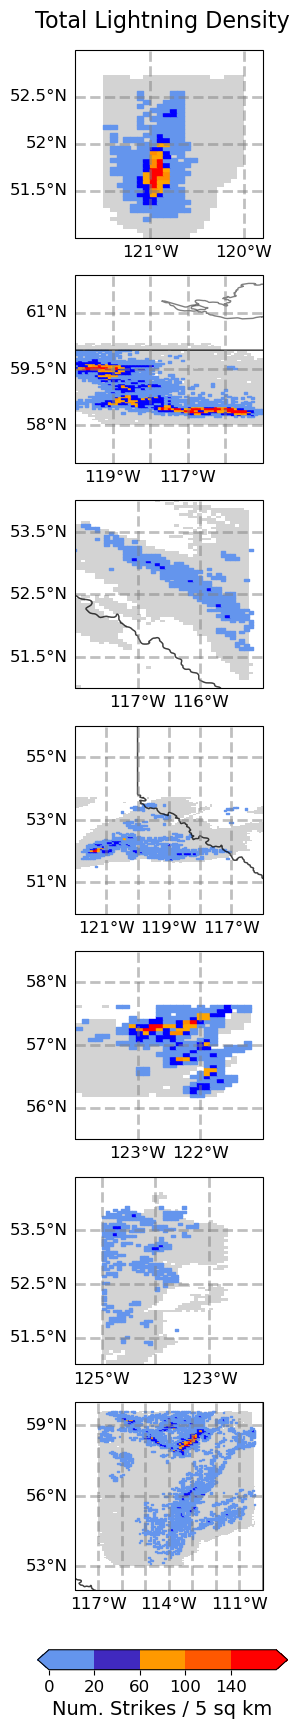

In [193]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb, patches_lt_smoke, patches_lt_clean1, patches_lt_clean2, 
             patches_lt_clean3, patches_lt_clean4, patches_lt_clean5]
color_lt = [color_lt_pyrocb, color_lt_smoke, color_lt_clean1, color_lt_clean2, 
             color_lt_clean3, color_lt_clean4, color_lt_clean5]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
titles = ["PyroCb", "Smoke", "Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]

for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'Num. Strikes / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 

fig.suptitle("Total Lightning Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## CC denisty

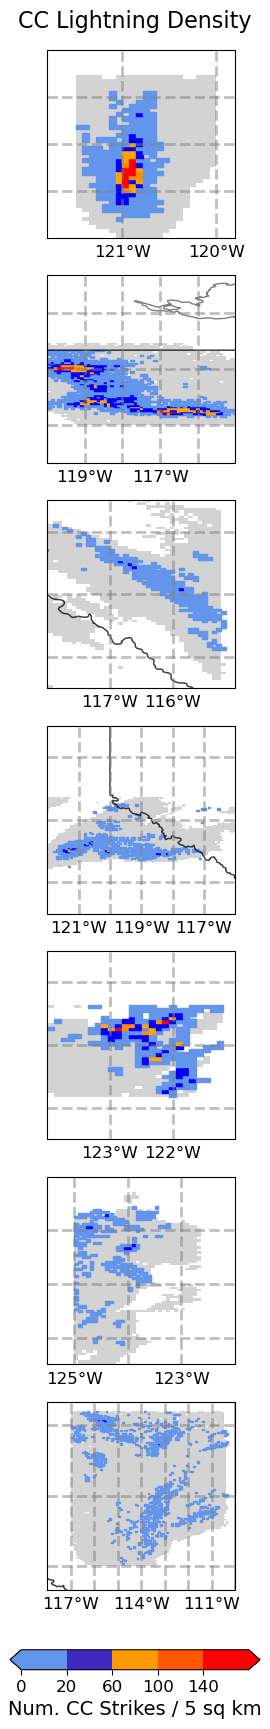

In [194]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cloud, patches_lt_smoke_cloud, patches_lt_clean1_cloud, patches_lt_clean2_cloud, 
             patches_lt_clean3_cloud, patches_lt_clean4_cloud, patches_lt_clean5_cloud]
color_lt = [color_lt_pyrocb_cloud, color_lt_smoke_cloud, color_lt_clean1_cloud, color_lt_clean2_cloud, 
             color_lt_clean3_cloud, color_lt_clean4_cloud, color_lt_clean5_cloud]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'Num. CC Strikes / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 

fig.suptitle("CC Lightning Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## CG

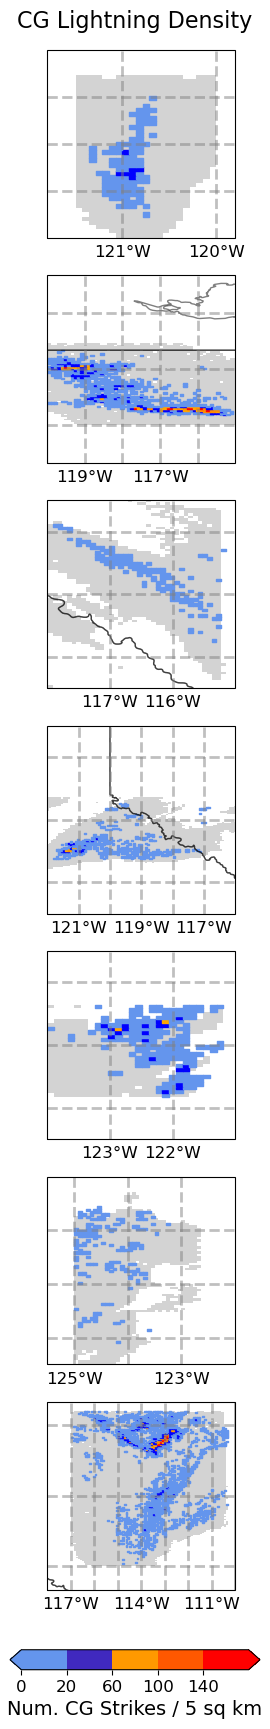

In [195]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_ground, patches_lt_smoke_ground, patches_lt_clean1_ground, patches_lt_clean2_ground, 
             patches_lt_clean3_ground, patches_lt_clean4_ground, patches_lt_clean5_ground]
color_lt = [color_lt_pyrocb_ground, color_lt_smoke_ground, color_lt_clean1_ground, color_lt_clean2_ground, 
             color_lt_clean3_ground, color_lt_clean4_ground, color_lt_clean5_ground]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'Num. CG Strikes / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 

fig.suptitle("CG Lightning Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()


## CC:CG

In [196]:
# if x <= 3: 
#     color_lt_clean5_cccg.append("cornflowerblue")
# if (x > 3) & (x <= 6): 
#     color_lt_clean5_cccg.append("blue")
# if (x > 6) & (x <= 9): 
#     color_lt_clean5_cccg.append("orange")   
# if (x > 9) & (x <= 12): 
#     color_lt_clean5_cccg.append("darkorange")
# if (x > 12): 
#     color_lt_clean5_cccg.append("red")



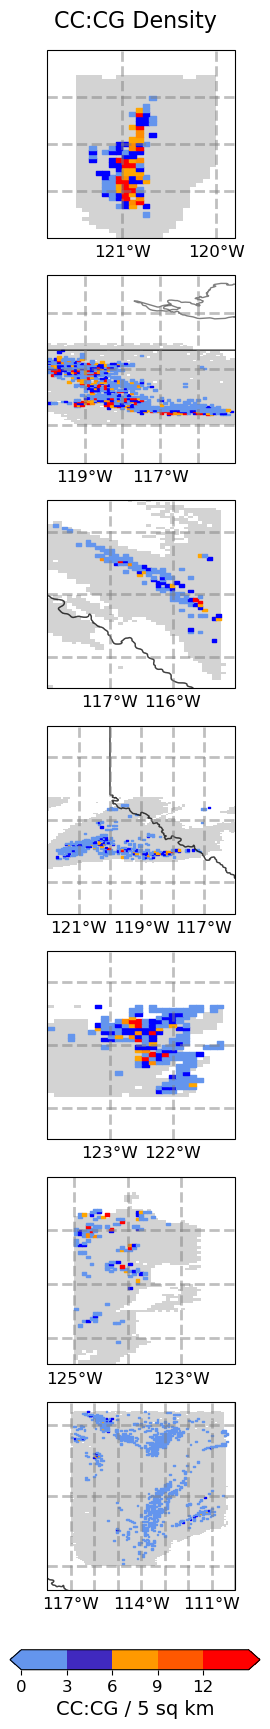

In [197]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cccg, patches_lt_smoke_cccg, patches_lt_clean1_cccg, patches_lt_clean2_cccg, 
             patches_lt_clean3_cccg, patches_lt_clean4_cccg, patches_lt_clean5_cccg]
color_lt = [color_lt_pyrocb_cccg, color_lt_smoke_cccg, color_lt_clean1_cccg, color_lt_clean2_cccg, 
             color_lt_clean3_cccg, color_lt_clean4_cccg, color_lt_clean5_cccg]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
titles = ["PyroCb", "Smoke", "Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]

for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= 'CC:CG / 5 sq km', fontsize = 14)
cmappable.set_clim(0, 12) 
cbar.ax.set_xticklabels(['0', '3', '6', '9', '12']) 

fig.suptitle("CC:CG Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## perc pos

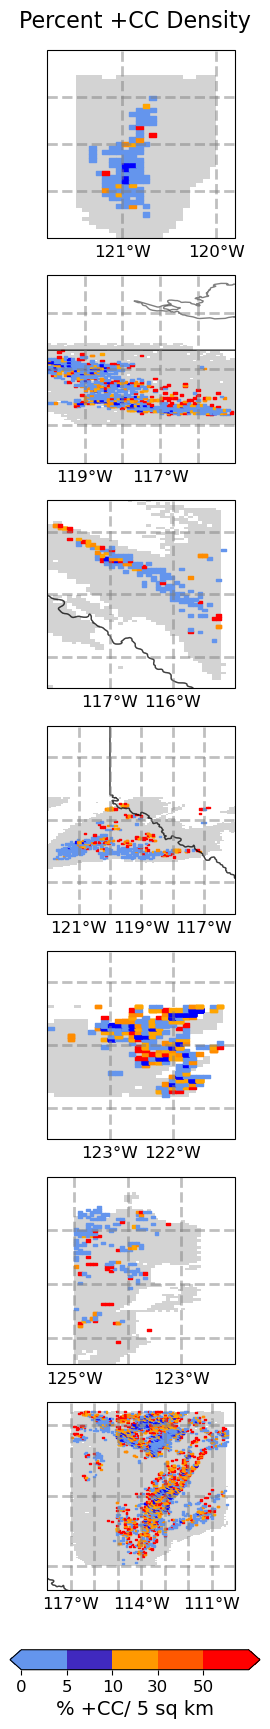

In [198]:
fig  = plt.figure(figsize=(5, 20)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_percpos, patches_lt_smoke_percpos, patches_lt_clean1_percpos, patches_lt_clean2_percpos, 
             patches_lt_clean3_percpos, patches_lt_clean4_percpos, patches_lt_clean5_percpos]
color_lt = [color_lt_pyrocb_percpos, color_lt_smoke_percpos, color_lt_clean1_percpos, color_lt_clean2_percpos, 
             color_lt_clean3_percpos, color_lt_clean4_percpos, color_lt_clean5_percpos]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])
        
titles = ["PyroCb", "Smoke", "Clean 1", "Clean 2", "Clean 3", "Clean 4", "Clean 5"]

for i in range(0, 7):
    ax = fig.add_subplot(7, 1, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    plt.ylabel(titles[i])
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.25, 0.07, 0.5, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 20, 40, 60, 80]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(12)
cbar.set_label(label= '% +CC/ 5 sq km', fontsize = 14)
cmappable.set_clim(0, 100) 
cbar.ax.set_xticklabels(['0', '5', '10', '30', '50']) 

fig.suptitle("Percent +CC Density", fontsize = 16, y = 0.9)

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
plt.show()

## 5 columns 

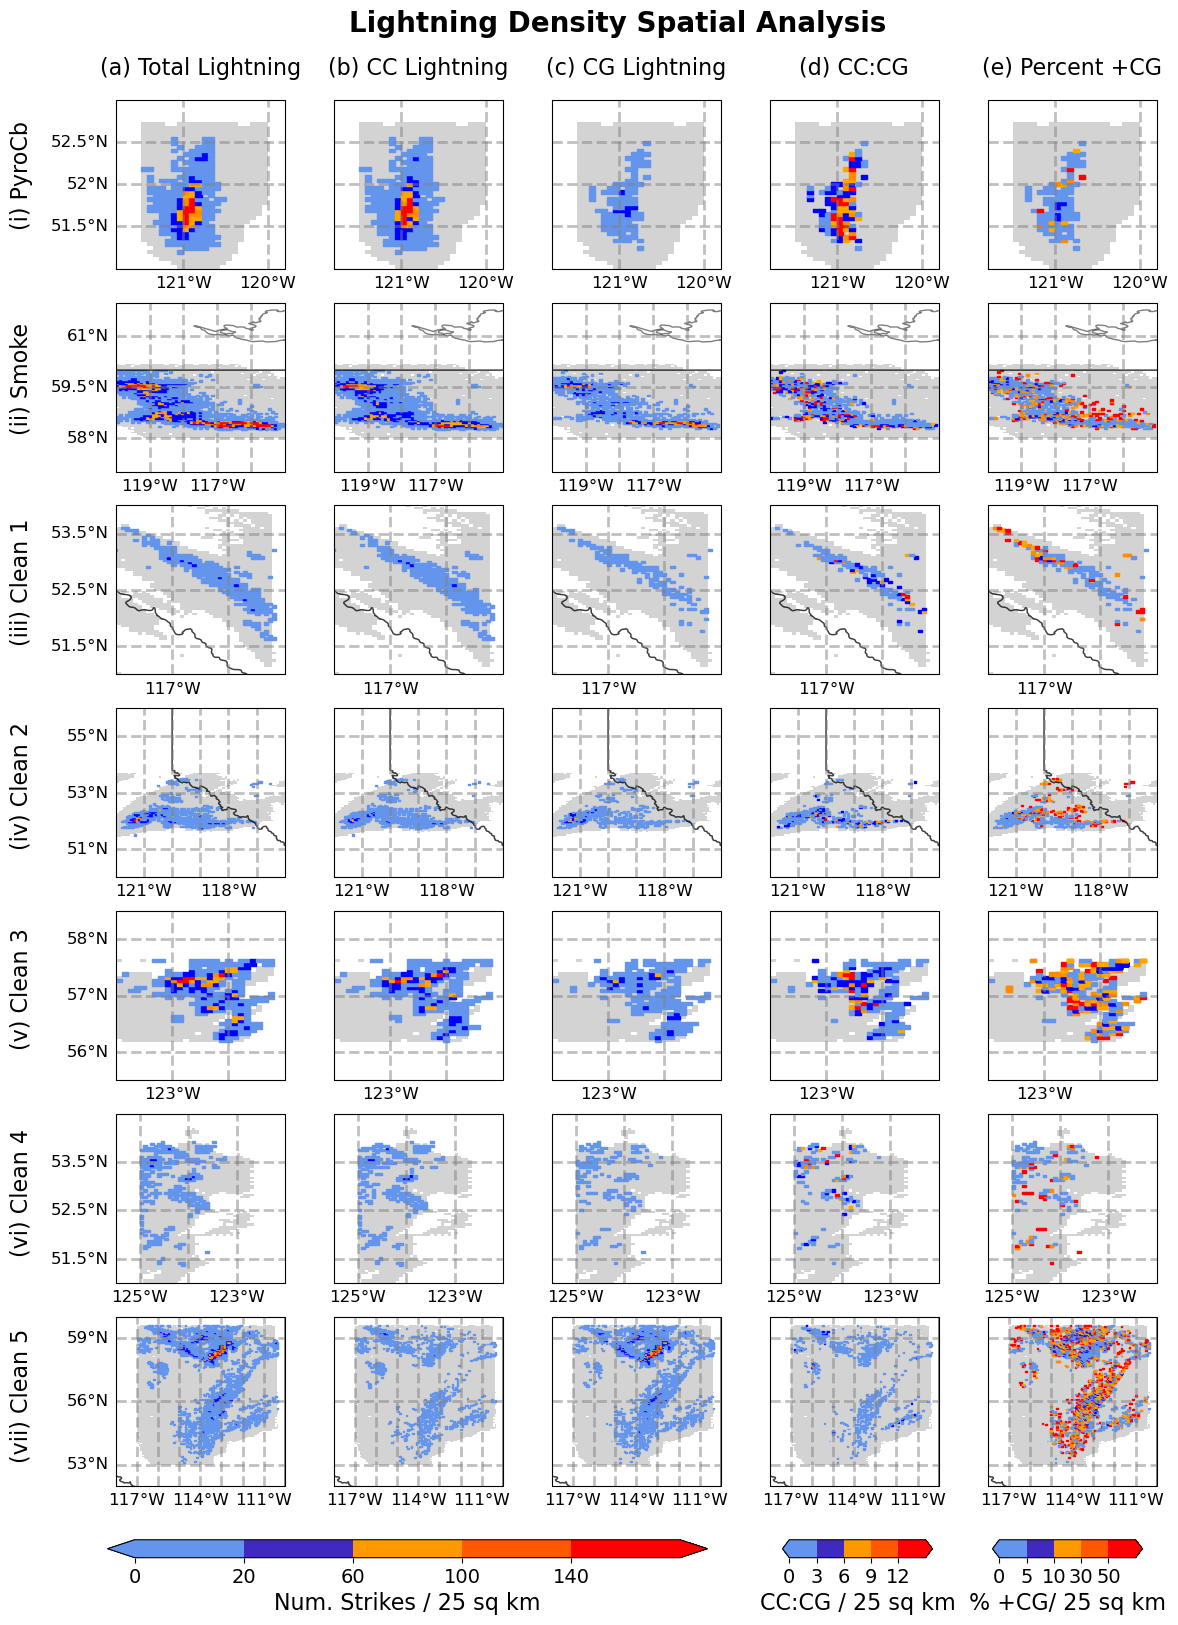

In [199]:
fig  = plt.figure(figsize=(15, 18)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb, patches_lt_smoke, patches_lt_clean1, patches_lt_clean2, 
             patches_lt_clean3, patches_lt_clean4, patches_lt_clean5]
color_lt = [color_lt_pyrocb, color_lt_smoke, color_lt_clean1, color_lt_clean2, 
             color_lt_clean3, color_lt_clean4, color_lt_clean5]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])


for i in range(0, 7):
    # 1, 4, 7, 10, 13
    ax = fig.add_subplot(7, 5, 5*i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    # ax.set_ylabel(titles[i], fontsize = 16, rotation = 90, labelpad = 20)

    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    
ax.set_title("(a) Total Lightning", fontsize = 16, y = 8.3)


# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cloud, patches_lt_smoke_cloud, patches_lt_clean1_cloud, patches_lt_clean2_cloud, 
             patches_lt_clean3_cloud, patches_lt_clean4_cloud, patches_lt_clean5_cloud]
color_lt = [color_lt_pyrocb_cloud, color_lt_smoke_cloud, color_lt_clean1_cloud, color_lt_clean2_cloud, 
             color_lt_clean3_cloud, color_lt_clean4_cloud, color_lt_clean5_cloud]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+2, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

ax.set_title("(b) CC Lightning", fontsize = 16, y = 8.3)

# ---------------------------------------------------------------------


patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_ground, patches_lt_smoke_ground, patches_lt_clean1_ground, patches_lt_clean2_ground, 
             patches_lt_clean3_ground, patches_lt_clean4_ground, patches_lt_clean5_ground]
color_lt = [color_lt_pyrocb_ground, color_lt_smoke_ground, color_lt_clean1_ground, color_lt_clean2_ground, 
             color_lt_clean3_ground, color_lt_clean4_ground, color_lt_clean5_ground]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+3, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}   
    
ax.set_title("(c) CG Lightning", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.16, 0.07, 0.4, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= 'Num. Strikes / 25 sq km', fontsize = 16)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 



# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cccg, patches_lt_smoke_cccg, patches_lt_clean1_cccg, patches_lt_clean2_cccg, 
             patches_lt_clean3_cccg, patches_lt_clean4_cccg, patches_lt_clean5_cccg]
color_lt = [color_lt_pyrocb_cccg, color_lt_smoke_cccg, color_lt_clean1_cccg, color_lt_clean2_cccg, 
             color_lt_clean3_cccg, color_lt_clean4_cccg, color_lt_clean5_cccg]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+4, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

ax.set_title("(d) CC:CG", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.61, 0.07, 0.1, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= 'CC:CG / 25 sq km', fontsize = 16)
cmappable.set_clim(0, 12) 
cbar.ax.set_xticklabels(['0', '3', '6', '9', '12']) 


# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_percpos, patches_lt_smoke_percpos, patches_lt_clean1_percpos, patches_lt_clean2_percpos, 
             patches_lt_clean3_percpos, patches_lt_clean4_percpos, patches_lt_clean5_percpos]
color_lt = [color_lt_pyrocb_percpos, color_lt_smoke_percpos, color_lt_clean1_percpos, color_lt_clean2_percpos, 
             color_lt_clean3_percpos, color_lt_clean4_percpos, color_lt_clean5_percpos]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+5, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.75, 0.07, 0.1, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 20, 40, 60, 80]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= '% +CG/ 25 sq km', fontsize = 16)
cmappable.set_clim(0, 100) 
cbar.ax.set_xticklabels(['0', '5', '10', '30', '50']) 

ax.set_title("(e) Percent +CG", fontsize = 16, y = 8.3)

fig.text(0.095, 0.838, "(i) PyroCb", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.725, "(ii) Smoke", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.612, "(iii) Clean 1", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.499, "(iv) Clean 2", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.386, "(v) Clean 3", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.273, "(vi) Clean 4", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.16, "(vii) Clean 5", va='center', rotation='vertical', fontsize = 16)


plt.subplots_adjust(hspace = 0.2, wspace = -0.25) # h: height, w: width 
plt.suptitle("Lightning Density Spatial Analysis", weight= "bold", fontsize = 20, y = 0.93)
plt.savefig("figure9", bbox_inches = "tight", dpi = 900)

plt.show()



## 4 columns

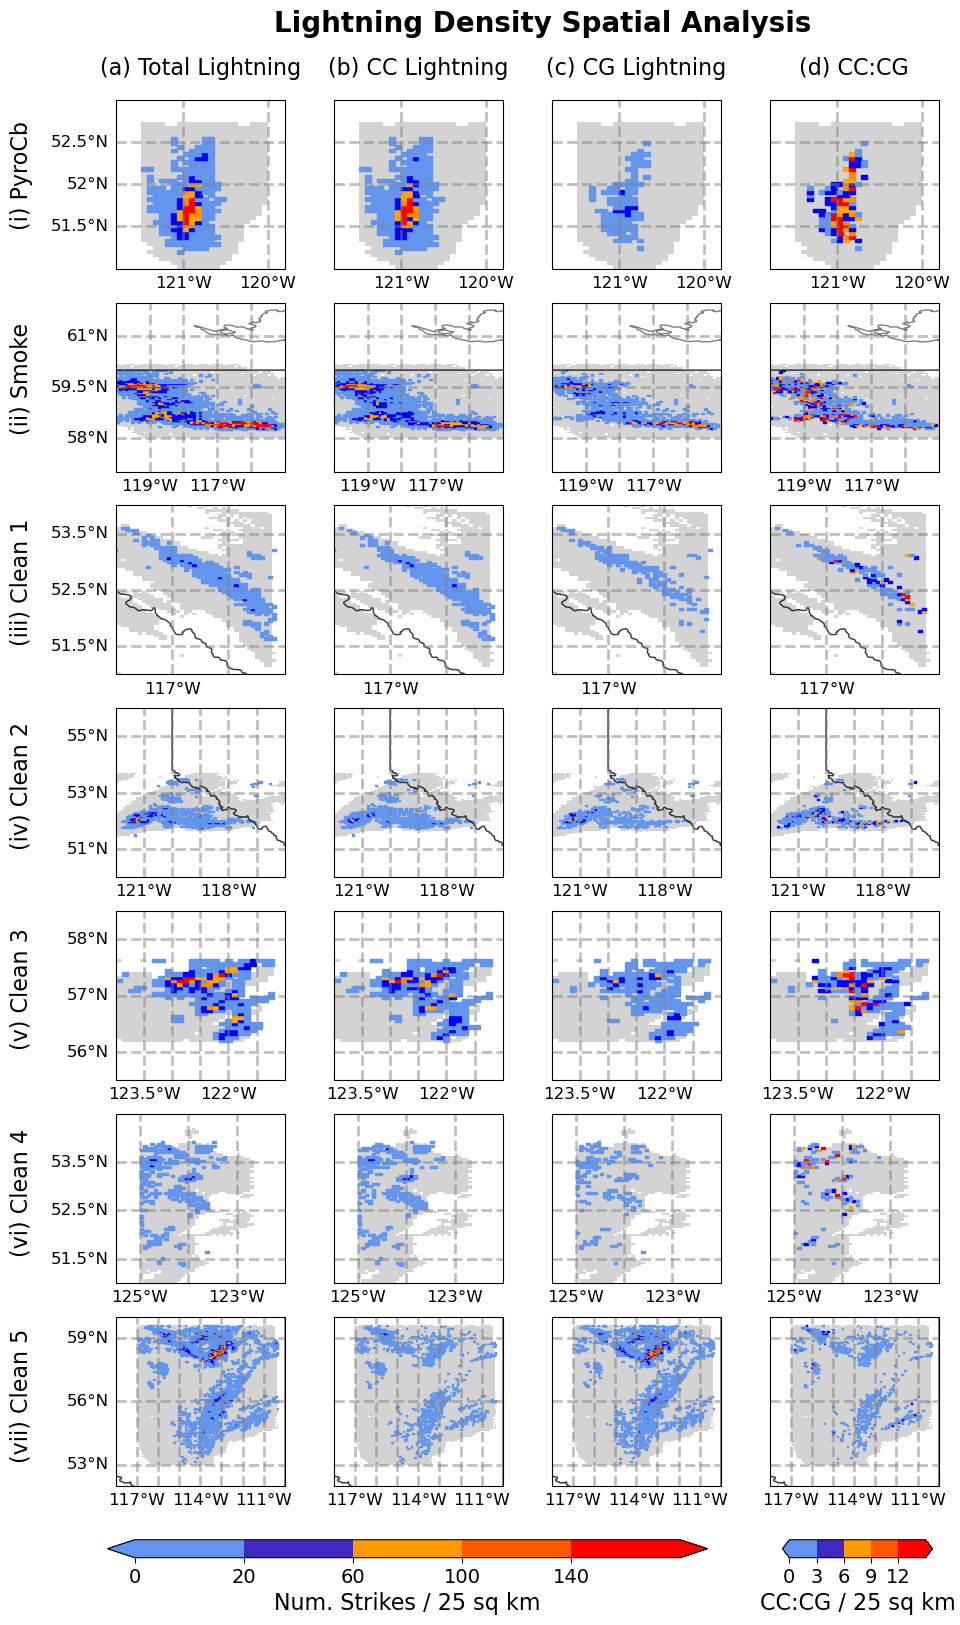

In [202]:
fig  = plt.figure(figsize=(15, 18)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb, patches_lt_smoke, patches_lt_clean1, patches_lt_clean2, 
             patches_lt_clean3, patches_lt_clean4, patches_lt_clean5]
color_lt = [color_lt_pyrocb, color_lt_smoke, color_lt_clean1, color_lt_clean2, 
             color_lt_clean3, color_lt_clean4, color_lt_clean5]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123.5, -123, -122.5, -122, -121.5], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])


for i in range(0, 7):
    # 1, 4, 7, 10, 13
    ax = fig.add_subplot(7, 5, 5*i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    # ax.set_ylabel(titles[i], fontsize = 16, rotation = 90, labelpad = 20)

    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    
ax.set_title("(a) Total Lightning", fontsize = 16, y = 8.3)


# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cloud, patches_lt_smoke_cloud, patches_lt_clean1_cloud, patches_lt_clean2_cloud, 
             patches_lt_clean3_cloud, patches_lt_clean4_cloud, patches_lt_clean5_cloud]
color_lt = [color_lt_pyrocb_cloud, color_lt_smoke_cloud, color_lt_clean1_cloud, color_lt_clean2_cloud, 
             color_lt_clean3_cloud, color_lt_clean4_cloud, color_lt_clean5_cloud]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+2, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

ax.set_title("(b) CC Lightning", fontsize = 16, y = 8.3)

# ---------------------------------------------------------------------


patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_ground, patches_lt_smoke_ground, patches_lt_clean1_ground, patches_lt_clean2_ground, 
             patches_lt_clean3_ground, patches_lt_clean4_ground, patches_lt_clean5_ground]
color_lt = [color_lt_pyrocb_ground, color_lt_smoke_ground, color_lt_clean1_ground, color_lt_clean2_ground, 
             color_lt_clean3_ground, color_lt_clean4_ground, color_lt_clean5_ground]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+3, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}   
    
ax.set_title("(c) CG Lightning", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.16, 0.07, 0.4, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 28, 56, 84, 112]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= 'Num. Strikes / 25 sq km', fontsize = 16)
cmappable.set_clim(0, 140) 
cbar.ax.set_xticklabels(['0', '20', '60', '100', '140']) 



# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cccg, patches_lt_smoke_cccg, patches_lt_clean1_cccg, patches_lt_clean2_cccg, 
             patches_lt_clean3_cccg, patches_lt_clean4_cccg, patches_lt_clean5_cccg]
color_lt = [color_lt_pyrocb_cccg, color_lt_smoke_cccg, color_lt_clean1_cccg, color_lt_clean2_cccg, 
             color_lt_clean3_cccg, color_lt_clean4_cccg, color_lt_clean5_cccg]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(7, 5, 5*i+4, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

ax.set_title("(d) CC:CG", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.61, 0.07, 0.1, 0.01])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="horizontal",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_xticklabels():
        t.set_fontsize(14)
cbar.set_label(label= 'CC:CG / 25 sq km', fontsize = 16)
cmappable.set_clim(0, 12) 
cbar.ax.set_xticklabels(['0', '3', '6', '9', '12']) 



fig.text(0.095, 0.838, "(i) PyroCb", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.725, "(ii) Smoke", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.612, "(iii) Clean 1", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.499, "(iv) Clean 2", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.386, "(v) Clean 3", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.273, "(vi) Clean 4", va='center', rotation='vertical', fontsize = 16)
fig.text(0.095, 0.16, "(vii) Clean 5", va='center', rotation='vertical', fontsize = 16)


plt.subplots_adjust(hspace = 0.2, wspace = -0.25) # h: height, w: width 
plt.suptitle("Lightning Density Spatial Analysis", weight= "bold", fontsize = 20, x = 0.45, y = 0.93)
plt.savefig("figure9", bbox_inches = "tight", dpi = 900)

plt.show()



## mega plot for agu poster

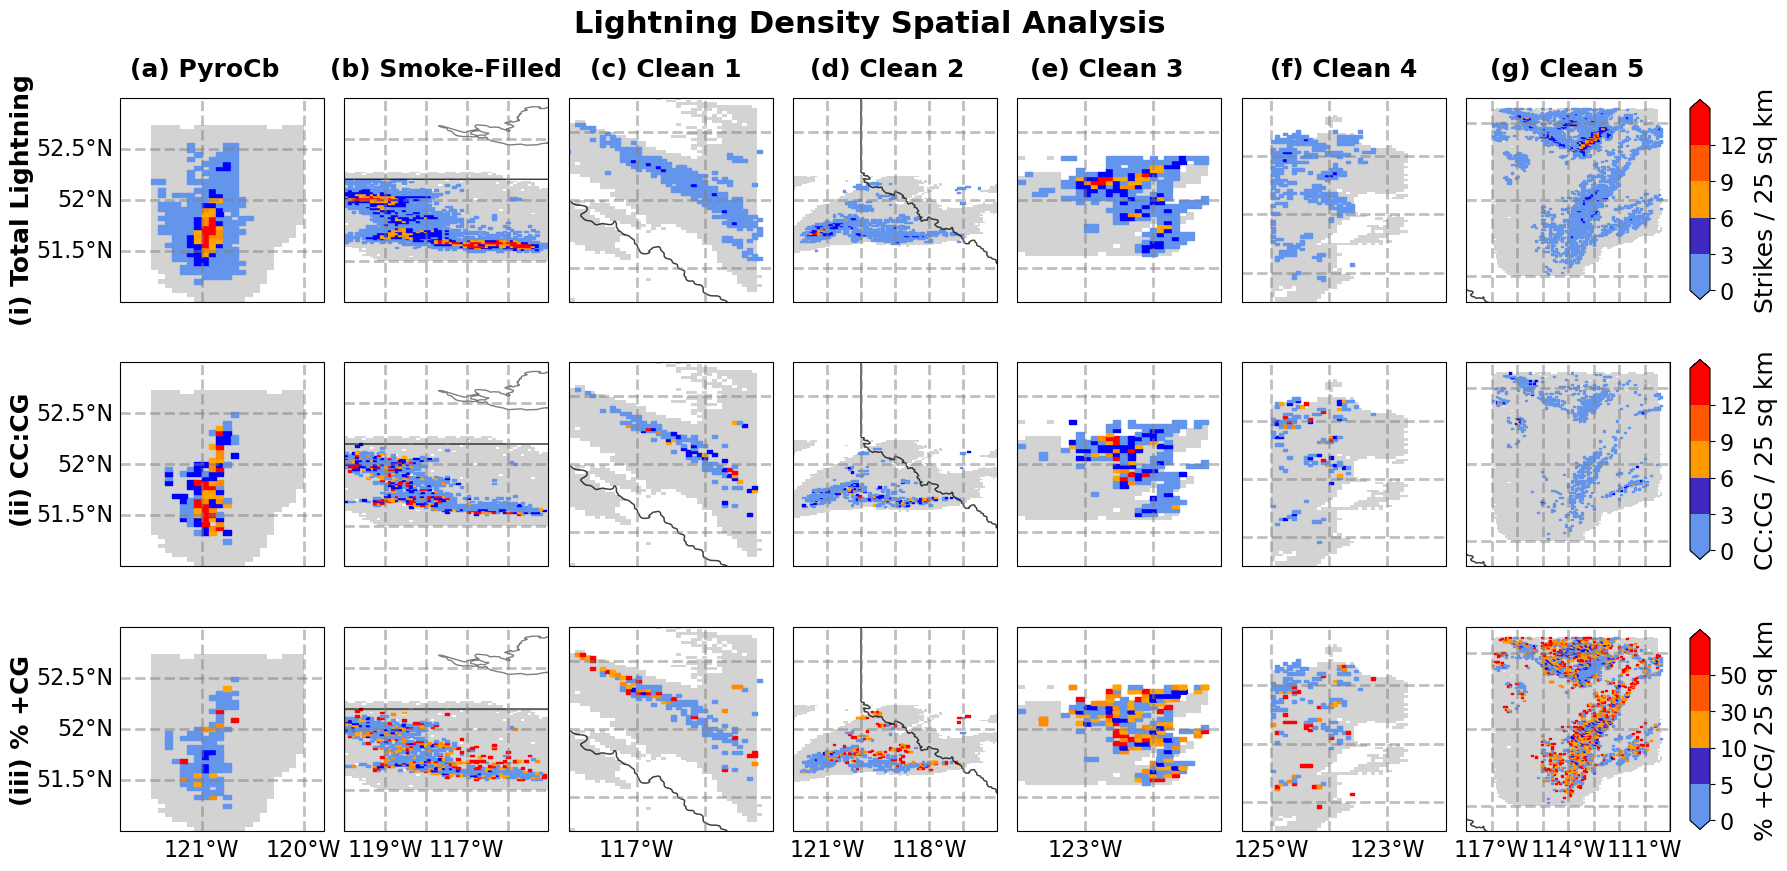

In [200]:
fig  = plt.figure(figsize=(20, 10)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb, patches_lt_smoke, patches_lt_clean1, patches_lt_clean2, 
             patches_lt_clean3, patches_lt_clean4, patches_lt_clean5]
color_lt = [color_lt_pyrocb, color_lt_smoke, color_lt_clean1, color_lt_clean2, 
             color_lt_clean3, color_lt_clean4, color_lt_clean5]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])


for i in range(0, 7):
    # 1, 4, 7, 10, 13
    ax = fig.add_subplot(3, 7, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    # ax.set_ylabel(titles[i], fontsize = 16, rotation = 90, labelpad = 20)

    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if i > 0: 
        gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

# [left, bottom, width, height]
cax = plt.axes([0.91, 0.66, 0.01, 0.2])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="vertical",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_yticklabels():
        t.set_fontsize(16)
cbar.set_label(label= 'Strikes / 25 sq km', fontsize = 18)
cmappable.set_clim(0, 12) 
cbar.ax.set_yticklabels(['0', '3', '6', '9', '12']) 

# ax.set_title("(a) Total Lightning", fontsize = 16, y = 8.3)

# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cccg, patches_lt_smoke_cccg, patches_lt_clean1_cccg, patches_lt_clean2_cccg, 
             patches_lt_clean3_cccg, patches_lt_clean4_cccg, patches_lt_clean5_cccg]
color_lt = [color_lt_pyrocb_cccg, color_lt_smoke_cccg, color_lt_clean1_cccg, color_lt_clean2_cccg, 
             color_lt_clean3_cccg, color_lt_clean4_cccg, color_lt_clean5_cccg]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(3, 7, i+8, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if i > 0: 
        gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

# ax.set_title("(d) CC:CG", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.91, 0.4, 0.01, 0.2])

cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="vertical",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_yticklabels():
        t.set_fontsize(16)
cbar.set_label(label= 'CC:CG / 25 sq km', fontsize = 18)
cmappable.set_clim(0, 12) 
cbar.ax.set_yticklabels(['0', '3', '6', '9', '12']) 


# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_percpos, patches_lt_smoke_percpos, patches_lt_clean1_percpos, patches_lt_clean2_percpos, 
             patches_lt_clean3_percpos, patches_lt_clean4_percpos, patches_lt_clean5_percpos]
color_lt = [color_lt_pyrocb_percpos, color_lt_smoke_percpos, color_lt_clean1_percpos, color_lt_clean2_percpos, 
             color_lt_clean3_percpos, color_lt_clean4_percpos, color_lt_clean5_percpos]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

for i in range(0, 7):
    ax = fig.add_subplot(3, 7, i+15, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.right_labels = False
    if i > 0: 
        gl.left_labels = False    
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}
    
# [left, bottom, width, height]
cax = plt.axes([0.91, 0.13, 0.01, 0.2])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="vertical",  cax = cax, ticks = [0, 20, 40, 60, 80]) # shrink = 0.3,

for t in cbar.ax.get_yticklabels():
        t.set_fontsize(16)
cbar.set_label(label= '% +CG/ 25 sq km', fontsize = 18)
cmappable.set_clim(0, 100) 
cbar.ax.set_yticklabels(['0', '5', '10', '30', '50']) 

# ax.set_title("(e) Percent +CG", fontsize = 16, y = 8.3)

fig.text(0.13, 0.89, "(a) PyroCb", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.23, 0.89, "(b) Smoke-Filled", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.36, 0.89, "(c) Clean 1", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.47, 0.89, "(d) Clean 2", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.58, 0.89, "(e) Clean 3", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.70, 0.89, "(f) Clean 4", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.81, 0.89, "(g) Clean 5", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)

fig.text(0.07, 0.76, "(i) Total Lightning", va='center', rotation='vertical',  weight= "bold",fontsize = 18)
fig.text(0.07, 0.5, "(ii) CC:CG", va='center', rotation='vertical',  weight= "bold",fontsize = 18)
fig.text(0.07, 0.23, "(iii) % +CG", va='center', rotation='vertical',  weight= "bold",fontsize = 18)


plt.subplots_adjust(hspace = 0.1, wspace = 0.1) # h: height, w: width 
plt.suptitle("Lightning Density Spatial Analysis", weight= "bold", fontsize = 22, y = 0.95)
plt.show()



# 4 column

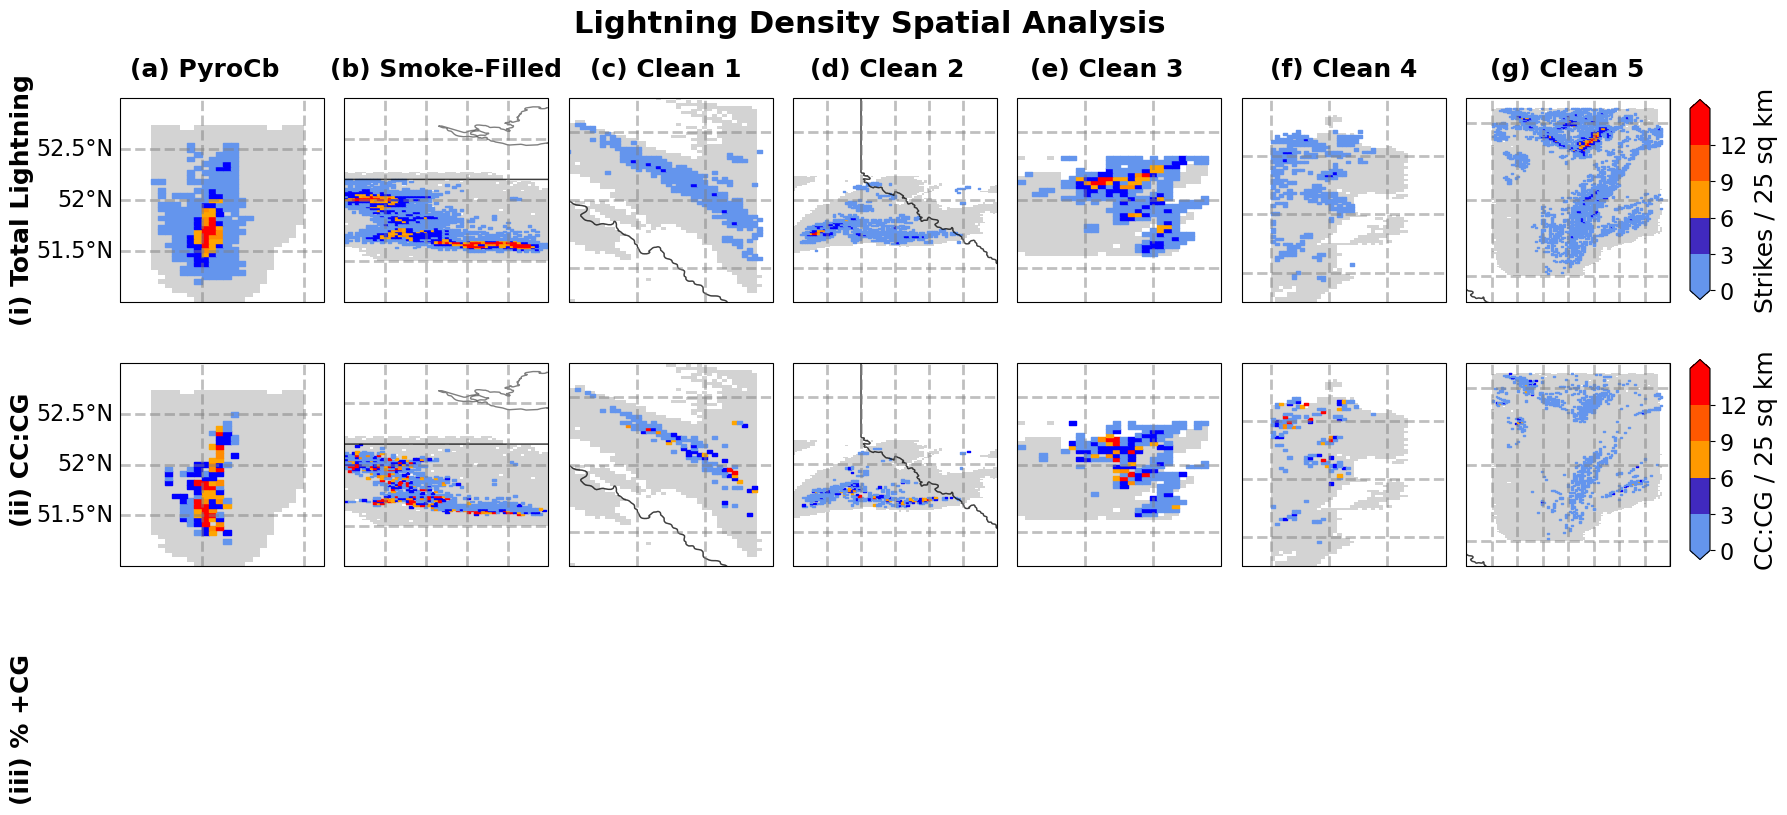

In [207]:
fig  = plt.figure(figsize=(20, 10)) 

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb, patches_lt_smoke, patches_lt_clean1, patches_lt_clean2, 
             patches_lt_clean3, patches_lt_clean4, patches_lt_clean5]
color_lt = [color_lt_pyrocb, color_lt_smoke, color_lt_clean1, color_lt_clean2, 
             color_lt_clean3, color_lt_clean4, color_lt_clean5]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

# only want x-ticks on bottom of first row 
xticks = [[ -121, -120], [-119, -118, -117, -116], [-117, -116], [-121, -120, -119, -118, -117], 
          [-123, -122], [-125, -124, -123, -122, -121], [-117, -116, -115, -114, -113, -112, -111]]

# yticks on all 
yticks = [[51.5, 52, 52.5], [58, 59.5, 61], [51.5, 52.5, 53.5], [51, 53, 55], 
          [56, 57, 58], [51.5, 52.5, 53.5], [53, 56, 59]]

# 1 : 1 ratio 
x_lim = ([-121.8, -119.8], [-120, -115], [-118, -115], [-122, -116], 
         [-124, -121], [-125.5, -122], [-118, -110])

y_lim = ([51, 53], [57, 62], [51, 54], [50, 56], 
         [55.5, 58.5], [51, 54.5], [52, 60])


for i in range(0, 7):
    # 1, 4, 7, 10, 13
    ax = fig.add_subplot(3, 7, i+1, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    # plt.ylabel(titles[i], fontsize = 14, rotation = 90, labelpad=20)
    # ax.set_ylabel(titles[i], fontsize = 16, rotation = 90, labelpad = 20)

    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if i > 0: 
        gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

# [left, bottom, width, height]
cax = plt.axes([0.91, 0.66, 0.01, 0.2])
cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="vertical",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_yticklabels():
        t.set_fontsize(16)
cbar.set_label(label= 'Strikes / 25 sq km', fontsize = 18)
cmappable.set_clim(0, 12) 
cbar.ax.set_yticklabels(['0', '3', '6', '9', '12']) 

# ax.set_title("(a) Total Lightning", fontsize = 16, y = 8.3)

# ---------------------------------------------------------------------

patches_bt = [patches_bt_pyrocb, patches_bt_smoke, patches_bt_clean1, patches_bt_clean2, 
             patches_bt_clean3, patches_bt_clean4, patches_bt_clean5]
patches_lt = [patches_lt_pyrocb_cccg, patches_lt_smoke_cccg, patches_lt_clean1_cccg, patches_lt_clean2_cccg, 
             patches_lt_clean3_cccg, patches_lt_clean4_cccg, patches_lt_clean5_cccg]
color_lt = [color_lt_pyrocb_cccg, color_lt_smoke_cccg, color_lt_clean1_cccg, color_lt_clean2_cccg, 
             color_lt_clean3_cccg, color_lt_clean4_cccg, color_lt_clean5_cccg]
grid_corners = [pyrocb_grid_corners_df, smoke_grid_corners_df, clean1_grid_corners_df, clean1_grid_corners_df, 
               clean2_grid_corners_df, clean3_grid_corners_df, clean4_grid_corners_df, clean5_grid_corners_df]

        
for i in range(0, 7):
    ax = fig.add_subplot(3, 7, i+8, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")
    
    plt.gca().yaxis.label.set(rotation='vertical', ha='right', fontsize = 14)
    
    # shading 
    p_bt = PatchCollection(patches_bt[i], facecolor = "lightgrey", alpha=1)
    ax.add_collection(p_bt)
    
    p_lt = PatchCollection(patches_lt[i], alpha=1)
    ax.add_collection(p_lt)
    p_lt.set_color(color_lt[i])

    # Make figure larger
    plt.xlim(x_lim[i])
    plt.ylim(y_lim[i])

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='grey', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if i > 0: 
        gl.left_labels = False
    gl.xlines = True 
    gl.xlocator = mticker.FixedLocator(xticks[i])
    gl.ylocator = mticker.FixedLocator(yticks[i])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

# ax.set_title("(d) CC:CG", fontsize = 16, y = 8.3)

# [left, bottom, width, height]
cax = plt.axes([0.91, 0.4, 0.01, 0.2])

cmappable = ScalarMappable(norm=Normalize(0,1), cmap=colormap)
cbar = plt.colorbar(cmappable, extend='both', orientation="vertical",  cax = cax, ticks = [0, 2.4, 4.8, 7.2, 9.6]) # shrink = 0.3,

for t in cbar.ax.get_yticklabels():
        t.set_fontsize(16)
cbar.set_label(label= 'CC:CG / 25 sq km', fontsize = 18)
cmappable.set_clim(0, 12) 
cbar.ax.set_yticklabels(['0', '3', '6', '9', '12']) 



fig.text(0.13, 0.89, "(a) PyroCb", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.23, 0.89, "(b) Smoke-Filled", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.36, 0.89, "(c) Clean 1", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.47, 0.89, "(d) Clean 2", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.58, 0.89, "(e) Clean 3", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.70, 0.89, "(f) Clean 4", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)
fig.text(0.81, 0.89, "(g) Clean 5", va='center', rotation='horizontal',  weight= "bold",fontsize = 18)

fig.text(0.07, 0.76, "(i) Total Lightning", va='center', rotation='vertical',  weight= "bold",fontsize = 18)
fig.text(0.07, 0.5, "(ii) CC:CG", va='center', rotation='vertical',  weight= "bold",fontsize = 18)
fig.text(0.07, 0.23, "(iii) % +CG", va='center', rotation='vertical',  weight= "bold",fontsize = 18)


plt.subplots_adjust(hspace = 0.1, wspace = 0.1) # h: height, w: width 
plt.suptitle("Lightning Density Spatial Analysis", weight= "bold", fontsize = 22, y = 0.95)
plt.show()



# Statistics

## total density

In [201]:
smoke_total_arr = np.array(smoke_total_density_flat)
smoke_total_arr = smoke_total_arr[smoke_total_arr < 100]
scipy.stats.ttest_ind(smoke_total_arr, pyrocb_ground_density_flat)[1]

7.547843247429339e-37

In [202]:
{scipy.stats.ttest_ind(smoke_total_arr, pyrocb_total_density_flat)[1],
scipy.stats.ttest_ind(pyrocb_total_density_flat, clean1_total_density_flat)[1],
scipy.stats.ttest_ind(pyrocb_total_density_flat, clean2_total_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_total_density_flat, clean3_total_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_total_density_flat, clean4_total_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_total_density_flat, clean5_total_density_flat)[1]}

{0.0,
 1.9789566341482693e-283,
 5.203794384911164e-239,
 4.3337167654424806e-33,
 2.4948777916731362e-27,
 0.0022731412481547387}

## cc density

In [203]:
smoke_cloud_arr = np.array(smoke_cloud_density_flat)
smoke_cloud_arr = smoke_cloud_arr[smoke_cloud_arr < 100]
scipy.stats.ttest_ind(smoke_cloud_arr, pyrocb_ground_density_flat)[1]

9.757745332973593e-133

In [204]:
{scipy.stats.ttest_ind(smoke_cloud_arr, pyrocb_cloud_density_flat)[1],
scipy.stats.ttest_ind(pyrocb_cloud_density_flat, clean1_cloud_density_flat)[1],
scipy.stats.ttest_ind(pyrocb_cloud_density_flat, clean2_cloud_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_cloud_density_flat, clean3_cloud_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_cloud_density_flat, clean4_cloud_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_cloud_density_flat, clean5_cloud_density_flat)[1]}

{0.0,
 4.275499368678554e-255,
 1.2169329140233917e-30,
 3.0027394457784686e-29,
 3.2015151319588935e-09}

## cg density 

In [205]:
smoke_ground_arr = np.array(smoke_ground_density_flat)
smoke_ground_arr = smoke_ground_arr[smoke_ground_arr < 100]
scipy.stats.ttest_ind(smoke_ground_arr, pyrocb_ground_density_flat)[1]

7.496396037257241e-13

In [206]:
{scipy.stats.ttest_ind(smoke_ground_arr, pyrocb_ground_density_flat)[1],
scipy.stats.ttest_ind(pyrocb_ground_density_flat, clean1_ground_density_flat)[1],
scipy.stats.ttest_ind(pyrocb_ground_density_flat, clean2_ground_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_ground_density_flat, clean3_ground_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_ground_density_flat, clean4_ground_density_flat)[1], 
scipy.stats.ttest_ind(pyrocb_ground_density_flat, clean5_ground_density_flat)[1]}

{0.0,
 5.348369937046494e-53,
 7.496396037257241e-13,
 4.280863056799956e-12,
 3.996978408021283e-08,
 5.513090824622366e-08}